# A Code-Centric Introduction to Independent Component Analysis (ICA)

*This is the first in what I'm hoping to make a series of posts on representation learning and unsupervised methods in general. I've noticed that there are far fewer resources out there detailing these topics than there are for common supervised learning topics, and next-to-none that show them off in practice (i.e. with code) along with the underlying math. I'd like these posts to be accessible to a wider audience while still providing mathematical intuition.*

## Part 1: Motivation and Introduction
#### _What is ICA and why would we want to do it?_

Suppose you are at a banquet with $n$ total attendees, all simultaneously engaged in conversation. Should you stand in the middle of this crowd, you will be able to pick out individual voices to tune in and out of at will; however, any microphone positioned in the banquet hall will record an incomprehensible cacaphony, all $n$ voices jumbled together based on their distance from the device. Say you would like to be able to listen to the crowd of voices on a per-speaker basis. With only the one recording, you might<sup>1</sup> be out of luck. If you have recordings from $n$ microphones each placed at different positions rather than one, how can we recover the individual voice signals from every attendee? 

What better way to illustrate this than to listen to some recordings! (The individual source voice signals were created by Google Translate Text-to-Speech and subsequently mixed by me.)

In [1]:
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
from typing import Tuple
import os
import glob
from IPython.display import Audio, display

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
%matplotlib inline

In [4]:
# create convenience function for plotting and playing audio
def show_audio(a: Tuple[int, np.ndarray])->None: # a: (sample_rate, audio_array)
    fig, ax = plt.subplots()
    time_axis = np.linspace(start=0, stop=(len(a[1])/a[0]),num=np.round(len(a[1])))
    ax.plot(time_axis, a[1])
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Amplitude')
    display(Audio(a[1], rate=a[0]))

In [5]:
# collect all the wav files
files = glob.glob('./data/mixed_data/*.wav')

In [6]:
samp_rates = []
sound_list = []

In [7]:
# collect sampling frequencies and audio signals
for f in files:
    samp_rate, sound = wavfile.read(f)
    samp_rates.append(samp_rate)
    sound_list.append(sound)

In [8]:
# store as numpy array
audio_array = np.array(sound_list)

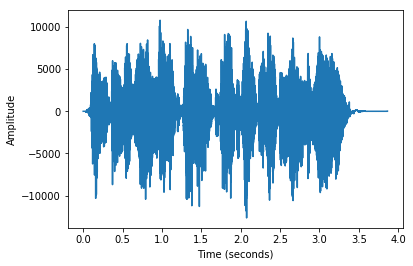

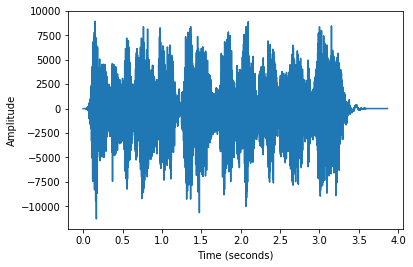

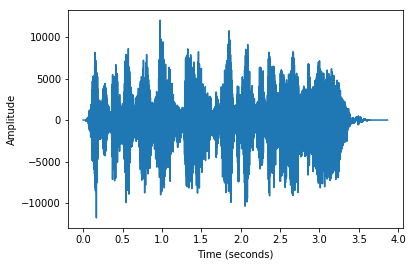

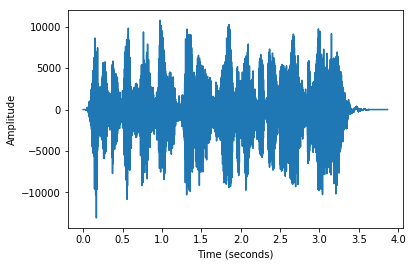

In [9]:
# listen and visualize sound waves as sanity check
for a in zip(samp_rates, sound_list):
    show_audio(a)

Clearly, while we can pick out some of the words being said, these audio clips are a mess.

The general problem of determining sources from observed signals without labels is aptly called _blind source separation_. This specific problem is known as the _cocktail party problem_, and is commonly used to motivate ICA from the perspective of blind source separation<sup>2</sup>.

Let's make this a little more precise. Suppose we have $n$ underlying sources generating our data, e.g. the cocktail party attendees, as well as $n$ references for observing our (mixed) data , e.g. the microphones at different distances from our attendees. If our mixed observations could reasonably be linear combinations of our underlying sources (as would be reasonable here - each microphone's recording is a different linear combination of all the voices depending on how far from the microphone they were), we can represent the situation for each time stamp $t$ as

$$
x^{(t)} = As^{(t)}
$$

where $x$ is the length-$n$ vector of our observed values from every reference at time $t$, $s$ is the (unknown) length-$n$ vector of our underlying source data from every source at time $t$, and $A$ is the $n\times n$ (unknown) matrix representing the linear transformation of the sources, known as our _mixing matrix_. Equivalently,

$$
s^{(t)} = Wx^{(t)}
$$

where $W = A^{-1}$. This is the _unmixing matrix_ we will try to learn in order to recover the sources we want from our observed values.

Independent component analysis aims to find a set of sources (i.e. a basis) as statistically independent<sup>3</sup> as possible. In the case of the cocktail party problem, it turns out that different voices talking are close enough to statistically independent that ICA will capture them as its sources.  

While (as we are about to observe) ICA can indeed be a very powerful tool for blind source separation, keep in mind that it also has many other applications such as feature extraction. In particular, we might be interested in ICA as a tool for transforming our data into another form that is more amenable to other algorithms we want to apply; for instance, imagine we want to transcribe all the speech from our room using some (pretrained) speech-to-text algorithm. In the data's current form, this would be hopeless!

## Part 2: Algorithm and Implementation
#### _How do we do ICA?_

### Deriving the Algorithm

So we know we want to find components as independent as possible. What can we do to find these components? Coming from an optimization/machine learning perspective, a first thought might be that we want a cost function that will tell us just _how_ independent a proposed set of components really is. If we had this, we could try to minimize this cost function to find the components we want.

There are many ways of viewing ICA (and coming up with this cost function) which over time have been proven to be equivalent. Here we will use maximum likelihood (per <sup>4</sup>, in turn per <sup>5</sup>) simply because it is a technique that generalizes to many areas of machine learning rather than being highly specific to ICA as some alternative approaches are. 

In a few words, maximum likelihood estimation as a general approach aims to choose parameters that maximize the probability of the observed data. See <sup>4</sup> for a better description.

Let us derive the likelihood for our ICA model. The probability of our data, $p_x(x)$, is

$$
p_x(x) = |\det(W)|p_s(s)
$$

by an elementary result from probability theory on linear transformations of distributions. Encoding our assumption that the source components are independent,

$$
p_x(x) = |\det(W)|p_s(s) = |\det(W)|\prod_{i=1}^n p_s(s_i)
$$

It is often easier computationally to consider the log-likelihood instead of the likelihood; the parameters maximizing both are the same, as the logarithm function is a monotonically increasing function. Incorporating all time stamps $t = \{1,\ldots, T\}$, the log-likelihood of our proposed unmixing matrix $W$ is

$$
L(W) = \sum_{t=1}^T(\sum_{i=1}^n(\log p_s(s_i) + \log |\det(W)| ))
$$

Let's save this as a function for later.

In [36]:
# we use PyTorch tensors so that later we can easily do gradient descent and other fun things
import torch
from torch import nn
import torch.utils.data as utils

In [11]:
torch.manual_seed(1)

In [99]:
def log_likelihood(s_pred: torch.Tensor, W: torch.Tensor)->torch.Tensor:
    return torch.sum(torch.log(prob_s(s_pred))) + torch.log(torch.abs(torch.det(W)))

It can be proven that (provided everything has mean zero and variance one, which we will ensure later) as long as our estimate of $p_s$ is on the same side of Gaussian as the true $p_s$ - that is, less tailed (subgaussian) or more tailed (supergaussian) - ICA will manage to sort everything out and correctly find the sources. A supergaussian distribution with good derivative properties that works well is the logistic distribution, whose probability distribution function is the derivative of the sigmoid function <sup>6</sup>.

<figure><img src='//upload.wikimedia.org/wikipedia/commons/thumb/6/66/Logisticpdfunction.svg/480px-Logisticpdfunction.svg.png'><figcaption>The pdf of the logistic distribution for a few different parameters. From Wikipedia https://en.wikipedia.org/wiki/Logistic_distribution</figcaption></figure>


In [13]:
def sigmoid_der(Y: torch.Tensor)->torch.Tensor:
    a = torch.sigmoid(Y)
    b = 1 - torch.sigmoid(Y)
    return a*b
def prob_s(s: torch.Tensor)->torch.Tensor:
    return sigmoid_der(s)

Let's get an intuitive understanding of what these optimal components might look like, if they can be found.
Observe that the sum of non-Gaussian (i.e. non-normally distributed) independent random variables is more Gaussian than its parts. This is guaranteed to us by the Central Limit Theorem, which says that the sum of independent random variables tends toward a Gaussian distribution<sup>7</sup>. As our observed signals are linear combinations of independent sources, if our sources are non-Gaussian, our observations are then more Gaussian than our sources. Thus, we could find by picking $W$ to _minimize the Gaussianity of the proposed sources we obtain_. It turns out this is equivalent to maximizing likelihood. This formulation also makes clear that our algorithm will not work for Gaussian sources (in fact, none will) <sup>8</sup>. 

### Implementation

Now to implementing the algorithm itself! Well, almost. ICA in practice requires a couple of preprocessing steps for nice convergence: centering and whitening. The first of these is simple; we just subtract each element by the mean of the mixed signal it belongs to, thus making new signals each with mean zero. We wanted zero mean to ensure our zero-mean estimate of the probability of the source data is somewhat reasonable.

In [14]:
# zero-mean input
X = audio_array
n, p = X.shape
n_components=min(n,p)
X_mean = X.mean(axis=-1)
X -= X_mean[:, np.newaxis]

The second is slightly more complicated. Whitening in this case is defined as conducting a linear transformation of the (now centered) data such that our new signals are 1) uncorrelated and 2) each have variance one. Intuitively, whitening the input seems to make sense as uncorrelatedness is a weaker form of independence. (Setting the variance to one follows from the same logic as zeroing the mean above.)

In [15]:
# whitening and preprocessing by PCA (i.e. SVD as our data is mean-centered)
# taken from scikit-learn's source code
u, d, _ = linalg.svd(X, full_matrices=False)

del _
K = (u / d).T[:n_components]
del u, d
X1 = np.dot(K, X)
# Here X1 is white and data
# in X has been projected onto a subspace by PCA
X1 *= np.sqrt(p)

With our preprocessing of the input complete, we may now proceed to the algorithm. We will use stochastic gradient descent to minimize the negative log-likelihood (this is equivalent to maximizing the likelihood). 

In [16]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

In [17]:
X1 = torch.tensor(X1,dtype=torch.float)

In [82]:
orig_X1 = torch.tensor(X1)

In [18]:
# we permute the input data to better pretend each of our timestamps was drawn independently - helps with convergence
X1 = X1[:,torch.randperm(X1.shape[1], dtype=torch.long)]

In [19]:
# initialize weights (unmixing matrix); we will actually compute the transpose and then untranspose due to PyTorch quirks
WT = torch.randn(4,4, requires_grad=True, dtype=torch.float)

In [21]:
# prepare dataloader
audio_dataset = utils.TensorDataset(X1.t())
audio_dataloader = utils.DataLoader(audio_dataset, shuffle=False)

In [23]:
# set learning rate; SGD can be very finicky depending on this parameter
lr = 0.01

In [24]:
optimizer = torch.optim.SGD([WT], lr=lr)

In [25]:
loss_list = []

In [26]:
# outer loop: number of times to run through all the samples. In this case, one is enough to get good results.
for t in range(1):
    for idx, x_t in enumerate(audio_dataloader):
        x_t = x_t[0]
        #x_t = torch.transpose(x_t, 0, 1)
        
        # forward pass
        # here we calculate s_pred^T as the product of x^T and W^T; transposing both sides gives us s_pred = Wx, so the equations are equivalent
        Y_pred = x_t @ WT
        # compute loss
        # todo: try computing loss by loading time stamps in as training examples in shuffled order instead of whole matrix at once
        log_likelihood = torch.sum(torch.log(sigmoid_der(Y_pred))) + torch.log(torch.abs(torch.det(WT)))
        #log_likelihood = log_likelihood(Y_pred, W)
        loss = -log_likelihood
        #print(t, loss)
        
        # good to check that our values are still sane and nothing has gone horribly wrong
        if torch.isnan(loss).any() or loss.item() == np.inf or loss.item() == -np.inf:
            print('Gradient vanished/exploded')
            raise Exception('Ded')
            break

        loss_list.append(loss)
        print(idx, loss)
        # compute gradient for gradient descent
        loss.backward()
        #print(W.grad)
        #print(t, W.grad)
        # recompute W in 'descent' step of gradient descent
        optimizer.step()
        optimizer.zero_grad()
    

0 tensor(4.7015)
1 tensor(8.5252)
2 tensor(4.7160)
3 tensor(6.7988)
4 tensor(6.8308)
5 tensor(9.1863)
6 tensor(10.3836)
7 tensor(3.7636)
8 tensor(5.5554)
9 tensor(4.2807)
10 tensor(3.9873)
11 tensor(8.1531)
12 tensor(7.2108)
13 tensor(5.2728)
14 tensor(6.1920)
15 tensor(11.5351)
16 tensor(3.5908)
17 tensor(3.5177)
18 tensor(3.8056)
19 tensor(3.3329)
20 tensor(14.5290)
21 tensor(6.9081)
22 tensor(12.8485)
23 tensor(3.4393)
24 tensor(6.0760)
25 tensor(12.4275)
26 tensor(12.5082)
27 tensor(8.1389)
28 tensor(8.9227)
29 tensor(6.8042)
30 tensor(4.6228)
31 tensor(3.9459)
32 tensor(4.7601)
33 tensor(8.0601)
34 tensor(3.1989)
35 tensor(3.2825)
36 tensor(10.4162)
37 tensor(16.5284)
38 tensor(9.1967)
39 tensor(4.4284)
40 tensor(7.9616)
41 tensor(7.1336)
42 tensor(3.2815)
43 tensor(4.0748)
44 tensor(6.1727)
45 tensor(7.3001)
46 tensor(3.5021)
47 tensor(4.1135)
48 tensor(12.6911)
49 tensor(9.4220)
50 tensor(5.6780)
51 tensor(7.0777)
52 tensor(3.0277)
53 tensor(10.8090)
54 tensor(5.5809)
55 tensor(

498 tensor(6.9019)
499 tensor(6.4975)
500 tensor(6.0880)
501 tensor(7.2492)
502 tensor(5.4506)
503 tensor(7.1158)
504 tensor(3.4861)
505 tensor(3.0403)
506 tensor(3.9741)
507 tensor(6.6203)
508 tensor(3.0620)
509 tensor(5.0755)
510 tensor(7.4751)
511 tensor(4.6533)
512 tensor(3.0339)
513 tensor(4.6477)
514 tensor(7.7519)
515 tensor(7.3644)
516 tensor(2.9434)
517 tensor(3.4198)
518 tensor(4.5010)
519 tensor(9.8386)
520 tensor(4.1677)
521 tensor(3.1833)
522 tensor(2.9382)
523 tensor(3.4871)
524 tensor(8.1079)
525 tensor(8.2808)
526 tensor(5.6191)
527 tensor(7.5475)
528 tensor(2.9759)
529 tensor(3.8251)
530 tensor(7.8820)
531 tensor(4.1753)
532 tensor(4.7887)
533 tensor(10.2643)
534 tensor(5.5155)
535 tensor(11.0820)
536 tensor(5.9715)
537 tensor(5.4264)
538 tensor(3.3260)
539 tensor(3.2504)
540 tensor(2.9466)
541 tensor(4.0057)
542 tensor(7.6388)
543 tensor(9.3789)
544 tensor(5.0234)
545 tensor(3.2689)
546 tensor(4.5401)
547 tensor(5.6666)
548 tensor(5.1091)
549 tensor(3.8397)
550 tensor

990 tensor(5.5513)
991 tensor(5.6057)
992 tensor(3.0418)
993 tensor(3.7599)
994 tensor(3.0257)
995 tensor(11.7463)
996 tensor(4.0991)
997 tensor(4.7768)
998 tensor(3.4063)
999 tensor(7.8671)
1000 tensor(6.0548)
1001 tensor(10.8862)
1002 tensor(3.7306)
1003 tensor(5.2094)
1004 tensor(4.5880)
1005 tensor(5.9134)
1006 tensor(3.2142)
1007 tensor(4.7212)
1008 tensor(3.1109)
1009 tensor(10.0199)
1010 tensor(4.3990)
1011 tensor(3.1523)
1012 tensor(4.6047)
1013 tensor(5.3487)
1014 tensor(3.0140)
1015 tensor(7.4677)
1016 tensor(5.7511)
1017 tensor(3.0209)
1018 tensor(12.9677)
1019 tensor(3.0246)
1020 tensor(4.6373)
1021 tensor(5.5762)
1022 tensor(5.6246)
1023 tensor(3.9041)
1024 tensor(5.0619)
1025 tensor(4.0375)
1026 tensor(5.0917)
1027 tensor(3.9302)
1028 tensor(2.9918)
1029 tensor(4.4657)
1030 tensor(7.0746)
1031 tensor(6.5354)
1032 tensor(4.3222)
1033 tensor(4.0550)
1034 tensor(3.1515)
1035 tensor(3.1188)
1036 tensor(4.9127)
1037 tensor(3.5711)
1038 tensor(3.1248)
1039 tensor(5.2061)
1040 t

1482 tensor(6.6884)
1483 tensor(5.8301)
1484 tensor(3.4043)
1485 tensor(3.9880)
1486 tensor(3.3922)
1487 tensor(10.4070)
1488 tensor(6.5136)
1489 tensor(9.8958)
1490 tensor(4.1117)
1491 tensor(5.8152)
1492 tensor(3.6084)
1493 tensor(2.9764)
1494 tensor(3.7141)
1495 tensor(7.8856)
1496 tensor(4.4986)
1497 tensor(14.2266)
1498 tensor(3.6508)
1499 tensor(4.1332)
1500 tensor(6.3418)
1501 tensor(3.8990)
1502 tensor(8.4022)
1503 tensor(3.9010)
1504 tensor(7.0354)
1505 tensor(3.1666)
1506 tensor(3.0695)
1507 tensor(6.6127)
1508 tensor(6.7070)
1509 tensor(3.7635)
1510 tensor(2.9721)
1511 tensor(6.4701)
1512 tensor(5.6440)
1513 tensor(4.4129)
1514 tensor(3.4487)
1515 tensor(7.0014)
1516 tensor(5.1739)
1517 tensor(8.9177)
1518 tensor(4.0137)
1519 tensor(3.6086)
1520 tensor(9.7006)
1521 tensor(4.0529)
1522 tensor(5.5734)
1523 tensor(4.5994)
1524 tensor(2.9683)
1525 tensor(2.9572)
1526 tensor(4.9717)
1527 tensor(6.6682)
1528 tensor(8.3352)
1529 tensor(4.9046)
1530 tensor(7.2825)
1531 tensor(3.4833

1973 tensor(11.3280)
1974 tensor(5.2380)
1975 tensor(5.9138)
1976 tensor(7.2761)
1977 tensor(16.1183)
1978 tensor(3.4585)
1979 tensor(3.2193)
1980 tensor(6.4695)
1981 tensor(3.2719)
1982 tensor(8.3349)
1983 tensor(3.2166)
1984 tensor(4.1352)
1985 tensor(3.5422)
1986 tensor(3.1787)
1987 tensor(3.1725)
1988 tensor(4.3815)
1989 tensor(10.8504)
1990 tensor(4.2426)
1991 tensor(4.6879)
1992 tensor(7.4377)
1993 tensor(5.6107)
1994 tensor(8.5231)
1995 tensor(3.3159)
1996 tensor(3.1900)
1997 tensor(8.1881)
1998 tensor(3.2150)
1999 tensor(3.1601)
2000 tensor(8.1534)
2001 tensor(10.1579)
2002 tensor(7.3783)
2003 tensor(6.1739)
2004 tensor(3.8514)
2005 tensor(3.3161)
2006 tensor(5.5534)
2007 tensor(10.3129)
2008 tensor(4.2689)
2009 tensor(3.3126)
2010 tensor(4.3378)
2011 tensor(6.1343)
2012 tensor(7.2674)
2013 tensor(3.1727)
2014 tensor(4.3718)
2015 tensor(9.2349)
2016 tensor(8.0107)
2017 tensor(3.1800)
2018 tensor(3.1676)
2019 tensor(9.6556)
2020 tensor(3.8469)
2021 tensor(7.6925)
2022 tensor(3.7

2453 tensor(3.9691)
2454 tensor(7.4180)
2455 tensor(8.4324)
2456 tensor(6.4392)
2457 tensor(6.3824)
2458 tensor(6.9319)
2459 tensor(5.9872)
2460 tensor(3.3813)
2461 tensor(4.1381)
2462 tensor(9.1017)
2463 tensor(3.7699)
2464 tensor(5.7293)
2465 tensor(3.0991)
2466 tensor(8.0402)
2467 tensor(6.8457)
2468 tensor(10.9918)
2469 tensor(4.8313)
2470 tensor(5.4957)
2471 tensor(3.4597)
2472 tensor(8.1989)
2473 tensor(6.4606)
2474 tensor(4.8979)
2475 tensor(5.1888)
2476 tensor(4.5906)
2477 tensor(3.1151)
2478 tensor(4.8200)
2479 tensor(5.9076)
2480 tensor(3.9939)
2481 tensor(3.1799)
2482 tensor(4.1912)
2483 tensor(3.0840)
2484 tensor(5.6847)
2485 tensor(7.1077)
2486 tensor(11.6746)
2487 tensor(3.4547)
2488 tensor(9.1135)
2489 tensor(6.1412)
2490 tensor(13.8836)
2491 tensor(4.6261)
2492 tensor(9.0357)
2493 tensor(8.4511)
2494 tensor(8.6546)
2495 tensor(6.0259)
2496 tensor(3.9179)
2497 tensor(6.0628)
2498 tensor(3.7791)
2499 tensor(5.1518)
2500 tensor(3.2239)
2501 tensor(4.8463)
2502 tensor(3.155

2941 tensor(5.6117)
2942 tensor(5.9965)
2943 tensor(3.6940)
2944 tensor(8.0118)
2945 tensor(2.9940)
2946 tensor(16.9621)
2947 tensor(7.3998)
2948 tensor(6.1985)
2949 tensor(2.9086)
2950 tensor(6.5821)
2951 tensor(5.5725)
2952 tensor(4.8957)
2953 tensor(11.6445)
2954 tensor(12.5971)
2955 tensor(5.5944)
2956 tensor(2.9504)
2957 tensor(4.3880)
2958 tensor(11.9652)
2959 tensor(6.6370)
2960 tensor(5.5561)
2961 tensor(3.1963)
2962 tensor(3.0289)
2963 tensor(2.9511)
2964 tensor(3.6173)
2965 tensor(12.8072)
2966 tensor(7.8486)
2967 tensor(5.7035)
2968 tensor(4.4760)
2969 tensor(3.9762)
2970 tensor(4.4926)
2971 tensor(6.7363)
2972 tensor(11.9157)
2973 tensor(5.0900)
2974 tensor(4.0046)
2975 tensor(3.0186)
2976 tensor(8.0096)
2977 tensor(4.9443)
2978 tensor(4.0551)
2979 tensor(8.6446)
2980 tensor(3.0032)
2981 tensor(4.8457)
2982 tensor(3.3215)
2983 tensor(7.3894)
2984 tensor(10.0624)
2985 tensor(3.1403)
2986 tensor(7.1624)
2987 tensor(7.2269)
2988 tensor(3.6016)
2989 tensor(7.4477)
2990 tensor(2

3456 tensor(5.1028)
3457 tensor(3.1891)
3458 tensor(6.8890)
3459 tensor(5.6303)
3460 tensor(5.6436)
3461 tensor(2.9365)
3462 tensor(11.5692)
3463 tensor(12.0306)
3464 tensor(5.3991)
3465 tensor(9.5604)
3466 tensor(4.6622)
3467 tensor(3.7273)
3468 tensor(2.9781)
3469 tensor(4.8413)
3470 tensor(3.1048)
3471 tensor(4.3668)
3472 tensor(9.2244)
3473 tensor(7.8201)
3474 tensor(5.2555)
3475 tensor(6.5898)
3476 tensor(6.2474)
3477 tensor(11.2671)
3478 tensor(6.1137)
3479 tensor(3.9156)
3480 tensor(5.9115)
3481 tensor(8.5821)
3482 tensor(5.4356)
3483 tensor(7.1533)
3484 tensor(3.2212)
3485 tensor(5.3554)
3486 tensor(9.9198)
3487 tensor(4.8114)
3488 tensor(5.6020)
3489 tensor(6.3329)
3490 tensor(3.4946)
3491 tensor(3.0201)
3492 tensor(7.0268)
3493 tensor(9.6113)
3494 tensor(6.8486)
3495 tensor(6.8927)
3496 tensor(3.3857)
3497 tensor(3.0322)
3498 tensor(6.5261)
3499 tensor(7.6801)
3500 tensor(12.0584)
3501 tensor(4.6084)
3502 tensor(15.4057)
3503 tensor(3.0932)
3504 tensor(9.0087)
3505 tensor(6.7

3938 tensor(4.4737)
3939 tensor(8.1027)
3940 tensor(4.3340)
3941 tensor(5.2359)
3942 tensor(5.1530)
3943 tensor(3.1743)
3944 tensor(2.8269)
3945 tensor(4.3427)
3946 tensor(3.2806)
3947 tensor(3.6515)
3948 tensor(5.3812)
3949 tensor(4.3294)
3950 tensor(5.9156)
3951 tensor(3.0074)
3952 tensor(7.6842)
3953 tensor(8.7352)
3954 tensor(4.7101)
3955 tensor(7.2797)
3956 tensor(2.8436)
3957 tensor(2.8159)
3958 tensor(10.1571)
3959 tensor(7.7228)
3960 tensor(2.8271)
3961 tensor(9.0275)
3962 tensor(6.4847)
3963 tensor(6.2708)
3964 tensor(2.8548)
3965 tensor(2.8278)
3966 tensor(6.4616)
3967 tensor(4.9735)
3968 tensor(6.0624)
3969 tensor(8.5461)
3970 tensor(3.3150)
3971 tensor(2.8288)
3972 tensor(4.4697)
3973 tensor(5.5283)
3974 tensor(4.4305)
3975 tensor(7.0545)
3976 tensor(2.8219)
3977 tensor(4.0537)
3978 tensor(2.8111)
3979 tensor(3.0696)
3980 tensor(3.0997)
3981 tensor(13.7359)
3982 tensor(6.2226)
3983 tensor(3.5756)
3984 tensor(3.3307)
3985 tensor(13.2292)
3986 tensor(3.8961)
3987 tensor(3.882

4466 tensor(3.7954)
4467 tensor(2.9089)
4468 tensor(2.8854)
4469 tensor(5.5319)
4470 tensor(2.8568)
4471 tensor(7.3890)
4472 tensor(4.6966)
4473 tensor(2.8532)
4474 tensor(2.8420)
4475 tensor(4.9089)
4476 tensor(6.9598)
4477 tensor(4.2175)
4478 tensor(5.2958)
4479 tensor(3.1238)
4480 tensor(2.8270)
4481 tensor(7.3344)
4482 tensor(4.4946)
4483 tensor(7.9080)
4484 tensor(6.9707)
4485 tensor(4.1109)
4486 tensor(3.8706)
4487 tensor(4.1556)
4488 tensor(3.5011)
4489 tensor(4.7094)
4490 tensor(9.3539)
4491 tensor(3.2863)
4492 tensor(3.3380)
4493 tensor(4.7040)
4494 tensor(5.1954)
4495 tensor(7.4340)
4496 tensor(7.4721)
4497 tensor(2.8316)
4498 tensor(2.8177)
4499 tensor(3.9656)
4500 tensor(5.5691)
4501 tensor(5.2461)
4502 tensor(3.5994)
4503 tensor(5.8839)
4504 tensor(5.4031)
4505 tensor(6.3729)
4506 tensor(8.5609)
4507 tensor(4.5119)
4508 tensor(4.9579)
4509 tensor(3.4911)
4510 tensor(4.5600)
4511 tensor(6.8045)
4512 tensor(3.5337)
4513 tensor(15.2343)
4514 tensor(5.0146)
4515 tensor(3.9759)

4946 tensor(7.7079)
4947 tensor(6.3731)
4948 tensor(2.8227)
4949 tensor(3.8421)
4950 tensor(10.3587)
4951 tensor(4.9758)
4952 tensor(2.9424)
4953 tensor(5.9861)
4954 tensor(11.4724)
4955 tensor(8.4797)
4956 tensor(3.9277)
4957 tensor(6.7177)
4958 tensor(2.8599)
4959 tensor(2.9495)
4960 tensor(6.2375)
4961 tensor(9.7057)
4962 tensor(4.8786)
4963 tensor(5.3725)
4964 tensor(3.7500)
4965 tensor(6.7074)
4966 tensor(8.8205)
4967 tensor(3.0963)
4968 tensor(3.5134)
4969 tensor(5.8040)
4970 tensor(2.9939)
4971 tensor(9.0313)
4972 tensor(3.6211)
4973 tensor(2.8488)
4974 tensor(2.8006)
4975 tensor(3.9685)
4976 tensor(2.8651)
4977 tensor(3.5688)
4978 tensor(4.3168)
4979 tensor(8.4008)
4980 tensor(3.0084)
4981 tensor(3.7435)
4982 tensor(8.5833)
4983 tensor(9.7255)
4984 tensor(7.9153)
4985 tensor(3.2052)
4986 tensor(2.9255)
4987 tensor(8.4082)
4988 tensor(2.9915)
4989 tensor(9.5148)
4990 tensor(6.8271)
4991 tensor(3.7506)
4992 tensor(10.0745)
4993 tensor(5.8887)
4994 tensor(3.2722)
4995 tensor(5.147

5477 tensor(2.9075)
5478 tensor(4.9011)
5479 tensor(2.9733)
5480 tensor(3.0270)
5481 tensor(8.1509)
5482 tensor(4.7104)
5483 tensor(4.3542)
5484 tensor(3.4517)
5485 tensor(2.8536)
5486 tensor(7.7210)
5487 tensor(2.9984)
5488 tensor(6.6129)
5489 tensor(2.8496)
5490 tensor(7.8647)
5491 tensor(4.9978)
5492 tensor(4.1000)
5493 tensor(4.9122)
5494 tensor(2.8397)
5495 tensor(5.9470)
5496 tensor(12.9569)
5497 tensor(7.4321)
5498 tensor(5.7067)
5499 tensor(2.8769)
5500 tensor(3.1373)
5501 tensor(2.9735)
5502 tensor(4.7008)
5503 tensor(2.8572)
5504 tensor(14.7175)
5505 tensor(3.2591)
5506 tensor(3.4813)
5507 tensor(2.8901)
5508 tensor(7.0554)
5509 tensor(5.2190)
5510 tensor(2.8432)
5511 tensor(9.6269)
5512 tensor(5.7448)
5513 tensor(5.6086)
5514 tensor(3.2499)
5515 tensor(5.8718)
5516 tensor(7.6821)
5517 tensor(16.6209)
5518 tensor(4.0402)
5519 tensor(7.2748)
5520 tensor(2.8842)
5521 tensor(3.1180)
5522 tensor(10.2241)
5523 tensor(2.9060)
5524 tensor(3.3572)
5525 tensor(4.9678)
5526 tensor(3.92

6007 tensor(6.4476)
6008 tensor(7.1357)
6009 tensor(6.4703)
6010 tensor(8.0594)
6011 tensor(13.9509)
6012 tensor(6.6462)
6013 tensor(3.2454)
6014 tensor(9.9647)
6015 tensor(3.1511)
6016 tensor(3.7236)
6017 tensor(8.1911)
6018 tensor(5.8736)
6019 tensor(3.3203)
6020 tensor(5.9841)
6021 tensor(8.4068)
6022 tensor(3.1373)
6023 tensor(8.4041)
6024 tensor(5.9738)
6025 tensor(3.6828)
6026 tensor(3.9701)
6027 tensor(3.1168)
6028 tensor(7.9702)
6029 tensor(3.4957)
6030 tensor(6.1437)
6031 tensor(4.5126)
6032 tensor(3.1072)
6033 tensor(7.7328)
6034 tensor(5.6814)
6035 tensor(3.3634)
6036 tensor(5.4371)
6037 tensor(5.6486)
6038 tensor(3.8105)
6039 tensor(3.3167)
6040 tensor(3.5535)
6041 tensor(4.6006)
6042 tensor(9.7348)
6043 tensor(3.0864)
6044 tensor(13.1202)
6045 tensor(5.4163)
6046 tensor(9.5714)
6047 tensor(3.1618)
6048 tensor(3.7249)
6049 tensor(8.4363)
6050 tensor(4.2959)
6051 tensor(4.4371)
6052 tensor(3.1154)
6053 tensor(4.6342)
6054 tensor(12.9933)
6055 tensor(3.1112)
6056 tensor(3.114

6538 tensor(8.6639)
6539 tensor(9.0442)
6540 tensor(2.9896)
6541 tensor(5.8068)
6542 tensor(7.6322)
6543 tensor(3.8057)
6544 tensor(3.9514)
6545 tensor(10.5896)
6546 tensor(4.6277)
6547 tensor(5.3881)
6548 tensor(5.1734)
6549 tensor(9.8896)
6550 tensor(9.2237)
6551 tensor(3.0130)
6552 tensor(8.7976)
6553 tensor(5.6081)
6554 tensor(3.0612)
6555 tensor(6.0983)
6556 tensor(5.3303)
6557 tensor(3.0117)
6558 tensor(5.2673)
6559 tensor(8.5293)
6560 tensor(10.6133)
6561 tensor(8.4280)
6562 tensor(4.6328)
6563 tensor(3.0363)
6564 tensor(3.9188)
6565 tensor(3.3406)
6566 tensor(3.5417)
6567 tensor(3.3372)
6568 tensor(4.5083)
6569 tensor(8.4160)
6570 tensor(7.4675)
6571 tensor(3.9062)
6572 tensor(2.9975)
6573 tensor(5.0814)
6574 tensor(3.8437)
6575 tensor(4.5385)
6576 tensor(4.2080)
6577 tensor(7.4440)
6578 tensor(8.6394)
6579 tensor(3.8880)
6580 tensor(6.9397)
6581 tensor(4.9572)
6582 tensor(7.8956)
6583 tensor(4.7577)
6584 tensor(3.6481)
6585 tensor(8.3062)
6586 tensor(10.9474)
6587 tensor(3.018

7057 tensor(2.8799)
7058 tensor(4.9893)
7059 tensor(7.5379)
7060 tensor(6.8306)
7061 tensor(3.7575)
7062 tensor(3.6847)
7063 tensor(5.4473)
7064 tensor(5.0296)
7065 tensor(6.8857)
7066 tensor(4.3069)
7067 tensor(6.7905)
7068 tensor(8.2097)
7069 tensor(3.6675)
7070 tensor(3.4023)
7071 tensor(5.9521)
7072 tensor(12.0987)
7073 tensor(7.6754)
7074 tensor(11.3419)
7075 tensor(3.9912)
7076 tensor(2.9515)
7077 tensor(5.1961)
7078 tensor(2.9042)
7079 tensor(5.1412)
7080 tensor(2.8937)
7081 tensor(3.6067)
7082 tensor(9.5427)
7083 tensor(6.0216)
7084 tensor(5.0500)
7085 tensor(7.8497)
7086 tensor(9.9017)
7087 tensor(5.2934)
7088 tensor(2.9199)
7089 tensor(6.5510)
7090 tensor(4.6021)
7091 tensor(6.4512)
7092 tensor(12.3693)
7093 tensor(4.5653)
7094 tensor(5.3169)
7095 tensor(6.6332)
7096 tensor(7.9062)
7097 tensor(4.2708)
7098 tensor(6.6261)
7099 tensor(3.8606)
7100 tensor(4.3073)
7101 tensor(5.1045)
7102 tensor(5.3862)
7103 tensor(6.8380)
7104 tensor(5.1666)
7105 tensor(4.1667)
7106 tensor(3.258

7584 tensor(7.1943)
7585 tensor(2.8628)
7586 tensor(4.7396)
7587 tensor(6.2592)
7588 tensor(2.9192)
7589 tensor(2.9748)
7590 tensor(4.3315)
7591 tensor(6.0028)
7592 tensor(7.1060)
7593 tensor(7.5490)
7594 tensor(9.5764)
7595 tensor(5.3770)
7596 tensor(7.8933)
7597 tensor(4.8807)
7598 tensor(7.7839)
7599 tensor(3.2081)
7600 tensor(3.9031)
7601 tensor(5.6408)
7602 tensor(4.0402)
7603 tensor(6.0687)
7604 tensor(2.8712)
7605 tensor(3.3504)
7606 tensor(6.3417)
7607 tensor(3.8189)
7608 tensor(6.6423)
7609 tensor(12.4976)
7610 tensor(9.1255)
7611 tensor(5.7323)
7612 tensor(2.9002)
7613 tensor(4.2458)
7614 tensor(5.5220)
7615 tensor(3.9967)
7616 tensor(5.5529)
7617 tensor(5.2125)
7618 tensor(7.4382)
7619 tensor(7.6290)
7620 tensor(9.5430)
7621 tensor(5.5833)
7622 tensor(6.3868)
7623 tensor(2.9102)
7624 tensor(4.3782)
7625 tensor(2.9480)
7626 tensor(4.7486)
7627 tensor(8.5182)
7628 tensor(6.0560)
7629 tensor(6.8049)
7630 tensor(2.9037)
7631 tensor(7.4803)
7632 tensor(8.6851)
7633 tensor(7.9455)

8105 tensor(6.0088)
8106 tensor(3.9198)
8107 tensor(3.5717)
8108 tensor(3.2017)
8109 tensor(3.9778)
8110 tensor(6.5986)
8111 tensor(7.9867)
8112 tensor(9.0854)
8113 tensor(5.6189)
8114 tensor(2.8777)
8115 tensor(4.9044)
8116 tensor(4.2573)
8117 tensor(8.5229)
8118 tensor(4.1826)
8119 tensor(5.5401)
8120 tensor(7.0283)
8121 tensor(4.0978)
8122 tensor(3.4293)
8123 tensor(4.3035)
8124 tensor(7.3848)
8125 tensor(5.2037)
8126 tensor(4.8720)
8127 tensor(13.1226)
8128 tensor(6.3513)
8129 tensor(2.8986)
8130 tensor(7.4278)
8131 tensor(2.8939)
8132 tensor(3.2772)
8133 tensor(4.1192)
8134 tensor(6.5608)
8135 tensor(4.0572)
8136 tensor(2.8726)
8137 tensor(3.6688)
8138 tensor(5.9835)
8139 tensor(2.9319)
8140 tensor(13.1166)
8141 tensor(3.6705)
8142 tensor(4.0173)
8143 tensor(8.8356)
8144 tensor(7.7548)
8145 tensor(3.3418)
8146 tensor(9.0494)
8147 tensor(5.9097)
8148 tensor(6.9974)
8149 tensor(3.1382)
8150 tensor(6.9308)
8151 tensor(3.1911)
8152 tensor(4.0442)
8153 tensor(11.8827)
8154 tensor(2.907

8631 tensor(4.3077)
8632 tensor(5.7527)
8633 tensor(3.0126)
8634 tensor(3.1867)
8635 tensor(5.9459)
8636 tensor(8.3942)
8637 tensor(5.2223)
8638 tensor(2.9753)
8639 tensor(7.5782)
8640 tensor(4.6855)
8641 tensor(9.0574)
8642 tensor(3.7492)
8643 tensor(11.8110)
8644 tensor(3.3244)
8645 tensor(10.4233)
8646 tensor(6.4178)
8647 tensor(3.0306)
8648 tensor(3.3092)
8649 tensor(3.3525)
8650 tensor(2.9926)
8651 tensor(5.0392)
8652 tensor(5.0303)
8653 tensor(6.3584)
8654 tensor(3.0129)
8655 tensor(7.5176)
8656 tensor(8.0650)
8657 tensor(5.2844)
8658 tensor(6.2486)
8659 tensor(9.3486)
8660 tensor(6.2073)
8661 tensor(3.3126)
8662 tensor(9.8841)
8663 tensor(3.6592)
8664 tensor(4.5159)
8665 tensor(5.6216)
8666 tensor(3.6550)
8667 tensor(6.8542)
8668 tensor(3.0370)
8669 tensor(10.7655)
8670 tensor(6.3931)
8671 tensor(3.1735)
8672 tensor(5.0676)
8673 tensor(3.3223)
8674 tensor(8.8246)
8675 tensor(4.4176)
8676 tensor(6.7197)
8677 tensor(10.0277)
8678 tensor(4.1596)
8679 tensor(7.9482)
8680 tensor(3.02

9147 tensor(4.7880)
9148 tensor(3.1176)
9149 tensor(7.5607)
9150 tensor(4.5241)
9151 tensor(3.7063)
9152 tensor(3.3580)
9153 tensor(5.5038)
9154 tensor(3.4192)
9155 tensor(5.9975)
9156 tensor(2.9253)
9157 tensor(13.4287)
9158 tensor(3.0630)
9159 tensor(2.9264)
9160 tensor(6.5470)
9161 tensor(5.6025)
9162 tensor(4.9478)
9163 tensor(7.0235)
9164 tensor(2.9857)
9165 tensor(8.1347)
9166 tensor(8.8914)
9167 tensor(5.9715)
9168 tensor(5.5722)
9169 tensor(5.5962)
9170 tensor(4.1769)
9171 tensor(2.9369)
9172 tensor(3.3547)
9173 tensor(12.3223)
9174 tensor(4.4256)
9175 tensor(7.1410)
9176 tensor(5.0510)
9177 tensor(4.6783)
9178 tensor(4.4135)
9179 tensor(2.9349)
9180 tensor(2.9837)
9181 tensor(3.6157)
9182 tensor(6.0908)
9183 tensor(6.1801)
9184 tensor(7.2420)
9185 tensor(4.6617)
9186 tensor(5.3013)
9187 tensor(4.4448)
9188 tensor(8.9055)
9189 tensor(4.7184)
9190 tensor(2.9236)
9191 tensor(7.0869)
9192 tensor(5.1000)
9193 tensor(5.9234)
9194 tensor(3.7783)
9195 tensor(5.2548)
9196 tensor(6.8523

9667 tensor(5.4405)
9668 tensor(5.2965)
9669 tensor(2.7173)
9670 tensor(4.1409)
9671 tensor(5.7528)
9672 tensor(5.3823)
9673 tensor(2.7451)
9674 tensor(4.5667)
9675 tensor(4.0201)
9676 tensor(5.6301)
9677 tensor(4.2290)
9678 tensor(5.6241)
9679 tensor(2.6754)
9680 tensor(10.3567)
9681 tensor(2.6802)
9682 tensor(2.6707)
9683 tensor(2.9964)
9684 tensor(6.2568)
9685 tensor(3.8839)
9686 tensor(2.6511)
9687 tensor(5.8674)
9688 tensor(2.6491)
9689 tensor(5.4035)
9690 tensor(4.6758)
9691 tensor(3.0609)
9692 tensor(5.5237)
9693 tensor(5.4343)
9694 tensor(6.5496)
9695 tensor(6.8852)
9696 tensor(10.8482)
9697 tensor(2.6559)
9698 tensor(6.4868)
9699 tensor(3.2136)
9700 tensor(5.9810)
9701 tensor(4.0563)
9702 tensor(4.8160)
9703 tensor(2.7469)
9704 tensor(7.3991)
9705 tensor(2.6402)
9706 tensor(9.9708)
9707 tensor(2.6458)
9708 tensor(3.5975)
9709 tensor(2.6309)
9710 tensor(10.0369)
9711 tensor(3.9216)
9712 tensor(2.8460)
9713 tensor(4.7936)
9714 tensor(2.9965)
9715 tensor(8.3943)
9716 tensor(2.627

10190 tensor(7.1576)
10191 tensor(4.4850)
10192 tensor(8.9044)
10193 tensor(2.7891)
10194 tensor(2.7790)
10195 tensor(11.3492)
10196 tensor(4.3475)
10197 tensor(6.0646)
10198 tensor(4.0290)
10199 tensor(6.0949)
10200 tensor(6.1656)
10201 tensor(3.1555)
10202 tensor(2.7768)
10203 tensor(2.8165)
10204 tensor(4.6097)
10205 tensor(8.8860)
10206 tensor(4.0572)
10207 tensor(2.7706)
10208 tensor(8.5559)
10209 tensor(5.2941)
10210 tensor(2.7984)
10211 tensor(4.2905)
10212 tensor(5.3859)
10213 tensor(3.9554)
10214 tensor(2.9428)
10215 tensor(4.7740)
10216 tensor(8.7513)
10217 tensor(6.4342)
10218 tensor(6.0607)
10219 tensor(2.7558)
10220 tensor(7.7228)
10221 tensor(4.9868)
10222 tensor(2.8257)
10223 tensor(5.6971)
10224 tensor(6.5719)
10225 tensor(2.7524)
10226 tensor(2.9309)
10227 tensor(5.3356)
10228 tensor(3.3351)
10229 tensor(7.7825)
10230 tensor(2.7367)
10231 tensor(5.0515)
10232 tensor(2.7288)
10233 tensor(7.6784)
10234 tensor(6.7282)
10235 tensor(3.3654)
10236 tensor(2.7217)
10237 tensor

10713 tensor(4.8534)
10714 tensor(5.0264)
10715 tensor(6.9183)
10716 tensor(2.7636)
10717 tensor(6.2923)
10718 tensor(3.2651)
10719 tensor(6.4002)
10720 tensor(8.9959)
10721 tensor(2.7537)
10722 tensor(2.7437)
10723 tensor(3.2702)
10724 tensor(3.5531)
10725 tensor(9.1176)
10726 tensor(6.1990)
10727 tensor(3.2321)
10728 tensor(5.9055)
10729 tensor(3.5393)
10730 tensor(3.8126)
10731 tensor(2.8334)
10732 tensor(7.8165)
10733 tensor(4.5742)
10734 tensor(7.1201)
10735 tensor(2.7496)
10736 tensor(2.7189)
10737 tensor(5.1522)
10738 tensor(5.0815)
10739 tensor(6.1779)
10740 tensor(6.3835)
10741 tensor(4.6211)
10742 tensor(2.7469)
10743 tensor(3.9953)
10744 tensor(5.0834)
10745 tensor(4.0628)
10746 tensor(3.7503)
10747 tensor(11.5984)
10748 tensor(9.1528)
10749 tensor(5.9951)
10750 tensor(3.2339)
10751 tensor(8.4401)
10752 tensor(4.3652)
10753 tensor(5.5054)
10754 tensor(2.7290)
10755 tensor(12.0151)
10756 tensor(4.4776)
10757 tensor(2.8158)
10758 tensor(2.8929)
10759 tensor(6.1454)
10760 tenso

11230 tensor(2.7967)
11231 tensor(2.7711)
11232 tensor(4.2381)
11233 tensor(5.2963)
11234 tensor(5.4845)
11235 tensor(6.5703)
11236 tensor(8.3393)
11237 tensor(3.0750)
11238 tensor(7.5730)
11239 tensor(5.1749)
11240 tensor(3.3220)
11241 tensor(7.6571)
11242 tensor(3.3428)
11243 tensor(5.1861)
11244 tensor(5.3198)
11245 tensor(4.1559)
11246 tensor(2.8944)
11247 tensor(11.9650)
11248 tensor(2.7091)
11249 tensor(4.9595)
11250 tensor(5.1898)
11251 tensor(4.2968)
11252 tensor(3.9536)
11253 tensor(5.6582)
11254 tensor(10.3394)
11255 tensor(2.7084)
11256 tensor(3.0577)
11257 tensor(3.0440)
11258 tensor(3.9406)
11259 tensor(3.4490)
11260 tensor(6.7869)
11261 tensor(6.1999)
11262 tensor(3.6117)
11263 tensor(6.5919)
11264 tensor(4.0196)
11265 tensor(2.8632)
11266 tensor(6.3107)
11267 tensor(5.6640)
11268 tensor(6.1081)
11269 tensor(5.6468)
11270 tensor(8.2793)
11271 tensor(4.2804)
11272 tensor(12.1289)
11273 tensor(8.9160)
11274 tensor(2.7215)
11275 tensor(2.7116)
11276 tensor(7.9695)
11277 tens

11748 tensor(6.1724)
11749 tensor(4.7372)
11750 tensor(3.3190)
11751 tensor(6.4150)
11752 tensor(4.7073)
11753 tensor(11.3633)
11754 tensor(7.4319)
11755 tensor(7.0470)
11756 tensor(4.0457)
11757 tensor(3.4371)
11758 tensor(2.6317)
11759 tensor(5.8227)
11760 tensor(10.3056)
11761 tensor(5.5771)
11762 tensor(6.3043)
11763 tensor(3.7008)
11764 tensor(4.5444)
11765 tensor(7.0107)
11766 tensor(3.9474)
11767 tensor(3.8298)
11768 tensor(6.4360)
11769 tensor(2.6421)
11770 tensor(2.6285)
11771 tensor(10.2123)
11772 tensor(8.3909)
11773 tensor(2.6712)
11774 tensor(12.2075)
11775 tensor(2.9468)
11776 tensor(4.2968)
11777 tensor(2.9734)
11778 tensor(2.8601)
11779 tensor(3.2060)
11780 tensor(3.5287)
11781 tensor(3.5663)
11782 tensor(8.0359)
11783 tensor(3.7258)
11784 tensor(8.1486)
11785 tensor(9.0333)
11786 tensor(4.6193)
11787 tensor(6.5373)
11788 tensor(4.2293)
11789 tensor(5.1967)
11790 tensor(3.9908)
11791 tensor(4.1376)
11792 tensor(2.8786)
11793 tensor(3.7429)
11794 tensor(7.6019)
11795 ten

12262 tensor(4.3290)
12263 tensor(3.1255)
12264 tensor(3.7316)
12265 tensor(11.0333)
12266 tensor(2.6534)
12267 tensor(6.5097)
12268 tensor(7.8554)
12269 tensor(4.5711)
12270 tensor(11.1943)
12271 tensor(2.6919)
12272 tensor(6.5778)
12273 tensor(5.7632)
12274 tensor(3.8855)
12275 tensor(3.0719)
12276 tensor(4.9998)
12277 tensor(2.6460)
12278 tensor(8.1486)
12279 tensor(10.1472)
12280 tensor(8.8823)
12281 tensor(2.6700)
12282 tensor(5.8431)
12283 tensor(2.9497)
12284 tensor(3.0855)
12285 tensor(4.1367)
12286 tensor(3.1450)
12287 tensor(3.6503)
12288 tensor(2.6463)
12289 tensor(3.5669)
12290 tensor(5.7649)
12291 tensor(5.3170)
12292 tensor(4.2718)
12293 tensor(2.6126)
12294 tensor(4.7391)
12295 tensor(3.5514)
12296 tensor(5.2023)
12297 tensor(3.2646)
12298 tensor(8.0305)
12299 tensor(2.6307)
12300 tensor(2.7521)
12301 tensor(4.3006)
12302 tensor(6.0404)
12303 tensor(5.8121)
12304 tensor(11.1568)
12305 tensor(7.1167)
12306 tensor(9.7526)
12307 tensor(4.1921)
12308 tensor(2.6844)
12309 ten

12747 tensor(8.2135)
12748 tensor(5.2351)
12749 tensor(7.9008)
12750 tensor(2.6411)
12751 tensor(4.3055)
12752 tensor(2.9940)
12753 tensor(4.2416)
12754 tensor(2.5858)
12755 tensor(6.2633)
12756 tensor(2.5936)
12757 tensor(2.9539)
12758 tensor(8.5374)
12759 tensor(2.8302)
12760 tensor(3.3381)
12761 tensor(3.8481)
12762 tensor(3.1054)
12763 tensor(6.4113)
12764 tensor(3.1187)
12765 tensor(3.4166)
12766 tensor(4.1017)
12767 tensor(4.1042)
12768 tensor(9.0498)
12769 tensor(5.5973)
12770 tensor(3.4684)
12771 tensor(5.2542)
12772 tensor(4.0626)
12773 tensor(5.2494)
12774 tensor(6.9382)
12775 tensor(2.5543)
12776 tensor(16.1821)
12777 tensor(5.0824)
12778 tensor(2.5738)
12779 tensor(3.4787)
12780 tensor(2.5597)
12781 tensor(2.5506)
12782 tensor(2.5416)
12783 tensor(6.0212)
12784 tensor(3.4169)
12785 tensor(6.8893)
12786 tensor(12.4596)
12787 tensor(2.5540)
12788 tensor(4.8788)
12789 tensor(5.6312)
12790 tensor(4.5192)
12791 tensor(3.7221)
12792 tensor(4.0326)
12793 tensor(9.2357)
12794 tenso

13239 tensor(5.1217)
13240 tensor(7.4504)
13241 tensor(2.8362)
13242 tensor(4.9873)
13243 tensor(5.7800)
13244 tensor(8.0028)
13245 tensor(7.9985)
13246 tensor(5.0798)
13247 tensor(3.2637)
13248 tensor(4.0975)
13249 tensor(3.0964)
13250 tensor(6.2972)
13251 tensor(3.0421)
13252 tensor(4.5078)
13253 tensor(5.0676)
13254 tensor(12.9536)
13255 tensor(5.5932)
13256 tensor(4.4248)
13257 tensor(9.5827)
13258 tensor(4.3171)
13259 tensor(6.4765)
13260 tensor(9.4457)
13261 tensor(4.2714)
13262 tensor(9.1672)
13263 tensor(3.4812)
13264 tensor(5.1008)
13265 tensor(3.5659)
13266 tensor(2.9785)
13267 tensor(3.8620)
13268 tensor(3.5982)
13269 tensor(6.5800)
13270 tensor(3.5387)
13271 tensor(3.5347)
13272 tensor(8.3281)
13273 tensor(7.7643)
13274 tensor(5.2728)
13275 tensor(6.0573)
13276 tensor(4.0002)
13277 tensor(7.5234)
13278 tensor(2.8545)
13279 tensor(3.2697)
13280 tensor(4.6974)
13281 tensor(3.7201)
13282 tensor(6.1997)
13283 tensor(4.5183)
13284 tensor(6.0262)
13285 tensor(4.5373)
13286 tensor

13762 tensor(7.3937)
13763 tensor(2.6159)
13764 tensor(2.5470)
13765 tensor(3.1396)
13766 tensor(2.5281)
13767 tensor(4.5407)
13768 tensor(2.5786)
13769 tensor(2.8950)
13770 tensor(6.4355)
13771 tensor(4.3514)
13772 tensor(2.5058)
13773 tensor(2.9943)
13774 tensor(5.5204)
13775 tensor(2.8824)
13776 tensor(3.3182)
13777 tensor(6.5133)
13778 tensor(3.3235)
13779 tensor(3.9626)
13780 tensor(2.4903)
13781 tensor(2.4850)
13782 tensor(4.0067)
13783 tensor(2.5222)
13784 tensor(8.9380)
13785 tensor(2.4608)
13786 tensor(5.3535)
13787 tensor(7.6272)
13788 tensor(6.4233)
13789 tensor(2.5064)
13790 tensor(2.4784)
13791 tensor(6.6282)
13792 tensor(4.9076)
13793 tensor(8.1743)
13794 tensor(12.9697)
13795 tensor(7.1613)
13796 tensor(7.2355)
13797 tensor(17.3072)
13798 tensor(2.5345)
13799 tensor(4.8485)
13800 tensor(9.6200)
13801 tensor(7.4341)
13802 tensor(2.5485)
13803 tensor(2.5574)
13804 tensor(2.6310)
13805 tensor(5.1468)
13806 tensor(5.1314)
13807 tensor(11.6384)
13808 tensor(3.1383)
13809 tens

14265 tensor(5.9419)
14266 tensor(3.1194)
14267 tensor(8.9218)
14268 tensor(2.7918)
14269 tensor(4.8239)
14270 tensor(2.7600)
14271 tensor(3.3506)
14272 tensor(3.3141)
14273 tensor(2.7356)
14274 tensor(3.2518)
14275 tensor(3.2404)
14276 tensor(8.0732)
14277 tensor(5.5608)
14278 tensor(9.1212)
14279 tensor(4.1084)
14280 tensor(5.9253)
14281 tensor(5.2327)
14282 tensor(4.0667)
14283 tensor(2.9450)
14284 tensor(6.3865)
14285 tensor(2.7511)
14286 tensor(5.8074)
14287 tensor(9.4218)
14288 tensor(12.3222)
14289 tensor(2.7472)
14290 tensor(7.0178)
14291 tensor(8.1364)
14292 tensor(4.1087)
14293 tensor(5.3637)
14294 tensor(3.0309)
14295 tensor(3.1573)
14296 tensor(9.7492)
14297 tensor(6.8512)
14298 tensor(3.0897)
14299 tensor(5.1652)
14300 tensor(6.6238)
14301 tensor(2.7452)
14302 tensor(14.9532)
14303 tensor(3.4369)
14304 tensor(3.8311)
14305 tensor(4.4887)
14306 tensor(7.2679)
14307 tensor(4.7354)
14308 tensor(3.1795)
14309 tensor(2.7505)
14310 tensor(4.8630)
14311 tensor(8.2151)
14312 tenso

14777 tensor(7.4756)
14778 tensor(9.3665)
14779 tensor(9.6206)
14780 tensor(7.4649)
14781 tensor(9.7824)
14782 tensor(8.6224)
14783 tensor(13.6795)
14784 tensor(2.9923)
14785 tensor(2.8229)
14786 tensor(2.8125)
14787 tensor(2.8054)
14788 tensor(3.1648)
14789 tensor(6.1841)
14790 tensor(5.1781)
14791 tensor(2.8027)
14792 tensor(4.2453)
14793 tensor(3.3011)
14794 tensor(14.0921)
14795 tensor(8.2455)
14796 tensor(3.0972)
14797 tensor(4.3046)
14798 tensor(5.4459)
14799 tensor(3.6411)
14800 tensor(6.9912)
14801 tensor(2.8010)
14802 tensor(3.1127)
14803 tensor(6.0195)
14804 tensor(6.0601)
14805 tensor(6.6157)
14806 tensor(6.7239)
14807 tensor(4.9508)
14808 tensor(8.4790)
14809 tensor(10.0842)
14810 tensor(3.4449)
14811 tensor(4.2506)
14812 tensor(7.5052)
14813 tensor(5.1201)
14814 tensor(5.4180)
14815 tensor(6.7205)
14816 tensor(8.9092)
14817 tensor(5.6030)
14818 tensor(7.4786)
14819 tensor(2.8697)
14820 tensor(5.1945)
14821 tensor(3.8397)
14822 tensor(6.9596)
14823 tensor(3.3392)
14824 tens

15298 tensor(7.1954)
15299 tensor(4.0047)
15300 tensor(4.6574)
15301 tensor(5.9143)
15302 tensor(5.5491)
15303 tensor(2.7739)
15304 tensor(3.9875)
15305 tensor(4.5609)
15306 tensor(5.3424)
15307 tensor(5.9007)
15308 tensor(7.0761)
15309 tensor(2.8520)
15310 tensor(5.4179)
15311 tensor(8.2515)
15312 tensor(8.5654)
15313 tensor(5.1984)
15314 tensor(2.9698)
15315 tensor(5.4903)
15316 tensor(5.7058)
15317 tensor(6.5671)
15318 tensor(4.4410)
15319 tensor(5.6609)
15320 tensor(3.5437)
15321 tensor(3.8680)
15322 tensor(6.3826)
15323 tensor(3.7820)
15324 tensor(2.7661)
15325 tensor(2.7561)
15326 tensor(6.2463)
15327 tensor(8.5548)
15328 tensor(7.3216)
15329 tensor(2.7788)
15330 tensor(9.4623)
15331 tensor(6.4301)
15332 tensor(4.9111)
15333 tensor(7.2199)
15334 tensor(6.2678)
15335 tensor(10.6693)
15336 tensor(3.0631)
15337 tensor(4.6427)
15338 tensor(5.6981)
15339 tensor(12.6324)
15340 tensor(7.1995)
15341 tensor(3.8221)
15342 tensor(5.0302)
15343 tensor(2.8395)
15344 tensor(4.8812)
15345 tenso

15825 tensor(4.5757)
15826 tensor(6.0835)
15827 tensor(5.3614)
15828 tensor(2.6969)
15829 tensor(2.7936)
15830 tensor(2.6981)
15831 tensor(8.0498)
15832 tensor(3.5153)
15833 tensor(2.7108)
15834 tensor(5.2294)
15835 tensor(4.4603)
15836 tensor(3.8766)
15837 tensor(2.7119)
15838 tensor(4.2329)
15839 tensor(7.1780)
15840 tensor(6.5228)
15841 tensor(3.1430)
15842 tensor(7.3311)
15843 tensor(7.2844)
15844 tensor(4.5560)
15845 tensor(2.6575)
15846 tensor(4.5796)
15847 tensor(5.7234)
15848 tensor(4.5895)
15849 tensor(3.0977)
15850 tensor(5.0900)
15851 tensor(3.2184)
15852 tensor(2.6312)
15853 tensor(8.5239)
15854 tensor(6.1202)
15855 tensor(7.9147)
15856 tensor(4.0250)
15857 tensor(2.6426)
15858 tensor(7.4065)
15859 tensor(5.6049)
15860 tensor(5.7999)
15861 tensor(4.0347)
15862 tensor(9.2093)
15863 tensor(3.5608)
15864 tensor(4.7317)
15865 tensor(4.4046)
15866 tensor(4.0951)
15867 tensor(8.1778)
15868 tensor(2.8535)
15869 tensor(7.4535)
15870 tensor(10.0126)
15871 tensor(5.0631)
15872 tensor

16345 tensor(11.6939)
16346 tensor(3.3193)
16347 tensor(4.1349)
16348 tensor(10.8604)
16349 tensor(4.0046)
16350 tensor(2.8087)
16351 tensor(7.0599)
16352 tensor(6.2702)
16353 tensor(2.8853)
16354 tensor(3.9693)
16355 tensor(3.7390)
16356 tensor(3.2315)
16357 tensor(4.2848)
16358 tensor(2.9906)
16359 tensor(4.2612)
16360 tensor(3.7777)
16361 tensor(2.7528)
16362 tensor(3.8005)
16363 tensor(7.9248)
16364 tensor(6.1110)
16365 tensor(2.7481)
16366 tensor(13.4710)
16367 tensor(5.2935)
16368 tensor(10.5097)
16369 tensor(3.6640)
16370 tensor(4.0235)
16371 tensor(7.5775)
16372 tensor(5.1010)
16373 tensor(2.9322)
16374 tensor(4.3286)
16375 tensor(4.6801)
16376 tensor(15.4847)
16377 tensor(4.0344)
16378 tensor(3.4745)
16379 tensor(4.1778)
16380 tensor(4.2063)
16381 tensor(12.4854)
16382 tensor(3.0841)
16383 tensor(4.2031)
16384 tensor(3.1972)
16385 tensor(2.7973)
16386 tensor(4.2783)
16387 tensor(7.3401)
16388 tensor(4.5656)
16389 tensor(7.3397)
16390 tensor(5.6057)
16391 tensor(2.7812)
16392 t

16871 tensor(2.6666)
16872 tensor(6.9211)
16873 tensor(2.6687)
16874 tensor(2.6546)
16875 tensor(5.8506)
16876 tensor(2.6469)
16877 tensor(3.1735)
16878 tensor(4.7427)
16879 tensor(9.9443)
16880 tensor(9.1501)
16881 tensor(3.8742)
16882 tensor(5.3991)
16883 tensor(7.1764)
16884 tensor(2.6560)
16885 tensor(7.1431)
16886 tensor(2.7961)
16887 tensor(2.9611)
16888 tensor(4.9164)
16889 tensor(2.6340)
16890 tensor(5.2854)
16891 tensor(2.8958)
16892 tensor(6.6977)
16893 tensor(10.4455)
16894 tensor(6.4506)
16895 tensor(7.2927)
16896 tensor(11.8611)
16897 tensor(8.7890)
16898 tensor(2.7648)
16899 tensor(5.2092)
16900 tensor(6.7957)
16901 tensor(5.2946)
16902 tensor(6.9473)
16903 tensor(8.3849)
16904 tensor(10.4214)
16905 tensor(3.7681)
16906 tensor(2.7165)
16907 tensor(2.7268)
16908 tensor(4.3341)
16909 tensor(10.5105)
16910 tensor(8.4334)
16911 tensor(9.2365)
16912 tensor(6.6714)
16913 tensor(5.6576)
16914 tensor(4.6048)
16915 tensor(5.8916)
16916 tensor(6.2465)
16917 tensor(4.9130)
16918 ten

17342 tensor(6.7780)
17343 tensor(4.1192)
17344 tensor(3.3466)
17345 tensor(3.5977)
17346 tensor(4.3363)
17347 tensor(2.8440)
17348 tensor(4.0112)
17349 tensor(5.4393)
17350 tensor(6.1343)
17351 tensor(4.9684)
17352 tensor(5.8613)
17353 tensor(3.8354)
17354 tensor(13.8814)
17355 tensor(5.8122)
17356 tensor(6.5729)
17357 tensor(11.5251)
17358 tensor(3.2902)
17359 tensor(2.9022)
17360 tensor(5.3880)
17361 tensor(3.3901)
17362 tensor(5.0074)
17363 tensor(2.8519)
17364 tensor(5.6809)
17365 tensor(6.3575)
17366 tensor(2.8447)
17367 tensor(4.4526)
17368 tensor(8.7268)
17369 tensor(3.6054)
17370 tensor(6.9323)
17371 tensor(3.5406)
17372 tensor(4.0336)
17373 tensor(3.4206)
17374 tensor(6.0338)
17375 tensor(8.4366)
17376 tensor(6.6084)
17377 tensor(9.6019)
17378 tensor(2.9482)
17379 tensor(5.5398)
17380 tensor(6.0100)
17381 tensor(3.0425)
17382 tensor(3.2058)
17383 tensor(3.1394)
17384 tensor(8.8075)
17385 tensor(11.4349)
17386 tensor(3.9197)
17387 tensor(5.0417)
17388 tensor(4.1448)
17389 tens

17818 tensor(2.9184)
17819 tensor(2.9076)
17820 tensor(6.2811)
17821 tensor(4.8398)
17822 tensor(4.8635)
17823 tensor(7.3148)
17824 tensor(6.6070)
17825 tensor(5.3474)
17826 tensor(6.0636)
17827 tensor(2.9706)
17828 tensor(7.2984)
17829 tensor(5.8294)
17830 tensor(6.0854)
17831 tensor(10.9340)
17832 tensor(6.7926)
17833 tensor(3.9167)
17834 tensor(2.9326)
17835 tensor(6.8129)
17836 tensor(4.0881)
17837 tensor(4.9054)
17838 tensor(4.3093)
17839 tensor(4.1022)
17840 tensor(5.0243)
17841 tensor(6.1663)
17842 tensor(8.7570)
17843 tensor(7.8153)
17844 tensor(6.6207)
17845 tensor(2.9348)
17846 tensor(7.4574)
17847 tensor(6.9324)
17848 tensor(2.9374)
17849 tensor(5.1830)
17850 tensor(12.9735)
17851 tensor(5.2083)
17852 tensor(3.5342)
17853 tensor(5.2612)
17854 tensor(4.0720)
17855 tensor(2.9548)
17856 tensor(6.2079)
17857 tensor(4.2256)
17858 tensor(6.5744)
17859 tensor(10.1975)
17860 tensor(6.0762)
17861 tensor(5.1234)
17862 tensor(6.5227)
17863 tensor(3.1375)
17864 tensor(5.1804)
17865 tens

18343 tensor(2.7935)
18344 tensor(4.2283)
18345 tensor(3.9466)
18346 tensor(12.7836)
18347 tensor(3.1752)
18348 tensor(4.4390)
18349 tensor(8.3821)
18350 tensor(3.3937)
18351 tensor(5.2593)
18352 tensor(3.6034)
18353 tensor(4.3955)
18354 tensor(8.3912)
18355 tensor(9.7373)
18356 tensor(7.4756)
18357 tensor(6.3152)
18358 tensor(2.8910)
18359 tensor(8.5769)
18360 tensor(2.8160)
18361 tensor(3.6302)
18362 tensor(3.0871)
18363 tensor(5.3246)
18364 tensor(7.5095)
18365 tensor(3.2236)
18366 tensor(3.2993)
18367 tensor(3.8226)
18368 tensor(3.4587)
18369 tensor(3.5908)
18370 tensor(7.1803)
18371 tensor(6.4749)
18372 tensor(2.9362)
18373 tensor(5.8525)
18374 tensor(8.2951)
18375 tensor(6.0687)
18376 tensor(8.1691)
18377 tensor(4.0397)
18378 tensor(3.2860)
18379 tensor(9.8795)
18380 tensor(10.4124)
18381 tensor(2.8227)
18382 tensor(8.4493)
18383 tensor(4.3734)
18384 tensor(12.4147)
18385 tensor(7.0126)
18386 tensor(3.9425)
18387 tensor(4.5996)
18388 tensor(7.5036)
18389 tensor(9.0517)
18390 tens

18854 tensor(7.4191)
18855 tensor(8.6917)
18856 tensor(5.1062)
18857 tensor(3.0254)
18858 tensor(10.6679)
18859 tensor(4.0089)
18860 tensor(3.5745)
18861 tensor(3.7561)
18862 tensor(3.5173)
18863 tensor(4.2130)
18864 tensor(3.7159)
18865 tensor(4.8431)
18866 tensor(3.2135)
18867 tensor(3.0412)
18868 tensor(10.4361)
18869 tensor(5.3032)
18870 tensor(5.6044)
18871 tensor(10.8757)
18872 tensor(3.9268)
18873 tensor(4.4096)
18874 tensor(4.3708)
18875 tensor(3.3691)
18876 tensor(3.7774)
18877 tensor(11.3162)
18878 tensor(10.5520)
18879 tensor(7.4290)
18880 tensor(4.6587)
18881 tensor(4.3830)
18882 tensor(9.4501)
18883 tensor(3.2093)
18884 tensor(3.9367)
18885 tensor(3.6435)
18886 tensor(3.0120)
18887 tensor(3.8103)
18888 tensor(7.3426)
18889 tensor(4.5222)
18890 tensor(3.0908)
18891 tensor(4.1391)
18892 tensor(4.9885)
18893 tensor(7.7541)
18894 tensor(4.7129)
18895 tensor(9.6077)
18896 tensor(10.7258)
18897 tensor(6.5640)
18898 tensor(3.9317)
18899 tensor(4.6877)
18900 tensor(3.0033)
18901 t

19367 tensor(2.9027)
19368 tensor(6.4586)
19369 tensor(7.9451)
19370 tensor(2.9125)
19371 tensor(4.0962)
19372 tensor(4.2122)
19373 tensor(10.0292)
19374 tensor(7.5110)
19375 tensor(4.9463)
19376 tensor(5.4967)
19377 tensor(2.9076)
19378 tensor(3.5156)
19379 tensor(3.3273)
19380 tensor(5.2402)
19381 tensor(5.5427)
19382 tensor(2.8782)
19383 tensor(4.4628)
19384 tensor(3.5823)
19385 tensor(4.9466)
19386 tensor(2.9670)
19387 tensor(9.4967)
19388 tensor(7.2266)
19389 tensor(8.2209)
19390 tensor(6.9156)
19391 tensor(5.3334)
19392 tensor(6.9119)
19393 tensor(3.4081)
19394 tensor(6.0114)
19395 tensor(2.8784)
19396 tensor(2.8678)
19397 tensor(2.8572)
19398 tensor(3.3652)
19399 tensor(2.8386)
19400 tensor(6.0110)
19401 tensor(7.1181)
19402 tensor(4.2188)
19403 tensor(4.9650)
19404 tensor(9.7236)
19405 tensor(2.8461)
19406 tensor(3.3270)
19407 tensor(7.3135)
19408 tensor(3.8254)
19409 tensor(3.6525)
19410 tensor(2.8249)
19411 tensor(2.8173)
19412 tensor(6.3379)
19413 tensor(2.8284)
19414 tensor

19887 tensor(4.8896)
19888 tensor(3.8179)
19889 tensor(3.0113)
19890 tensor(7.9751)
19891 tensor(7.7251)
19892 tensor(4.6912)
19893 tensor(11.7402)
19894 tensor(4.8818)
19895 tensor(4.1862)
19896 tensor(5.2347)
19897 tensor(4.9819)
19898 tensor(3.4812)
19899 tensor(6.5741)
19900 tensor(3.7709)
19901 tensor(7.0947)
19902 tensor(10.7913)
19903 tensor(4.2510)
19904 tensor(6.7561)
19905 tensor(4.6673)
19906 tensor(13.3138)
19907 tensor(3.1275)
19908 tensor(3.0475)
19909 tensor(3.3422)
19910 tensor(3.0282)
19911 tensor(10.5443)
19912 tensor(6.5338)
19913 tensor(4.6045)
19914 tensor(5.0230)
19915 tensor(4.0747)
19916 tensor(8.4797)
19917 tensor(5.0355)
19918 tensor(7.9147)
19919 tensor(5.0143)
19920 tensor(3.8930)
19921 tensor(3.0385)
19922 tensor(4.6235)
19923 tensor(9.1841)
19924 tensor(4.8670)
19925 tensor(3.0376)
19926 tensor(5.9613)
19927 tensor(16.4203)
19928 tensor(5.6133)
19929 tensor(5.7620)
19930 tensor(3.4898)
19931 tensor(3.7880)
19932 tensor(6.0956)
19933 tensor(3.4104)
19934 te

20401 tensor(7.0622)
20402 tensor(5.3999)
20403 tensor(4.0943)
20404 tensor(5.9109)
20405 tensor(3.1044)
20406 tensor(2.9607)
20407 tensor(8.4098)
20408 tensor(5.0272)
20409 tensor(3.1695)
20410 tensor(8.4576)
20411 tensor(5.7845)
20412 tensor(3.5284)
20413 tensor(3.5686)
20414 tensor(2.9841)
20415 tensor(2.9373)
20416 tensor(4.1093)
20417 tensor(4.6365)
20418 tensor(4.2132)
20419 tensor(4.3892)
20420 tensor(3.0784)
20421 tensor(3.0058)
20422 tensor(5.4310)
20423 tensor(2.8908)
20424 tensor(3.5230)
20425 tensor(2.8733)
20426 tensor(3.2008)
20427 tensor(8.0292)
20428 tensor(3.2949)
20429 tensor(6.1603)
20430 tensor(5.6126)
20431 tensor(3.8513)
20432 tensor(6.3533)
20433 tensor(5.1490)
20434 tensor(2.9113)
20435 tensor(4.2710)
20436 tensor(5.0289)
20437 tensor(4.7032)
20438 tensor(8.9712)
20439 tensor(2.8487)
20440 tensor(3.7466)
20441 tensor(8.7478)
20442 tensor(5.6641)
20443 tensor(5.9696)
20444 tensor(4.7119)
20445 tensor(11.1431)
20446 tensor(11.4741)
20447 tensor(3.7191)
20448 tenso

20896 tensor(3.5796)
20897 tensor(9.7221)
20898 tensor(6.8600)
20899 tensor(7.1779)
20900 tensor(7.2885)
20901 tensor(5.5373)
20902 tensor(2.8496)
20903 tensor(6.6248)
20904 tensor(4.1590)
20905 tensor(6.6208)
20906 tensor(5.3668)
20907 tensor(2.7719)
20908 tensor(4.1277)
20909 tensor(3.5217)
20910 tensor(4.3658)
20911 tensor(5.0656)
20912 tensor(3.3982)
20913 tensor(2.7414)
20914 tensor(2.7315)
20915 tensor(2.7216)
20916 tensor(5.3195)
20917 tensor(2.7127)
20918 tensor(2.7029)
20919 tensor(9.0769)
20920 tensor(2.8285)
20921 tensor(6.2813)
20922 tensor(5.3835)
20923 tensor(5.1205)
20924 tensor(5.2592)
20925 tensor(2.6990)
20926 tensor(2.6893)
20927 tensor(6.6512)
20928 tensor(8.2453)
20929 tensor(3.9510)
20930 tensor(6.3977)
20931 tensor(4.1167)
20932 tensor(4.6264)
20933 tensor(6.0738)
20934 tensor(3.6617)
20935 tensor(11.3971)
20936 tensor(9.6822)
20937 tensor(5.6825)
20938 tensor(14.1354)
20939 tensor(4.4292)
20940 tensor(5.7803)
20941 tensor(7.7863)
20942 tensor(3.7420)
20943 tenso

21379 tensor(4.7881)
21380 tensor(2.7049)
21381 tensor(5.0619)
21382 tensor(4.1145)
21383 tensor(7.6329)
21384 tensor(3.0478)
21385 tensor(3.1856)
21386 tensor(2.8716)
21387 tensor(8.2828)
21388 tensor(3.9443)
21389 tensor(2.7121)
21390 tensor(5.4733)
21391 tensor(7.0898)
21392 tensor(5.7092)
21393 tensor(3.4185)
21394 tensor(4.1236)
21395 tensor(2.6706)
21396 tensor(4.0266)
21397 tensor(2.6602)
21398 tensor(4.1515)
21399 tensor(2.8539)
21400 tensor(7.4205)
21401 tensor(5.4993)
21402 tensor(4.3067)
21403 tensor(9.3460)
21404 tensor(4.9828)
21405 tensor(8.6678)
21406 tensor(4.7244)
21407 tensor(2.6847)
21408 tensor(7.5455)
21409 tensor(4.5800)
21410 tensor(5.4224)
21411 tensor(4.3567)
21412 tensor(5.7998)
21413 tensor(4.8710)
21414 tensor(2.6930)
21415 tensor(5.3492)
21416 tensor(3.2756)
21417 tensor(7.8415)
21418 tensor(16.8982)
21419 tensor(7.7293)
21420 tensor(3.4051)
21421 tensor(8.7255)
21422 tensor(5.8864)
21423 tensor(15.2056)
21424 tensor(6.8191)
21425 tensor(3.7394)
21426 tenso

21879 tensor(5.2151)
21880 tensor(3.0878)
21881 tensor(5.2937)
21882 tensor(6.4345)
21883 tensor(5.5941)
21884 tensor(3.0756)
21885 tensor(6.3872)
21886 tensor(5.3815)
21887 tensor(3.2329)
21888 tensor(4.2704)
21889 tensor(3.5683)
21890 tensor(4.4644)
21891 tensor(2.8309)
21892 tensor(3.7292)
21893 tensor(4.3667)
21894 tensor(2.9630)
21895 tensor(9.9339)
21896 tensor(6.3623)
21897 tensor(4.2180)
21898 tensor(3.5914)
21899 tensor(2.9934)
21900 tensor(9.9388)
21901 tensor(3.2391)
21902 tensor(5.6961)
21903 tensor(4.0387)
21904 tensor(6.0611)
21905 tensor(3.8263)
21906 tensor(2.9747)
21907 tensor(6.0076)
21908 tensor(2.8405)
21909 tensor(3.5306)
21910 tensor(3.3553)
21911 tensor(3.1398)
21912 tensor(2.8065)
21913 tensor(9.1668)
21914 tensor(2.7352)
21915 tensor(5.3520)
21916 tensor(2.7263)
21917 tensor(7.3335)
21918 tensor(10.1645)
21919 tensor(2.7382)
21920 tensor(3.9944)
21921 tensor(3.3885)
21922 tensor(2.7992)
21923 tensor(2.7220)
21924 tensor(9.5888)
21925 tensor(4.0544)
21926 tensor

22388 tensor(4.5609)
22389 tensor(2.7767)
22390 tensor(4.6853)
22391 tensor(3.0735)
22392 tensor(7.4698)
22393 tensor(5.8358)
22394 tensor(9.7986)
22395 tensor(5.3269)
22396 tensor(2.7782)
22397 tensor(3.0982)
22398 tensor(3.0232)
22399 tensor(6.4916)
22400 tensor(5.0716)
22401 tensor(3.8294)
22402 tensor(3.9819)
22403 tensor(4.6831)
22404 tensor(11.3429)
22405 tensor(2.8848)
22406 tensor(3.6823)
22407 tensor(3.0236)
22408 tensor(7.3873)
22409 tensor(5.2651)
22410 tensor(9.8502)
22411 tensor(3.4044)
22412 tensor(2.8947)
22413 tensor(4.0512)
22414 tensor(4.9653)
22415 tensor(4.2822)
22416 tensor(12.5123)
22417 tensor(8.3003)
22418 tensor(3.8153)
22419 tensor(2.7839)
22420 tensor(3.5869)
22421 tensor(9.0099)
22422 tensor(5.4932)
22423 tensor(2.8791)
22424 tensor(4.8777)
22425 tensor(6.9431)
22426 tensor(4.6702)
22427 tensor(9.5150)
22428 tensor(5.5153)
22429 tensor(8.4881)
22430 tensor(10.3258)
22431 tensor(10.9617)
22432 tensor(2.8109)
22433 tensor(3.1054)
22434 tensor(6.1679)
22435 ten

22899 tensor(9.0210)
22900 tensor(11.1250)
22901 tensor(3.1728)
22902 tensor(5.1334)
22903 tensor(8.0476)
22904 tensor(3.9570)
22905 tensor(5.7248)
22906 tensor(7.4446)
22907 tensor(8.3831)
22908 tensor(6.3666)
22909 tensor(6.0572)
22910 tensor(3.1239)
22911 tensor(3.0765)
22912 tensor(6.5692)
22913 tensor(4.8119)
22914 tensor(4.4712)
22915 tensor(5.8487)
22916 tensor(3.2901)
22917 tensor(3.0404)
22918 tensor(3.0338)
22919 tensor(6.1768)
22920 tensor(8.9782)
22921 tensor(3.2524)
22922 tensor(11.7904)
22923 tensor(3.4045)
22924 tensor(10.3255)
22925 tensor(4.6262)
22926 tensor(6.3426)
22927 tensor(5.5139)
22928 tensor(6.8766)
22929 tensor(4.6415)
22930 tensor(3.9231)
22931 tensor(3.9506)
22932 tensor(4.4540)
22933 tensor(4.4084)
22934 tensor(3.4136)
22935 tensor(3.6160)
22936 tensor(7.5936)
22937 tensor(3.0315)
22938 tensor(3.5129)
22939 tensor(4.1626)
22940 tensor(3.9967)
22941 tensor(6.8611)
22942 tensor(3.0004)
22943 tensor(3.2227)
22944 tensor(2.9791)
22945 tensor(4.2684)
22946 tens

23408 tensor(7.8729)
23409 tensor(3.5082)
23410 tensor(4.4906)
23411 tensor(5.2976)
23412 tensor(3.4005)
23413 tensor(2.9608)
23414 tensor(5.2352)
23415 tensor(4.0672)
23416 tensor(9.2661)
23417 tensor(8.0229)
23418 tensor(3.4753)
23419 tensor(3.1272)
23420 tensor(3.6124)
23421 tensor(3.9871)
23422 tensor(4.7692)
23423 tensor(7.2566)
23424 tensor(3.5747)
23425 tensor(10.9783)
23426 tensor(3.3599)
23427 tensor(8.7456)
23428 tensor(7.4636)
23429 tensor(9.4530)
23430 tensor(2.9737)
23431 tensor(4.9410)
23432 tensor(2.9603)
23433 tensor(8.4249)
23434 tensor(3.8185)
23435 tensor(4.2338)
23436 tensor(5.5401)
23437 tensor(3.4173)
23438 tensor(2.9579)
23439 tensor(3.1385)
23440 tensor(4.3197)
23441 tensor(4.2041)
23442 tensor(10.5240)
23443 tensor(4.0807)
23444 tensor(3.3965)
23445 tensor(6.5313)
23446 tensor(3.5169)
23447 tensor(6.7071)
23448 tensor(8.9869)
23449 tensor(8.2936)
23450 tensor(10.5774)
23451 tensor(15.4809)
23452 tensor(4.3218)
23453 tensor(13.8488)
23454 tensor(3.1296)
23455 te

23914 tensor(3.7684)
23915 tensor(9.1761)
23916 tensor(4.8303)
23917 tensor(5.8134)
23918 tensor(4.1084)
23919 tensor(14.0574)
23920 tensor(7.5125)
23921 tensor(4.7674)
23922 tensor(6.0541)
23923 tensor(5.1757)
23924 tensor(3.6290)
23925 tensor(7.7555)
23926 tensor(6.9992)
23927 tensor(3.2471)
23928 tensor(8.6638)
23929 tensor(3.4802)
23930 tensor(6.3182)
23931 tensor(11.0706)
23932 tensor(2.7345)
23933 tensor(3.3140)
23934 tensor(4.3759)
23935 tensor(2.7142)
23936 tensor(8.1814)
23937 tensor(2.9945)
23938 tensor(10.4350)
23939 tensor(2.7234)
23940 tensor(2.8922)
23941 tensor(5.2684)
23942 tensor(7.7054)
23943 tensor(2.7156)
23944 tensor(2.7237)
23945 tensor(2.6962)
23946 tensor(5.8054)
23947 tensor(2.7372)
23948 tensor(3.8544)
23949 tensor(6.3347)
23950 tensor(2.6778)
23951 tensor(2.6682)
23952 tensor(2.6586)
23953 tensor(3.2481)
23954 tensor(8.8675)
23955 tensor(4.3193)
23956 tensor(4.9829)
23957 tensor(12.8411)
23958 tensor(4.2307)
23959 tensor(8.8090)
23960 tensor(8.4661)
23961 ten

24400 tensor(5.5181)
24401 tensor(6.3159)
24402 tensor(2.8924)
24403 tensor(6.3799)
24404 tensor(3.1382)
24405 tensor(8.9001)
24406 tensor(4.8073)
24407 tensor(11.7195)
24408 tensor(7.1524)
24409 tensor(2.7077)
24410 tensor(5.8614)
24411 tensor(4.2368)
24412 tensor(5.2748)
24413 tensor(4.2700)
24414 tensor(3.1242)
24415 tensor(2.9658)
24416 tensor(3.7850)
24417 tensor(3.5377)
24418 tensor(3.8223)
24419 tensor(4.9794)
24420 tensor(6.0921)
24421 tensor(3.3711)
24422 tensor(6.2576)
24423 tensor(5.1212)
24424 tensor(5.8246)
24425 tensor(2.7161)
24426 tensor(3.4722)
24427 tensor(6.7998)
24428 tensor(7.6071)
24429 tensor(2.6620)
24430 tensor(11.5158)
24431 tensor(7.9279)
24432 tensor(7.8990)
24433 tensor(8.4312)
24434 tensor(4.2947)
24435 tensor(4.8468)
24436 tensor(3.1477)
24437 tensor(4.4400)
24438 tensor(8.5921)
24439 tensor(7.8473)
24440 tensor(2.7084)
24441 tensor(3.0908)
24442 tensor(3.0424)
24443 tensor(2.9401)
24444 tensor(6.6333)
24445 tensor(2.7595)
24446 tensor(14.4157)
24447 tens

24912 tensor(4.7252)
24913 tensor(4.6120)
24914 tensor(2.8346)
24915 tensor(11.7952)
24916 tensor(8.3118)
24917 tensor(10.4190)
24918 tensor(7.8017)
24919 tensor(5.5781)
24920 tensor(7.2436)
24921 tensor(3.3869)
24922 tensor(4.6538)
24923 tensor(2.8810)
24924 tensor(2.8702)
24925 tensor(5.0171)
24926 tensor(3.1198)
24927 tensor(4.8401)
24928 tensor(7.3817)
24929 tensor(6.2064)
24930 tensor(6.0416)
24931 tensor(2.8633)
24932 tensor(2.8559)
24933 tensor(5.4389)
24934 tensor(3.4813)
24935 tensor(4.2653)
24936 tensor(3.4952)
24937 tensor(7.9281)
24938 tensor(4.3192)
24939 tensor(2.8343)
24940 tensor(6.7132)
24941 tensor(2.8288)
24942 tensor(6.2787)
24943 tensor(4.2359)
24944 tensor(9.3148)
24945 tensor(3.3860)
24946 tensor(3.4949)
24947 tensor(13.1380)
24948 tensor(3.0867)
24949 tensor(3.8627)
24950 tensor(6.0580)
24951 tensor(3.1350)
24952 tensor(7.1154)
24953 tensor(3.8907)
24954 tensor(2.8187)
24955 tensor(7.7689)
24956 tensor(2.9777)
24957 tensor(3.6565)
24958 tensor(3.1021)
24959 tens

25431 tensor(2.7560)
25432 tensor(7.0482)
25433 tensor(7.2371)
25434 tensor(3.1471)
25435 tensor(6.3138)
25436 tensor(7.6678)
25437 tensor(3.2766)
25438 tensor(9.1387)
25439 tensor(7.8580)
25440 tensor(3.0171)
25441 tensor(2.7670)
25442 tensor(2.8331)
25443 tensor(4.6713)
25444 tensor(3.2208)
25445 tensor(8.4087)
25446 tensor(6.1209)
25447 tensor(5.1192)
25448 tensor(7.5745)
25449 tensor(2.7763)
25450 tensor(5.8819)
25451 tensor(3.0733)
25452 tensor(4.5766)
25453 tensor(9.4602)
25454 tensor(2.7526)
25455 tensor(6.7595)
25456 tensor(7.5207)
25457 tensor(11.1887)
25458 tensor(4.9647)
25459 tensor(6.2320)
25460 tensor(10.3045)
25461 tensor(5.7351)
25462 tensor(8.7801)
25463 tensor(12.2317)
25464 tensor(5.3732)
25465 tensor(3.3413)
25466 tensor(6.6542)
25467 tensor(11.8378)
25468 tensor(3.4101)
25469 tensor(2.8568)
25470 tensor(10.9349)
25471 tensor(2.8441)
25472 tensor(3.1980)
25473 tensor(9.6765)
25474 tensor(15.0400)
25475 tensor(2.8996)
25476 tensor(3.7871)
25477 tensor(3.5065)
25478 t

25960 tensor(2.8595)
25961 tensor(5.4668)
25962 tensor(4.0083)
25963 tensor(9.4296)
25964 tensor(2.9468)
25965 tensor(6.4418)
25966 tensor(2.9705)
25967 tensor(4.0347)
25968 tensor(7.4103)
25969 tensor(9.8021)
25970 tensor(6.2694)
25971 tensor(2.8653)
25972 tensor(4.2199)
25973 tensor(5.7612)
25974 tensor(5.0699)
25975 tensor(11.0304)
25976 tensor(2.8686)
25977 tensor(2.8604)
25978 tensor(2.8802)
25979 tensor(7.7987)
25980 tensor(5.8770)
25981 tensor(6.0101)
25982 tensor(7.3800)
25983 tensor(3.1394)
25984 tensor(9.9138)
25985 tensor(4.6383)
25986 tensor(3.3239)
25987 tensor(4.3284)
25988 tensor(5.3765)
25989 tensor(2.8467)
25990 tensor(2.8813)
25991 tensor(3.5948)
25992 tensor(7.9967)
25993 tensor(3.7252)
25994 tensor(5.4768)
25995 tensor(4.0374)
25996 tensor(2.8438)
25997 tensor(2.9488)
25998 tensor(3.2617)
25999 tensor(4.9104)
26000 tensor(4.7308)
26001 tensor(8.7771)
26002 tensor(4.0091)
26003 tensor(5.1977)
26004 tensor(2.7952)
26005 tensor(4.4255)
26006 tensor(3.4282)
26007 tensor

26457 tensor(4.8034)
26458 tensor(5.2894)
26459 tensor(5.0912)
26460 tensor(5.3833)
26461 tensor(3.7215)
26462 tensor(2.9020)
26463 tensor(4.2694)
26464 tensor(2.8868)
26465 tensor(8.7456)
26466 tensor(2.8973)
26467 tensor(5.1128)
26468 tensor(14.1695)
26469 tensor(7.7110)
26470 tensor(10.4811)
26471 tensor(3.1458)
26472 tensor(9.9436)
26473 tensor(3.8254)
26474 tensor(4.1258)
26475 tensor(4.6214)
26476 tensor(7.2124)
26477 tensor(7.3014)
26478 tensor(6.8180)
26479 tensor(3.9522)
26480 tensor(3.4606)
26481 tensor(12.3695)
26482 tensor(3.7069)
26483 tensor(3.9665)
26484 tensor(6.2455)
26485 tensor(9.7557)
26486 tensor(9.8939)
26487 tensor(8.7492)
26488 tensor(4.9377)
26489 tensor(5.0255)
26490 tensor(3.5687)
26491 tensor(8.1621)
26492 tensor(8.1055)
26493 tensor(8.6216)
26494 tensor(9.3724)
26495 tensor(3.0234)
26496 tensor(3.1980)
26497 tensor(7.7137)
26498 tensor(7.8245)
26499 tensor(5.9572)
26500 tensor(3.0108)
26501 tensor(5.0950)
26502 tensor(4.6467)
26503 tensor(3.7535)
26504 tens

26979 tensor(5.2426)
26980 tensor(7.1508)
26981 tensor(3.3537)
26982 tensor(3.5054)
26983 tensor(6.6683)
26984 tensor(3.0610)
26985 tensor(9.5146)
26986 tensor(6.7223)
26987 tensor(3.2151)
26988 tensor(4.5571)
26989 tensor(4.8089)
26990 tensor(5.5871)
26991 tensor(2.8707)
26992 tensor(3.5858)
26993 tensor(5.4703)
26994 tensor(3.1275)
26995 tensor(4.1804)
26996 tensor(5.0179)
26997 tensor(2.9195)
26998 tensor(10.2032)
26999 tensor(5.4943)
27000 tensor(5.6326)
27001 tensor(4.6308)
27002 tensor(9.1803)
27003 tensor(5.8508)
27004 tensor(4.9245)
27005 tensor(5.2666)
27006 tensor(4.1421)
27007 tensor(3.4048)
27008 tensor(6.3347)
27009 tensor(6.8061)
27010 tensor(5.2679)
27011 tensor(3.3063)
27012 tensor(4.1495)
27013 tensor(10.3581)
27014 tensor(6.8207)
27015 tensor(5.8399)
27016 tensor(7.4765)
27017 tensor(4.9388)
27018 tensor(8.5998)
27019 tensor(3.4372)
27020 tensor(4.6245)
27021 tensor(4.0103)
27022 tensor(8.3010)
27023 tensor(5.6973)
27024 tensor(3.7754)
27025 tensor(3.1867)
27026 tenso

27484 tensor(5.9969)
27485 tensor(6.9701)
27486 tensor(8.0000)
27487 tensor(3.4120)
27488 tensor(3.6552)
27489 tensor(4.2539)
27490 tensor(7.0852)
27491 tensor(2.9121)
27492 tensor(9.1002)
27493 tensor(7.1385)
27494 tensor(4.5382)
27495 tensor(9.0309)
27496 tensor(3.8892)
27497 tensor(2.9213)
27498 tensor(7.7590)
27499 tensor(2.9174)
27500 tensor(8.2989)
27501 tensor(2.9421)
27502 tensor(4.8662)
27503 tensor(6.0213)
27504 tensor(3.9697)
27505 tensor(5.2447)
27506 tensor(6.1903)
27507 tensor(3.4069)
27508 tensor(7.5148)
27509 tensor(3.9304)
27510 tensor(6.3759)
27511 tensor(4.0817)
27512 tensor(5.5816)
27513 tensor(4.1238)
27514 tensor(4.9645)
27515 tensor(6.3521)
27516 tensor(8.2952)
27517 tensor(2.9057)
27518 tensor(5.2235)
27519 tensor(8.8320)
27520 tensor(6.7690)
27521 tensor(8.9889)
27522 tensor(5.1203)
27523 tensor(4.5871)
27524 tensor(3.0030)
27525 tensor(3.2928)
27526 tensor(3.6973)
27527 tensor(2.8964)
27528 tensor(3.1759)
27529 tensor(11.7370)
27530 tensor(8.0431)
27531 tensor

27939 tensor(13.3522)
27940 tensor(4.0580)
27941 tensor(3.6638)
27942 tensor(6.9643)
27943 tensor(6.9295)
27944 tensor(4.2278)
27945 tensor(3.6401)
27946 tensor(4.2588)
27947 tensor(5.5780)
27948 tensor(2.8968)
27949 tensor(3.0755)
27950 tensor(7.5576)
27951 tensor(5.4159)
27952 tensor(8.1739)
27953 tensor(3.1293)
27954 tensor(11.4217)
27955 tensor(6.0214)
27956 tensor(2.9064)
27957 tensor(4.1320)
27958 tensor(5.0044)
27959 tensor(10.7261)
27960 tensor(5.1145)
27961 tensor(6.5084)
27962 tensor(4.0742)
27963 tensor(5.4350)
27964 tensor(4.0799)
27965 tensor(11.3959)
27966 tensor(2.9102)
27967 tensor(4.6311)
27968 tensor(2.9299)
27969 tensor(2.8869)
27970 tensor(3.4458)
27971 tensor(8.1354)
27972 tensor(3.1626)
27973 tensor(3.3261)
27974 tensor(12.9437)
27975 tensor(4.9279)
27976 tensor(4.6079)
27977 tensor(9.7958)
27978 tensor(5.9411)
27979 tensor(3.4432)
27980 tensor(7.5892)
27981 tensor(5.2298)
27982 tensor(6.8344)
27983 tensor(2.9555)
27984 tensor(4.0660)
27985 tensor(6.2998)
27986 te

28470 tensor(7.4251)
28471 tensor(11.2322)
28472 tensor(7.3205)
28473 tensor(5.0574)
28474 tensor(4.8944)
28475 tensor(2.8057)
28476 tensor(4.4028)
28477 tensor(5.9484)
28478 tensor(2.7743)
28479 tensor(4.0039)
28480 tensor(8.5297)
28481 tensor(3.7078)
28482 tensor(9.5097)
28483 tensor(7.9305)
28484 tensor(7.8160)
28485 tensor(3.6727)
28486 tensor(2.7910)
28487 tensor(3.3948)
28488 tensor(4.0163)
28489 tensor(2.9324)
28490 tensor(8.6167)
28491 tensor(12.4031)
28492 tensor(4.7545)
28493 tensor(5.1990)
28494 tensor(3.4695)
28495 tensor(7.6050)
28496 tensor(3.3964)
28497 tensor(4.3580)
28498 tensor(2.7817)
28499 tensor(11.9852)
28500 tensor(4.7901)
28501 tensor(5.9300)
28502 tensor(10.9029)
28503 tensor(2.8937)
28504 tensor(6.5430)
28505 tensor(16.0992)
28506 tensor(2.8534)
28507 tensor(3.6663)
28508 tensor(2.8360)
28509 tensor(4.3539)
28510 tensor(5.9157)
28511 tensor(4.5455)
28512 tensor(2.8281)
28513 tensor(2.8112)
28514 tensor(10.3613)
28515 tensor(14.2029)
28516 tensor(3.5511)
28517 

28989 tensor(6.3852)
28990 tensor(4.5672)
28991 tensor(5.0013)
28992 tensor(9.8747)
28993 tensor(2.9612)
28994 tensor(6.9382)
28995 tensor(6.2681)
28996 tensor(3.7876)
28997 tensor(3.7567)
28998 tensor(8.0754)
28999 tensor(3.4442)
29000 tensor(3.0489)
29001 tensor(3.8745)
29002 tensor(3.1401)
29003 tensor(13.2444)
29004 tensor(5.0421)
29005 tensor(7.8239)
29006 tensor(4.6159)
29007 tensor(3.0171)
29008 tensor(3.3245)
29009 tensor(5.8721)
29010 tensor(3.2814)
29011 tensor(5.5468)
29012 tensor(7.3748)
29013 tensor(5.6687)
29014 tensor(4.8192)
29015 tensor(2.9682)
29016 tensor(2.9137)
29017 tensor(3.5231)
29018 tensor(10.6227)
29019 tensor(3.8387)
29020 tensor(4.9496)
29021 tensor(5.1273)
29022 tensor(6.4047)
29023 tensor(3.4302)
29024 tensor(4.9644)
29025 tensor(6.0026)
29026 tensor(5.9072)
29027 tensor(5.6874)
29028 tensor(9.2701)
29029 tensor(4.3874)
29030 tensor(2.9212)
29031 tensor(8.3475)
29032 tensor(9.9221)
29033 tensor(2.9803)
29034 tensor(7.2814)
29035 tensor(4.4069)
29036 tenso

29512 tensor(4.6863)
29513 tensor(9.9242)
29514 tensor(5.3066)
29515 tensor(3.6559)
29516 tensor(3.8255)
29517 tensor(4.1680)
29518 tensor(3.4267)
29519 tensor(5.1493)
29520 tensor(3.4574)
29521 tensor(4.8533)
29522 tensor(2.8845)
29523 tensor(2.8588)
29524 tensor(7.3097)
29525 tensor(3.1109)
29526 tensor(3.2492)
29527 tensor(2.8376)
29528 tensor(4.6034)
29529 tensor(6.5788)
29530 tensor(3.6114)
29531 tensor(8.8856)
29532 tensor(2.8419)
29533 tensor(10.3962)
29534 tensor(3.9010)
29535 tensor(3.9523)
29536 tensor(3.4369)
29537 tensor(11.0486)
29538 tensor(8.8491)
29539 tensor(4.6000)
29540 tensor(2.9293)
29541 tensor(7.0900)
29542 tensor(2.8592)
29543 tensor(7.4160)
29544 tensor(7.9941)
29545 tensor(3.8228)
29546 tensor(6.0264)
29547 tensor(6.9224)
29548 tensor(5.1302)
29549 tensor(6.6581)
29550 tensor(8.5796)
29551 tensor(4.8241)
29552 tensor(2.8924)
29553 tensor(2.8596)
29554 tensor(2.8490)
29555 tensor(4.3375)
29556 tensor(4.1434)
29557 tensor(2.8761)
29558 tensor(10.6556)
29559 tens

30033 tensor(3.7713)
30034 tensor(6.1790)
30035 tensor(6.4172)
30036 tensor(7.1447)
30037 tensor(5.1339)
30038 tensor(7.3451)
30039 tensor(6.1153)
30040 tensor(4.1087)
30041 tensor(4.3318)
30042 tensor(7.8532)
30043 tensor(8.5402)
30044 tensor(4.6507)
30045 tensor(3.1253)
30046 tensor(4.7999)
30047 tensor(5.5095)
30048 tensor(4.7316)
30049 tensor(4.3693)
30050 tensor(5.3733)
30051 tensor(7.2986)
30052 tensor(5.4339)
30053 tensor(4.0857)
30054 tensor(4.2357)
30055 tensor(9.1869)
30056 tensor(3.1044)
30057 tensor(3.9981)
30058 tensor(3.0855)
30059 tensor(4.6134)
30060 tensor(3.0844)
30061 tensor(3.3992)
30062 tensor(3.0493)
30063 tensor(4.6728)
30064 tensor(4.0711)
30065 tensor(9.6358)
30066 tensor(4.1052)
30067 tensor(3.0460)
30068 tensor(4.2736)
30069 tensor(3.0196)
30070 tensor(4.8359)
30071 tensor(4.9825)
30072 tensor(6.5207)
30073 tensor(5.4770)
30074 tensor(3.2018)
30075 tensor(3.4015)
30076 tensor(6.4962)
30077 tensor(6.7710)
30078 tensor(9.2858)
30079 tensor(5.3145)
30080 tensor(

30556 tensor(11.5699)
30557 tensor(4.0060)
30558 tensor(4.6894)
30559 tensor(2.7426)
30560 tensor(6.3792)
30561 tensor(2.7367)
30562 tensor(5.9499)
30563 tensor(4.2061)
30564 tensor(2.7304)
30565 tensor(7.8258)
30566 tensor(2.7380)
30567 tensor(8.9382)
30568 tensor(5.5412)
30569 tensor(7.9384)
30570 tensor(4.5135)
30571 tensor(2.7536)
30572 tensor(5.7426)
30573 tensor(3.6579)
30574 tensor(2.8848)
30575 tensor(8.2427)
30576 tensor(2.8031)
30577 tensor(5.5260)
30578 tensor(4.2199)
30579 tensor(9.7827)
30580 tensor(2.9404)
30581 tensor(6.5054)
30582 tensor(7.8508)
30583 tensor(3.8997)
30584 tensor(4.2758)
30585 tensor(6.4700)
30586 tensor(6.7196)
30587 tensor(3.2276)
30588 tensor(5.3990)
30589 tensor(2.7303)
30590 tensor(3.8598)
30591 tensor(4.1652)
30592 tensor(2.7193)
30593 tensor(2.7693)
30594 tensor(8.0967)
30595 tensor(7.7415)
30596 tensor(6.1736)
30597 tensor(7.9739)
30598 tensor(2.9692)
30599 tensor(3.0117)
30600 tensor(5.0630)
30601 tensor(5.5786)
30602 tensor(6.2360)
30603 tensor

31080 tensor(2.5810)
31081 tensor(11.9969)
31082 tensor(2.6195)
31083 tensor(2.5585)
31084 tensor(7.1803)
31085 tensor(5.3904)
31086 tensor(3.9221)
31087 tensor(2.5558)
31088 tensor(13.7117)
31089 tensor(3.6294)
31090 tensor(4.1962)
31091 tensor(11.6587)
31092 tensor(5.6878)
31093 tensor(3.7794)
31094 tensor(15.8838)
31095 tensor(5.3504)
31096 tensor(4.6806)
31097 tensor(5.2910)
31098 tensor(4.1306)
31099 tensor(6.4097)
31100 tensor(6.1939)
31101 tensor(8.4081)
31102 tensor(7.7516)
31103 tensor(6.5661)
31104 tensor(4.3286)
31105 tensor(3.9155)
31106 tensor(4.0329)
31107 tensor(10.4178)
31108 tensor(3.3028)
31109 tensor(15.2128)
31110 tensor(2.7110)
31111 tensor(2.6481)
31112 tensor(4.1242)
31113 tensor(2.9740)
31114 tensor(5.7388)
31115 tensor(8.2479)
31116 tensor(4.2723)
31117 tensor(2.6469)
31118 tensor(6.2951)
31119 tensor(3.0544)
31120 tensor(15.9107)
31121 tensor(2.8261)
31122 tensor(3.9122)
31123 tensor(2.6552)
31124 tensor(3.7914)
31125 tensor(3.3596)
31126 tensor(4.8398)
31127 

31598 tensor(2.7166)
31599 tensor(4.6871)
31600 tensor(4.3653)
31601 tensor(4.2370)
31602 tensor(6.2149)
31603 tensor(3.8074)
31604 tensor(7.4472)
31605 tensor(5.9677)
31606 tensor(6.1984)
31607 tensor(5.4071)
31608 tensor(3.9506)
31609 tensor(7.0258)
31610 tensor(3.6474)
31611 tensor(6.1828)
31612 tensor(8.5048)
31613 tensor(4.2273)
31614 tensor(4.9829)
31615 tensor(10.0408)
31616 tensor(10.8499)
31617 tensor(4.0321)
31618 tensor(2.8161)
31619 tensor(2.7067)
31620 tensor(6.5265)
31621 tensor(3.9602)
31622 tensor(6.4682)
31623 tensor(3.7117)
31624 tensor(6.0331)
31625 tensor(2.7017)
31626 tensor(6.0598)
31627 tensor(11.4497)
31628 tensor(5.6606)
31629 tensor(3.7133)
31630 tensor(2.8036)
31631 tensor(4.6950)
31632 tensor(5.6044)
31633 tensor(3.6191)
31634 tensor(5.3980)
31635 tensor(2.7019)
31636 tensor(8.9926)
31637 tensor(6.1871)
31638 tensor(2.7150)
31639 tensor(5.8521)
31640 tensor(10.9939)
31641 tensor(5.2488)
31642 tensor(6.4841)
31643 tensor(5.9746)
31644 tensor(3.4479)
31645 ten

32111 tensor(4.3018)
32112 tensor(6.3128)
32113 tensor(7.2090)
32114 tensor(5.7102)
32115 tensor(5.5929)
32116 tensor(8.6310)
32117 tensor(5.6994)
32118 tensor(4.8750)
32119 tensor(2.7797)
32120 tensor(5.7480)
32121 tensor(6.4990)
32122 tensor(5.6856)
32123 tensor(3.2322)
32124 tensor(6.0417)
32125 tensor(7.1438)
32126 tensor(4.4757)
32127 tensor(3.6512)
32128 tensor(7.9612)
32129 tensor(4.8848)
32130 tensor(2.8073)
32131 tensor(4.3763)
32132 tensor(3.5588)
32133 tensor(5.6635)
32134 tensor(2.9564)
32135 tensor(3.8648)
32136 tensor(9.5902)
32137 tensor(4.0551)
32138 tensor(5.9979)
32139 tensor(2.7340)
32140 tensor(4.4477)
32141 tensor(2.7223)
32142 tensor(8.2875)
32143 tensor(5.7261)
32144 tensor(5.1824)
32145 tensor(3.1388)
32146 tensor(8.9174)
32147 tensor(8.1834)
32148 tensor(6.0306)
32149 tensor(4.8818)
32150 tensor(6.4832)
32151 tensor(8.4326)
32152 tensor(4.9333)
32153 tensor(3.3096)
32154 tensor(5.1339)
32155 tensor(8.6319)
32156 tensor(9.8787)
32157 tensor(5.1436)
32158 tensor(

32632 tensor(9.6013)
32633 tensor(6.6799)
32634 tensor(3.1972)
32635 tensor(9.1814)
32636 tensor(8.0913)
32637 tensor(9.8351)
32638 tensor(11.1396)
32639 tensor(4.8804)
32640 tensor(9.4654)
32641 tensor(5.4748)
32642 tensor(4.1395)
32643 tensor(6.5370)
32644 tensor(3.8634)
32645 tensor(3.9880)
32646 tensor(3.9503)
32647 tensor(9.6719)
32648 tensor(7.5971)
32649 tensor(3.1139)
32650 tensor(3.3022)
32651 tensor(7.7122)
32652 tensor(4.0168)
32653 tensor(7.1768)
32654 tensor(6.3199)
32655 tensor(2.9633)
32656 tensor(2.8274)
32657 tensor(2.7930)
32658 tensor(6.6346)
32659 tensor(3.6741)
32660 tensor(2.7825)
32661 tensor(3.0013)
32662 tensor(3.5785)
32663 tensor(8.6886)
32664 tensor(3.5277)
32665 tensor(4.1769)
32666 tensor(9.6190)
32667 tensor(4.0315)
32668 tensor(9.3833)
32669 tensor(8.3544)
32670 tensor(6.4807)
32671 tensor(6.5035)
32672 tensor(5.6693)
32673 tensor(4.3438)
32674 tensor(2.8155)
32675 tensor(4.7877)
32676 tensor(6.7469)
32677 tensor(3.8113)
32678 tensor(2.8064)
32679 tensor

33147 tensor(4.0341)
33148 tensor(9.8779)
33149 tensor(2.9119)
33150 tensor(5.0999)
33151 tensor(3.4448)
33152 tensor(3.6116)
33153 tensor(2.7173)
33154 tensor(13.4680)
33155 tensor(4.2501)
33156 tensor(5.5264)
33157 tensor(8.3220)
33158 tensor(4.6058)
33159 tensor(3.6110)
33160 tensor(3.9402)
33161 tensor(7.7094)
33162 tensor(6.9982)
33163 tensor(3.3031)
33164 tensor(8.9836)
33165 tensor(3.1184)
33166 tensor(6.8989)
33167 tensor(9.8929)
33168 tensor(8.8554)
33169 tensor(3.4791)
33170 tensor(6.4348)
33171 tensor(7.7473)
33172 tensor(3.8087)
33173 tensor(7.4385)
33174 tensor(3.4742)
33175 tensor(5.2099)
33176 tensor(2.7662)
33177 tensor(2.7562)
33178 tensor(3.5803)
33179 tensor(3.1057)
33180 tensor(3.9430)
33181 tensor(2.7281)
33182 tensor(5.4276)
33183 tensor(2.7184)
33184 tensor(6.4012)
33185 tensor(10.0651)
33186 tensor(8.9705)
33187 tensor(5.5275)
33188 tensor(7.6912)
33189 tensor(5.4182)
33190 tensor(3.6787)
33191 tensor(3.3684)
33192 tensor(2.7547)
33193 tensor(4.7791)
33194 tenso

33672 tensor(8.2706)
33673 tensor(7.6967)
33674 tensor(6.4487)
33675 tensor(5.1657)
33676 tensor(4.8636)
33677 tensor(4.6311)
33678 tensor(5.0266)
33679 tensor(3.0383)
33680 tensor(3.8645)
33681 tensor(4.8393)
33682 tensor(2.5676)
33683 tensor(4.5457)
33684 tensor(8.5835)
33685 tensor(6.6407)
33686 tensor(4.1676)
33687 tensor(3.6417)
33688 tensor(4.2146)
33689 tensor(8.0764)
33690 tensor(3.2938)
33691 tensor(5.0214)
33692 tensor(3.0492)
33693 tensor(3.6458)
33694 tensor(4.4413)
33695 tensor(2.6375)
33696 tensor(2.5459)
33697 tensor(7.7626)
33698 tensor(13.0409)
33699 tensor(3.2208)
33700 tensor(4.2586)
33701 tensor(6.5205)
33702 tensor(3.3860)
33703 tensor(4.7315)
33704 tensor(3.4975)
33705 tensor(3.8748)
33706 tensor(9.6176)
33707 tensor(5.6078)
33708 tensor(3.7604)
33709 tensor(3.9931)
33710 tensor(8.8571)
33711 tensor(6.9500)
33712 tensor(2.5799)
33713 tensor(7.5217)
33714 tensor(4.1107)
33715 tensor(2.8019)
33716 tensor(5.9357)
33717 tensor(2.8969)
33718 tensor(8.7426)
33719 tensor

34185 tensor(11.8714)
34186 tensor(5.1323)
34187 tensor(4.8717)
34188 tensor(6.5912)
34189 tensor(7.6685)
34190 tensor(2.8751)
34191 tensor(5.5663)
34192 tensor(6.6387)
34193 tensor(4.0824)
34194 tensor(5.5022)
34195 tensor(8.3061)
34196 tensor(6.0414)
34197 tensor(6.7621)
34198 tensor(2.9334)
34199 tensor(3.1384)
34200 tensor(3.3458)
34201 tensor(12.2865)
34202 tensor(6.0671)
34203 tensor(3.2540)
34204 tensor(5.0756)
34205 tensor(7.3786)
34206 tensor(6.0117)
34207 tensor(2.9078)
34208 tensor(12.3405)
34209 tensor(4.6361)
34210 tensor(5.8749)
34211 tensor(5.6051)
34212 tensor(4.9405)
34213 tensor(6.9409)
34214 tensor(3.7923)
34215 tensor(2.9415)
34216 tensor(2.9002)
34217 tensor(3.6259)
34218 tensor(4.6450)
34219 tensor(2.9199)
34220 tensor(4.8743)
34221 tensor(7.5023)
34222 tensor(8.0783)
34223 tensor(9.7695)
34224 tensor(4.3399)
34225 tensor(5.7120)
34226 tensor(7.9384)
34227 tensor(6.4035)
34228 tensor(5.7925)
34229 tensor(10.7186)
34230 tensor(2.9102)
34231 tensor(3.9883)
34232 ten

34705 tensor(2.8266)
34706 tensor(5.6287)
34707 tensor(3.9160)
34708 tensor(3.2117)
34709 tensor(4.1762)
34710 tensor(5.9470)
34711 tensor(3.3420)
34712 tensor(5.5106)
34713 tensor(8.3560)
34714 tensor(3.4935)
34715 tensor(5.8776)
34716 tensor(3.1370)
34717 tensor(2.7906)
34718 tensor(5.1306)
34719 tensor(6.4534)
34720 tensor(3.4424)
34721 tensor(2.7789)
34722 tensor(5.2706)
34723 tensor(3.9704)
34724 tensor(10.1149)
34725 tensor(5.1349)
34726 tensor(6.0615)
34727 tensor(5.0981)
34728 tensor(2.9178)
34729 tensor(4.2130)
34730 tensor(4.0857)
34731 tensor(8.4898)
34732 tensor(5.6050)
34733 tensor(4.3822)
34734 tensor(2.9858)
34735 tensor(9.4330)
34736 tensor(4.6540)
34737 tensor(4.6989)
34738 tensor(6.1171)
34739 tensor(4.2658)
34740 tensor(6.7171)
34741 tensor(4.3397)
34742 tensor(5.7708)
34743 tensor(5.2175)
34744 tensor(4.1244)
34745 tensor(4.2181)
34746 tensor(2.7659)
34747 tensor(4.4852)
34748 tensor(2.7530)
34749 tensor(4.9074)
34750 tensor(3.1052)
34751 tensor(8.0706)
34752 tensor

35222 tensor(13.5461)
35223 tensor(4.9097)
35224 tensor(5.9773)
35225 tensor(5.8793)
35226 tensor(2.8574)
35227 tensor(4.4053)
35228 tensor(3.2975)
35229 tensor(3.9919)
35230 tensor(9.0504)
35231 tensor(7.7085)
35232 tensor(3.8085)
35233 tensor(4.0617)
35234 tensor(7.4434)
35235 tensor(4.7249)
35236 tensor(5.8383)
35237 tensor(2.8937)
35238 tensor(5.7714)
35239 tensor(6.8988)
35240 tensor(8.5424)
35241 tensor(2.7720)
35242 tensor(2.7489)
35243 tensor(4.8759)
35244 tensor(13.9225)
35245 tensor(9.4433)
35246 tensor(3.8114)
35247 tensor(5.2421)
35248 tensor(6.1668)
35249 tensor(5.2788)
35250 tensor(4.6256)
35251 tensor(2.7543)
35252 tensor(9.5054)
35253 tensor(5.7184)
35254 tensor(5.2352)
35255 tensor(3.6022)
35256 tensor(6.7877)
35257 tensor(3.5224)
35258 tensor(2.7580)
35259 tensor(6.0684)
35260 tensor(4.9011)
35261 tensor(8.5698)
35262 tensor(2.7690)
35263 tensor(2.8052)
35264 tensor(7.1694)
35265 tensor(7.8395)
35266 tensor(2.7549)
35267 tensor(2.7608)
35268 tensor(6.1604)
35269 tenso

35746 tensor(6.3333)
35747 tensor(2.8533)
35748 tensor(2.8428)
35749 tensor(3.4826)
35750 tensor(2.9945)
35751 tensor(5.8693)
35752 tensor(4.5594)
35753 tensor(5.0275)
35754 tensor(2.8168)
35755 tensor(3.0567)
35756 tensor(3.0279)
35757 tensor(4.1525)
35758 tensor(2.7882)
35759 tensor(3.2589)
35760 tensor(6.1941)
35761 tensor(8.0257)
35762 tensor(7.7997)
35763 tensor(4.2507)
35764 tensor(5.4482)
35765 tensor(7.8632)
35766 tensor(6.3117)
35767 tensor(4.1551)
35768 tensor(9.7614)
35769 tensor(13.9359)
35770 tensor(3.5139)
35771 tensor(11.9261)
35772 tensor(9.1598)
35773 tensor(13.2649)
35774 tensor(4.6818)
35775 tensor(6.2114)
35776 tensor(6.6110)
35777 tensor(6.8734)
35778 tensor(12.3990)
35779 tensor(3.2324)
35780 tensor(6.8836)
35781 tensor(2.9183)
35782 tensor(7.7009)
35783 tensor(4.4479)
35784 tensor(5.5742)
35785 tensor(9.0723)
35786 tensor(2.9461)
35787 tensor(3.3910)
35788 tensor(5.7386)
35789 tensor(4.5875)
35790 tensor(5.8704)
35791 tensor(6.1537)
35792 tensor(6.9608)
35793 ten

36264 tensor(4.1848)
36265 tensor(4.5379)
36266 tensor(2.9365)
36267 tensor(4.2636)
36268 tensor(6.5770)
36269 tensor(4.5171)
36270 tensor(4.4517)
36271 tensor(4.0285)
36272 tensor(6.0050)
36273 tensor(6.3050)
36274 tensor(2.9185)
36275 tensor(4.7325)
36276 tensor(3.1031)
36277 tensor(7.9032)
36278 tensor(3.4749)
36279 tensor(2.8962)
36280 tensor(3.1240)
36281 tensor(4.6351)
36282 tensor(14.2367)
36283 tensor(3.9982)
36284 tensor(4.0733)
36285 tensor(3.1862)
36286 tensor(3.2847)
36287 tensor(7.7004)
36288 tensor(5.0274)
36289 tensor(2.8800)
36290 tensor(2.8768)
36291 tensor(11.5629)
36292 tensor(2.8762)
36293 tensor(6.2413)
36294 tensor(6.7504)
36295 tensor(12.7417)
36296 tensor(6.6236)
36297 tensor(4.7078)
36298 tensor(10.1200)
36299 tensor(2.9299)
36300 tensor(6.1399)
36301 tensor(3.3660)
36302 tensor(5.7409)
36303 tensor(4.7531)
36304 tensor(3.7062)
36305 tensor(7.1858)
36306 tensor(14.6820)
36307 tensor(4.9331)
36308 tensor(6.7531)
36309 tensor(11.7832)
36310 tensor(3.1469)
36311 t

36789 tensor(4.4388)
36790 tensor(7.4347)
36791 tensor(4.6123)
36792 tensor(9.9329)
36793 tensor(8.9691)
36794 tensor(3.6169)
36795 tensor(4.1287)
36796 tensor(4.8358)
36797 tensor(6.2071)
36798 tensor(9.5127)
36799 tensor(9.2271)
36800 tensor(5.5785)
36801 tensor(2.9090)
36802 tensor(3.1589)
36803 tensor(5.3294)
36804 tensor(5.8953)
36805 tensor(4.7311)
36806 tensor(4.3745)
36807 tensor(4.5013)
36808 tensor(2.8789)
36809 tensor(5.5560)
36810 tensor(2.8678)
36811 tensor(7.4320)
36812 tensor(3.6179)
36813 tensor(4.4130)
36814 tensor(5.8473)
36815 tensor(5.2590)
36816 tensor(5.5292)
36817 tensor(3.0681)
36818 tensor(4.1956)
36819 tensor(4.9394)
36820 tensor(5.4657)
36821 tensor(3.3847)
36822 tensor(5.9982)
36823 tensor(4.2877)
36824 tensor(2.8382)
36825 tensor(5.3061)
36826 tensor(3.2502)
36827 tensor(7.0362)
36828 tensor(6.1539)
36829 tensor(2.8300)
36830 tensor(3.2022)
36831 tensor(7.5823)
36832 tensor(2.8191)
36833 tensor(3.3986)
36834 tensor(2.8016)
36835 tensor(6.6829)
36836 tensor(

37313 tensor(3.0634)
37314 tensor(4.8950)
37315 tensor(3.5600)
37316 tensor(2.7883)
37317 tensor(10.7474)
37318 tensor(11.4741)
37319 tensor(4.9998)
37320 tensor(8.1522)
37321 tensor(9.5540)
37322 tensor(6.3931)
37323 tensor(2.8335)
37324 tensor(3.4529)
37325 tensor(2.8525)
37326 tensor(3.5032)
37327 tensor(3.8826)
37328 tensor(10.4869)
37329 tensor(3.0033)
37330 tensor(6.4660)
37331 tensor(4.0470)
37332 tensor(3.1068)
37333 tensor(5.2467)
37334 tensor(6.2450)
37335 tensor(13.2043)
37336 tensor(4.5794)
37337 tensor(7.6560)
37338 tensor(5.3860)
37339 tensor(2.7840)
37340 tensor(7.0390)
37341 tensor(3.6251)
37342 tensor(3.7696)
37343 tensor(7.6741)
37344 tensor(2.7705)
37345 tensor(2.7973)
37346 tensor(5.4151)
37347 tensor(2.7608)
37348 tensor(6.4888)
37349 tensor(2.7443)
37350 tensor(2.7896)
37351 tensor(8.0270)
37352 tensor(2.7364)
37353 tensor(2.7264)
37354 tensor(2.7165)
37355 tensor(5.4319)
37356 tensor(6.3387)
37357 tensor(3.6880)
37358 tensor(2.9647)
37359 tensor(11.9356)
37360 te

37836 tensor(3.4555)
37837 tensor(5.0625)
37838 tensor(8.3039)
37839 tensor(6.5293)
37840 tensor(4.1337)
37841 tensor(5.4715)
37842 tensor(6.1047)
37843 tensor(3.8744)
37844 tensor(4.6809)
37845 tensor(2.8656)
37846 tensor(6.0428)
37847 tensor(6.9414)
37848 tensor(3.6023)
37849 tensor(7.4818)
37850 tensor(2.8290)
37851 tensor(7.7662)
37852 tensor(5.5669)
37853 tensor(2.8254)
37854 tensor(2.8117)
37855 tensor(8.5779)
37856 tensor(3.0307)
37857 tensor(2.7979)
37858 tensor(3.5731)
37859 tensor(3.5365)
37860 tensor(3.8806)
37861 tensor(3.1095)
37862 tensor(5.9987)
37863 tensor(8.2148)
37864 tensor(2.8971)
37865 tensor(3.6254)
37866 tensor(7.2280)
37867 tensor(7.2589)
37868 tensor(4.7260)
37869 tensor(2.7827)
37870 tensor(9.4436)
37871 tensor(3.3711)
37872 tensor(5.1980)
37873 tensor(6.7680)
37874 tensor(4.9828)
37875 tensor(3.9635)
37876 tensor(3.6990)
37877 tensor(6.2033)
37878 tensor(9.6029)
37879 tensor(4.7341)
37880 tensor(4.8172)
37881 tensor(6.8195)
37882 tensor(2.7828)
37883 tensor(

38315 tensor(2.7364)
38316 tensor(7.8621)
38317 tensor(6.8428)
38318 tensor(11.5960)
38319 tensor(4.4770)
38320 tensor(7.7589)
38321 tensor(8.1097)
38322 tensor(8.1954)
38323 tensor(12.0414)
38324 tensor(12.9667)
38325 tensor(4.5630)
38326 tensor(5.4838)
38327 tensor(2.8331)
38328 tensor(2.8228)
38329 tensor(9.1377)
38330 tensor(2.8389)
38331 tensor(7.0735)
38332 tensor(6.7948)
38333 tensor(8.4728)
38334 tensor(8.3333)
38335 tensor(8.5768)
38336 tensor(4.9648)
38337 tensor(3.1033)
38338 tensor(13.2070)
38339 tensor(4.8431)
38340 tensor(7.8718)
38341 tensor(14.5951)
38342 tensor(3.8620)
38343 tensor(2.9169)
38344 tensor(7.3352)
38345 tensor(5.8466)
38346 tensor(9.2244)
38347 tensor(7.1650)
38348 tensor(3.2776)
38349 tensor(4.5119)
38350 tensor(6.0872)
38351 tensor(10.4428)
38352 tensor(7.9103)
38353 tensor(10.4088)
38354 tensor(3.5082)
38355 tensor(2.9652)
38356 tensor(2.9543)
38357 tensor(2.9430)
38358 tensor(5.4541)
38359 tensor(7.4374)
38360 tensor(3.8465)
38361 tensor(11.0374)
38362

38840 tensor(4.6049)
38841 tensor(3.4943)
38842 tensor(3.1006)
38843 tensor(2.7642)
38844 tensor(4.4783)
38845 tensor(5.3461)
38846 tensor(5.7788)
38847 tensor(2.8241)
38848 tensor(2.7450)
38849 tensor(3.6573)
38850 tensor(5.8294)
38851 tensor(5.3874)
38852 tensor(3.3507)
38853 tensor(2.7615)
38854 tensor(4.4242)
38855 tensor(3.8944)
38856 tensor(3.7181)
38857 tensor(3.7317)
38858 tensor(4.3252)
38859 tensor(8.6388)
38860 tensor(13.1420)
38861 tensor(4.7458)
38862 tensor(2.7362)
38863 tensor(4.6081)
38864 tensor(5.5274)
38865 tensor(7.3551)
38866 tensor(4.5799)
38867 tensor(7.1595)
38868 tensor(10.0636)
38869 tensor(2.9548)
38870 tensor(6.3872)
38871 tensor(7.4475)
38872 tensor(4.2790)
38873 tensor(2.7500)
38874 tensor(5.4775)
38875 tensor(5.6480)
38876 tensor(3.1790)
38877 tensor(16.2160)
38878 tensor(5.8637)
38879 tensor(5.5674)
38880 tensor(6.5749)
38881 tensor(11.4981)
38882 tensor(15.8819)
38883 tensor(5.4937)
38884 tensor(5.3524)
38885 tensor(10.1291)
38886 tensor(7.0190)
38887 t

39370 tensor(5.6372)
39371 tensor(3.6566)
39372 tensor(9.1951)
39373 tensor(6.5181)
39374 tensor(8.7727)
39375 tensor(6.3248)
39376 tensor(2.8397)
39377 tensor(9.3839)
39378 tensor(10.4707)
39379 tensor(7.1991)
39380 tensor(6.2938)
39381 tensor(5.9423)
39382 tensor(6.3796)
39383 tensor(6.6896)
39384 tensor(3.8285)
39385 tensor(6.0118)
39386 tensor(5.9488)
39387 tensor(4.7048)
39388 tensor(4.2190)
39389 tensor(7.7724)
39390 tensor(10.0154)
39391 tensor(3.4143)
39392 tensor(3.6021)
39393 tensor(11.1455)
39394 tensor(6.9954)
39395 tensor(2.8794)
39396 tensor(2.9046)
39397 tensor(2.8740)
39398 tensor(3.0198)
39399 tensor(4.8707)
39400 tensor(2.8392)
39401 tensor(8.3763)
39402 tensor(6.8764)
39403 tensor(6.1487)
39404 tensor(7.0870)
39405 tensor(5.1055)
39406 tensor(5.8924)
39407 tensor(4.1833)
39408 tensor(5.0524)
39409 tensor(2.8701)
39410 tensor(7.7082)
39411 tensor(4.3942)
39412 tensor(4.1341)
39413 tensor(10.8941)
39414 tensor(5.0175)
39415 tensor(5.6959)
39416 tensor(5.4722)
39417 ten

39900 tensor(2.9550)
39901 tensor(10.6420)
39902 tensor(8.3429)
39903 tensor(5.0293)
39904 tensor(5.8608)
39905 tensor(4.1815)
39906 tensor(8.7911)
39907 tensor(3.9967)
39908 tensor(5.7261)
39909 tensor(6.4019)
39910 tensor(7.5405)
39911 tensor(3.2157)
39912 tensor(6.3657)
39913 tensor(8.0853)
39914 tensor(3.9167)
39915 tensor(6.3172)
39916 tensor(3.2847)
39917 tensor(7.0691)
39918 tensor(5.6058)
39919 tensor(2.9907)
39920 tensor(7.0699)
39921 tensor(5.2498)
39922 tensor(3.0886)
39923 tensor(6.7039)
39924 tensor(3.2072)
39925 tensor(2.9595)
39926 tensor(2.9484)
39927 tensor(4.6850)
39928 tensor(10.8258)
39929 tensor(3.0755)
39930 tensor(7.0859)
39931 tensor(3.3918)
39932 tensor(3.6456)
39933 tensor(4.2144)
39934 tensor(2.9330)
39935 tensor(3.9397)
39936 tensor(5.5617)
39937 tensor(2.9839)
39938 tensor(7.0656)
39939 tensor(3.2516)
39940 tensor(9.6666)
39941 tensor(2.9104)
39942 tensor(2.8995)
39943 tensor(6.0168)
39944 tensor(3.4701)
39945 tensor(4.1854)
39946 tensor(2.9168)
39947 tenso

40389 tensor(2.7613)
40390 tensor(3.0387)
40391 tensor(10.2676)
40392 tensor(2.7613)
40393 tensor(4.5285)
40394 tensor(3.3439)
40395 tensor(7.3075)
40396 tensor(2.8889)
40397 tensor(7.1846)
40398 tensor(7.9096)
40399 tensor(2.7851)
40400 tensor(2.7447)
40401 tensor(4.4777)
40402 tensor(5.4369)
40403 tensor(8.3708)
40404 tensor(2.7994)
40405 tensor(5.7336)
40406 tensor(2.7366)
40407 tensor(13.4019)
40408 tensor(2.8680)
40409 tensor(3.1952)
40410 tensor(8.8307)
40411 tensor(2.9975)
40412 tensor(6.2269)
40413 tensor(7.3154)
40414 tensor(4.5781)
40415 tensor(3.4288)
40416 tensor(4.7362)
40417 tensor(8.6881)
40418 tensor(6.8130)
40419 tensor(6.8453)
40420 tensor(3.0066)
40421 tensor(8.0632)
40422 tensor(2.7632)
40423 tensor(3.4648)
40424 tensor(5.2395)
40425 tensor(5.3046)
40426 tensor(3.9930)
40427 tensor(3.3490)
40428 tensor(2.7354)
40429 tensor(2.7255)
40430 tensor(3.8776)
40431 tensor(7.6810)
40432 tensor(3.9099)
40433 tensor(6.0572)
40434 tensor(8.4932)
40435 tensor(8.7515)
40436 tenso

40875 tensor(2.7754)
40876 tensor(2.7485)
40877 tensor(4.6856)
40878 tensor(8.9157)
40879 tensor(4.2892)
40880 tensor(6.8860)
40881 tensor(2.7534)
40882 tensor(5.2644)
40883 tensor(8.3886)
40884 tensor(2.7594)
40885 tensor(3.2946)
40886 tensor(4.4687)
40887 tensor(7.7492)
40888 tensor(5.4238)
40889 tensor(6.5778)
40890 tensor(4.3141)
40891 tensor(4.0420)
40892 tensor(8.4051)
40893 tensor(6.0555)
40894 tensor(2.7605)
40895 tensor(2.7507)
40896 tensor(8.8365)
40897 tensor(4.7309)
40898 tensor(2.7460)
40899 tensor(3.3174)
40900 tensor(3.8924)
40901 tensor(10.8542)
40902 tensor(12.7324)
40903 tensor(5.6963)
40904 tensor(4.6505)
40905 tensor(9.5018)
40906 tensor(7.4605)
40907 tensor(2.8342)
40908 tensor(4.2578)
40909 tensor(9.3646)
40910 tensor(2.7840)
40911 tensor(12.6746)
40912 tensor(2.7947)
40913 tensor(3.3484)
40914 tensor(2.7773)
40915 tensor(8.4520)
40916 tensor(7.8124)
40917 tensor(3.3559)
40918 tensor(2.7876)
40919 tensor(6.8079)
40920 tensor(4.7110)
40921 tensor(6.2700)
40922 tens

41363 tensor(7.4451)
41364 tensor(5.8556)
41365 tensor(9.1360)
41366 tensor(2.9234)
41367 tensor(4.3400)
41368 tensor(3.8714)
41369 tensor(3.1876)
41370 tensor(2.8302)
41371 tensor(2.8208)
41372 tensor(2.8105)
41373 tensor(2.8395)
41374 tensor(6.5002)
41375 tensor(3.6278)
41376 tensor(9.3789)
41377 tensor(2.7985)
41378 tensor(8.3665)
41379 tensor(7.3770)
41380 tensor(5.6982)
41381 tensor(3.6890)
41382 tensor(4.1600)
41383 tensor(2.7966)
41384 tensor(5.0845)
41385 tensor(2.8529)
41386 tensor(6.4808)
41387 tensor(3.3726)
41388 tensor(6.0490)
41389 tensor(4.7140)
41390 tensor(4.0775)
41391 tensor(2.9814)
41392 tensor(2.7596)
41393 tensor(2.8352)
41394 tensor(4.0459)
41395 tensor(2.7357)
41396 tensor(4.1282)
41397 tensor(5.3517)
41398 tensor(3.3660)
41399 tensor(2.9113)
41400 tensor(7.0969)
41401 tensor(8.4967)
41402 tensor(3.1983)
41403 tensor(2.7175)
41404 tensor(5.6173)
41405 tensor(3.2273)
41406 tensor(11.7454)
41407 tensor(3.8392)
41408 tensor(3.9694)
41409 tensor(5.4147)
41410 tensor

41848 tensor(2.6287)
41849 tensor(3.1105)
41850 tensor(2.6122)
41851 tensor(5.9105)
41852 tensor(5.0179)
41853 tensor(13.6320)
41854 tensor(2.6299)
41855 tensor(2.6206)
41856 tensor(2.6113)
41857 tensor(4.2476)
41858 tensor(5.4173)
41859 tensor(5.9497)
41860 tensor(5.3068)
41861 tensor(3.8028)
41862 tensor(2.6045)
41863 tensor(2.5918)
41864 tensor(2.5955)
41865 tensor(5.1305)
41866 tensor(3.7433)
41867 tensor(5.4887)
41868 tensor(2.5954)
41869 tensor(5.1093)
41870 tensor(12.9900)
41871 tensor(2.5848)
41872 tensor(8.1650)
41873 tensor(3.8456)
41874 tensor(2.5824)
41875 tensor(4.9485)
41876 tensor(11.0635)
41877 tensor(2.5911)
41878 tensor(14.3505)
41879 tensor(3.5357)
41880 tensor(8.9183)
41881 tensor(2.8269)
41882 tensor(5.5818)
41883 tensor(9.4259)
41884 tensor(2.9158)
41885 tensor(8.8462)
41886 tensor(2.6981)
41887 tensor(5.4823)
41888 tensor(6.6946)
41889 tensor(4.1221)
41890 tensor(2.9355)
41891 tensor(5.1179)
41892 tensor(4.2459)
41893 tensor(2.6079)
41894 tensor(2.5987)
41895 ten

42361 tensor(4.9706)
42362 tensor(7.6925)
42363 tensor(6.1015)
42364 tensor(4.9984)
42365 tensor(7.0253)
42366 tensor(8.2633)
42367 tensor(2.9679)
42368 tensor(4.7618)
42369 tensor(3.8210)
42370 tensor(5.3401)
42371 tensor(5.2485)
42372 tensor(4.5467)
42373 tensor(4.8275)
42374 tensor(3.0670)
42375 tensor(6.5453)
42376 tensor(2.9636)
42377 tensor(7.5568)
42378 tensor(5.9734)
42379 tensor(4.9102)
42380 tensor(3.5873)
42381 tensor(9.2602)
42382 tensor(7.0673)
42383 tensor(5.7615)
42384 tensor(7.1782)
42385 tensor(2.9569)
42386 tensor(3.6809)
42387 tensor(6.1600)
42388 tensor(3.9114)
42389 tensor(3.6062)
42390 tensor(5.1934)
42391 tensor(4.0517)
42392 tensor(6.3263)
42393 tensor(3.5178)
42394 tensor(4.0149)
42395 tensor(8.6005)
42396 tensor(10.3732)
42397 tensor(7.4323)
42398 tensor(4.1399)
42399 tensor(5.7843)
42400 tensor(5.7766)
42401 tensor(4.8844)
42402 tensor(7.2505)
42403 tensor(2.9685)
42404 tensor(4.0364)
42405 tensor(2.9365)
42406 tensor(3.1564)
42407 tensor(2.9160)
42408 tensor

42879 tensor(4.2943)
42880 tensor(5.9221)
42881 tensor(4.4825)
42882 tensor(3.2440)
42883 tensor(3.2321)
42884 tensor(8.9639)
42885 tensor(5.1416)
42886 tensor(4.1697)
42887 tensor(3.6354)
42888 tensor(5.9061)
42889 tensor(5.4950)
42890 tensor(4.1917)
42891 tensor(3.5854)
42892 tensor(5.0061)
42893 tensor(2.8136)
42894 tensor(6.4173)
42895 tensor(5.1378)
42896 tensor(7.3715)
42897 tensor(2.8166)
42898 tensor(2.9664)
42899 tensor(2.7969)
42900 tensor(4.3178)
42901 tensor(3.7271)
42902 tensor(12.6300)
42903 tensor(2.8000)
42904 tensor(2.7897)
42905 tensor(7.6298)
42906 tensor(2.7901)
42907 tensor(5.6984)
42908 tensor(5.1924)
42909 tensor(3.4982)
42910 tensor(4.0405)
42911 tensor(3.7701)
42912 tensor(2.7615)
42913 tensor(5.3863)
42914 tensor(16.2105)
42915 tensor(4.9565)
42916 tensor(6.6962)
42917 tensor(2.7865)
42918 tensor(4.0931)
42919 tensor(2.8442)
42920 tensor(8.9317)
42921 tensor(4.3740)
42922 tensor(15.5866)
42923 tensor(2.8073)
42924 tensor(6.1570)
42925 tensor(4.4575)
42926 tens

43381 tensor(2.9152)
43382 tensor(6.7320)
43383 tensor(6.0243)
43384 tensor(7.2380)
43385 tensor(5.0844)
43386 tensor(12.0143)
43387 tensor(2.9314)
43388 tensor(4.4573)
43389 tensor(4.9969)
43390 tensor(3.8864)
43391 tensor(8.9717)
43392 tensor(9.0119)
43393 tensor(2.9986)
43394 tensor(2.9237)
43395 tensor(9.1445)
43396 tensor(3.1794)
43397 tensor(3.0821)
43398 tensor(6.8574)
43399 tensor(6.6412)
43400 tensor(2.9139)
43401 tensor(3.1177)
43402 tensor(8.5430)
43403 tensor(9.6878)
43404 tensor(4.8798)
43405 tensor(9.8110)
43406 tensor(10.7361)
43407 tensor(2.9464)
43408 tensor(3.6018)
43409 tensor(6.5788)
43410 tensor(2.9334)
43411 tensor(6.9656)
43412 tensor(5.8029)
43413 tensor(3.1289)
43414 tensor(4.5522)
43415 tensor(5.2510)
43416 tensor(3.6267)
43417 tensor(2.9085)
43418 tensor(5.0629)
43419 tensor(7.5134)
43420 tensor(6.0672)
43421 tensor(2.9018)
43422 tensor(6.9963)
43423 tensor(7.9988)
43424 tensor(9.5699)
43425 tensor(2.9191)
43426 tensor(11.0586)
43427 tensor(5.5182)
43428 tens

43901 tensor(3.6023)
43902 tensor(9.0687)
43903 tensor(2.8926)
43904 tensor(5.8061)
43905 tensor(2.9812)
43906 tensor(13.3160)
43907 tensor(3.2049)
43908 tensor(6.7713)
43909 tensor(3.0880)
43910 tensor(5.7443)
43911 tensor(6.7090)
43912 tensor(8.3738)
43913 tensor(7.4937)
43914 tensor(2.8336)
43915 tensor(5.6458)
43916 tensor(5.3183)
43917 tensor(7.8483)
43918 tensor(7.2474)
43919 tensor(2.8457)
43920 tensor(4.3926)
43921 tensor(2.8449)
43922 tensor(6.3506)
43923 tensor(2.8415)
43924 tensor(3.7626)
43925 tensor(3.8784)
43926 tensor(4.7141)
43927 tensor(3.1866)
43928 tensor(2.8050)
43929 tensor(6.1654)
43930 tensor(7.1106)
43931 tensor(13.6660)
43932 tensor(5.0724)
43933 tensor(5.6807)
43934 tensor(4.4928)
43935 tensor(2.8191)
43936 tensor(13.2103)
43937 tensor(4.7426)
43938 tensor(5.7789)
43939 tensor(3.7225)
43940 tensor(7.9724)
43941 tensor(3.4078)
43942 tensor(4.5718)
43943 tensor(5.8910)
43944 tensor(2.8306)
43945 tensor(5.2606)
43946 tensor(2.9844)
43947 tensor(4.2268)
43948 tens

44415 tensor(11.6846)
44416 tensor(7.4917)
44417 tensor(11.2768)
44418 tensor(8.0279)
44419 tensor(8.6446)
44420 tensor(6.4949)
44421 tensor(7.5781)
44422 tensor(8.1369)
44423 tensor(4.2097)
44424 tensor(5.8650)
44425 tensor(3.6910)
44426 tensor(7.4084)
44427 tensor(5.3482)
44428 tensor(2.8749)
44429 tensor(9.7795)
44430 tensor(2.8769)
44431 tensor(5.5907)
44432 tensor(5.2489)
44433 tensor(5.4667)
44434 tensor(8.0506)
44435 tensor(6.3201)
44436 tensor(2.8796)
44437 tensor(4.4477)
44438 tensor(3.1237)
44439 tensor(7.9669)
44440 tensor(6.2007)
44441 tensor(4.4239)
44442 tensor(11.8885)
44443 tensor(3.3323)
44444 tensor(2.8841)
44445 tensor(4.2022)
44446 tensor(4.9553)
44447 tensor(5.2186)
44448 tensor(2.8630)
44449 tensor(2.8796)
44450 tensor(7.8623)
44451 tensor(6.2417)
44452 tensor(2.8535)
44453 tensor(5.6605)
44454 tensor(7.3532)
44455 tensor(2.8475)
44456 tensor(5.2667)
44457 tensor(9.4707)
44458 tensor(8.2276)
44459 tensor(3.4148)
44460 tensor(7.4961)
44461 tensor(2.8619)
44462 tens

44938 tensor(2.7653)
44939 tensor(13.2174)
44940 tensor(6.5458)
44941 tensor(6.3442)
44942 tensor(11.2028)
44943 tensor(13.5177)
44944 tensor(5.3861)
44945 tensor(3.7531)
44946 tensor(3.6497)
44947 tensor(9.7567)
44948 tensor(2.8729)
44949 tensor(7.6362)
44950 tensor(5.9643)
44951 tensor(5.6868)
44952 tensor(4.8004)
44953 tensor(2.8326)
44954 tensor(3.4397)
44955 tensor(4.1381)
44956 tensor(2.9441)
44957 tensor(3.0622)
44958 tensor(4.1932)
44959 tensor(6.2880)
44960 tensor(3.3185)
44961 tensor(9.8772)
44962 tensor(2.8626)
44963 tensor(4.3843)
44964 tensor(4.5275)
44965 tensor(2.7829)
44966 tensor(3.6814)
44967 tensor(5.6223)
44968 tensor(3.5463)
44969 tensor(2.7614)
44970 tensor(6.4225)
44971 tensor(8.1047)
44972 tensor(2.8069)
44973 tensor(5.4354)
44974 tensor(5.2473)
44975 tensor(4.6186)
44976 tensor(2.7595)
44977 tensor(2.7446)
44978 tensor(3.8100)
44979 tensor(3.3303)
44980 tensor(6.3679)
44981 tensor(3.1960)
44982 tensor(2.7421)
44983 tensor(6.4356)
44984 tensor(4.6272)
44985 tens

45465 tensor(4.7596)
45466 tensor(10.4541)
45467 tensor(3.2359)
45468 tensor(11.7967)
45469 tensor(3.9602)
45470 tensor(11.4013)
45471 tensor(9.7638)
45472 tensor(2.8096)
45473 tensor(6.5164)
45474 tensor(10.8700)
45475 tensor(9.0939)
45476 tensor(2.8177)
45477 tensor(3.3075)
45478 tensor(6.5081)
45479 tensor(3.2509)
45480 tensor(6.2241)
45481 tensor(11.3478)
45482 tensor(4.9669)
45483 tensor(8.7788)
45484 tensor(3.9422)
45485 tensor(6.8922)
45486 tensor(9.5638)
45487 tensor(5.6137)
45488 tensor(5.7985)
45489 tensor(3.8559)
45490 tensor(5.0816)
45491 tensor(7.6614)
45492 tensor(4.7486)
45493 tensor(9.7637)
45494 tensor(4.5687)
45495 tensor(4.5852)
45496 tensor(2.8804)
45497 tensor(3.8186)
45498 tensor(3.8739)
45499 tensor(5.4954)
45500 tensor(3.0521)
45501 tensor(9.1688)
45502 tensor(7.4799)
45503 tensor(2.8654)
45504 tensor(4.0270)
45505 tensor(7.6264)
45506 tensor(7.6224)
45507 tensor(3.9843)
45508 tensor(3.2080)
45509 tensor(6.8785)
45510 tensor(6.4673)
45511 tensor(6.9048)
45512 te

45992 tensor(2.8089)
45993 tensor(3.0570)
45994 tensor(5.5825)
45995 tensor(3.7733)
45996 tensor(6.5683)
45997 tensor(5.1295)
45998 tensor(6.2817)
45999 tensor(4.5321)
46000 tensor(3.4079)
46001 tensor(8.6177)
46002 tensor(8.7269)
46003 tensor(2.8125)
46004 tensor(3.6045)
46005 tensor(9.3612)
46006 tensor(6.1198)
46007 tensor(5.3397)
46008 tensor(5.1009)
46009 tensor(2.8102)
46010 tensor(7.6284)
46011 tensor(3.4708)
46012 tensor(10.9934)
46013 tensor(3.7887)
46014 tensor(7.2179)
46015 tensor(5.2189)
46016 tensor(7.3528)
46017 tensor(2.8286)
46018 tensor(6.5710)
46019 tensor(8.5277)
46020 tensor(3.0326)
46021 tensor(3.7584)
46022 tensor(4.8522)
46023 tensor(5.6808)
46024 tensor(2.8164)
46025 tensor(3.3687)
46026 tensor(8.3962)
46027 tensor(7.4059)
46028 tensor(3.6303)
46029 tensor(12.8887)
46030 tensor(2.8448)
46031 tensor(7.1969)
46032 tensor(7.3057)
46033 tensor(6.6841)
46034 tensor(3.0543)
46035 tensor(4.3189)
46036 tensor(6.1678)
46037 tensor(3.5572)
46038 tensor(5.8835)
46039 tenso

46512 tensor(5.2629)
46513 tensor(6.4933)
46514 tensor(4.2586)
46515 tensor(3.6166)
46516 tensor(5.3620)
46517 tensor(6.8137)
46518 tensor(5.4528)
46519 tensor(4.1887)
46520 tensor(4.5890)
46521 tensor(3.6136)
46522 tensor(12.0814)
46523 tensor(6.5809)
46524 tensor(2.9120)
46525 tensor(2.9570)
46526 tensor(3.5877)
46527 tensor(2.8704)
46528 tensor(3.2647)
46529 tensor(5.4339)
46530 tensor(2.9108)
46531 tensor(4.4531)
46532 tensor(7.7488)
46533 tensor(2.9727)
46534 tensor(6.9221)
46535 tensor(5.8190)
46536 tensor(3.3488)
46537 tensor(7.8422)
46538 tensor(10.4238)
46539 tensor(8.5706)
46540 tensor(2.8870)
46541 tensor(9.8705)
46542 tensor(8.1247)
46543 tensor(4.8363)
46544 tensor(3.9780)
46545 tensor(2.8747)
46546 tensor(5.2046)
46547 tensor(6.3343)
46548 tensor(3.8456)
46549 tensor(4.9441)
46550 tensor(4.9574)
46551 tensor(4.1540)
46552 tensor(4.3667)
46553 tensor(3.8463)
46554 tensor(6.2736)
46555 tensor(6.9364)
46556 tensor(16.7972)
46557 tensor(5.9942)
46558 tensor(8.2439)
46559 tens

47030 tensor(6.9999)
47031 tensor(2.9410)
47032 tensor(6.9956)
47033 tensor(5.8405)
47034 tensor(5.6955)
47035 tensor(5.5616)
47036 tensor(2.9423)
47037 tensor(3.5875)
47038 tensor(3.7963)
47039 tensor(6.7768)
47040 tensor(2.9217)
47041 tensor(6.8501)
47042 tensor(10.6726)
47043 tensor(4.9226)
47044 tensor(4.9483)
47045 tensor(2.9422)
47046 tensor(5.6064)
47047 tensor(2.9238)
47048 tensor(8.2171)
47049 tensor(3.0543)
47050 tensor(7.9622)
47051 tensor(3.7581)
47052 tensor(9.4653)
47053 tensor(8.2547)
47054 tensor(4.5339)
47055 tensor(5.3557)
47056 tensor(2.9373)
47057 tensor(7.2058)
47058 tensor(8.6123)
47059 tensor(5.3735)
47060 tensor(5.6020)
47061 tensor(8.5138)
47062 tensor(13.5445)
47063 tensor(7.6207)
47064 tensor(3.0666)
47065 tensor(4.9912)
47066 tensor(3.0521)
47067 tensor(5.6189)
47068 tensor(2.9664)
47069 tensor(2.9553)
47070 tensor(9.9288)
47071 tensor(8.9546)
47072 tensor(4.4302)
47073 tensor(3.4467)
47074 tensor(4.5489)
47075 tensor(5.4376)
47076 tensor(11.0189)
47077 tens

47548 tensor(6.0693)
47549 tensor(4.4048)
47550 tensor(15.2134)
47551 tensor(4.3853)
47552 tensor(5.4088)
47553 tensor(2.9539)
47554 tensor(5.8055)
47555 tensor(3.1075)
47556 tensor(5.0727)
47557 tensor(5.6722)
47558 tensor(3.6824)
47559 tensor(2.8229)
47560 tensor(3.8159)
47561 tensor(7.5219)
47562 tensor(6.0164)
47563 tensor(11.1775)
47564 tensor(3.8600)
47565 tensor(3.9825)
47566 tensor(2.9326)
47567 tensor(2.8049)
47568 tensor(3.7517)
47569 tensor(3.8339)
47570 tensor(8.4821)
47571 tensor(2.7907)
47572 tensor(4.1670)
47573 tensor(6.1095)
47574 tensor(4.2586)
47575 tensor(3.4890)
47576 tensor(2.7709)
47577 tensor(4.5492)
47578 tensor(5.1201)
47579 tensor(2.7744)
47580 tensor(8.5399)
47581 tensor(2.8050)
47582 tensor(4.5507)
47583 tensor(2.7455)
47584 tensor(8.8757)
47585 tensor(12.2475)
47586 tensor(8.1480)
47587 tensor(2.7800)
47588 tensor(4.7441)
47589 tensor(3.5676)
47590 tensor(3.7836)
47591 tensor(9.3942)
47592 tensor(11.8701)
47593 tensor(13.0325)
47594 tensor(4.4274)
47595 te

48080 tensor(3.2169)
48081 tensor(5.7975)
48082 tensor(3.4447)
48083 tensor(5.1213)
48084 tensor(8.1347)
48085 tensor(4.8726)
48086 tensor(10.1971)
48087 tensor(4.1301)
48088 tensor(2.6582)
48089 tensor(6.4442)
48090 tensor(4.0060)
48091 tensor(3.3840)
48092 tensor(5.5598)
48093 tensor(2.6417)
48094 tensor(10.1605)
48095 tensor(6.2938)
48096 tensor(2.6509)
48097 tensor(8.5595)
48098 tensor(3.4043)
48099 tensor(4.6215)
48100 tensor(8.0626)
48101 tensor(6.5966)
48102 tensor(6.5988)
48103 tensor(3.6741)
48104 tensor(8.2334)
48105 tensor(3.1752)
48106 tensor(4.5411)
48107 tensor(2.6711)
48108 tensor(4.7739)
48109 tensor(8.7734)
48110 tensor(2.6612)
48111 tensor(4.2219)
48112 tensor(3.5222)
48113 tensor(2.6426)
48114 tensor(11.0548)
48115 tensor(2.6559)
48116 tensor(3.1566)
48117 tensor(6.5067)
48118 tensor(2.7514)
48119 tensor(5.0244)
48120 tensor(5.3382)
48121 tensor(2.6795)
48122 tensor(5.6324)
48123 tensor(2.6293)
48124 tensor(6.6795)
48125 tensor(3.0217)
48126 tensor(2.6805)
48127 tens

48610 tensor(6.2558)
48611 tensor(4.7086)
48612 tensor(2.8225)
48613 tensor(5.0023)
48614 tensor(4.2152)
48615 tensor(3.5469)
48616 tensor(6.3734)
48617 tensor(2.8836)
48618 tensor(6.2377)
48619 tensor(3.7245)
48620 tensor(3.0016)
48621 tensor(2.7817)
48622 tensor(3.9245)
48623 tensor(5.8154)
48624 tensor(7.4255)
48625 tensor(4.5787)
48626 tensor(8.7960)
48627 tensor(3.0761)
48628 tensor(3.7928)
48629 tensor(11.1948)
48630 tensor(3.1713)
48631 tensor(4.6665)
48632 tensor(9.3516)
48633 tensor(4.6277)
48634 tensor(3.6331)
48635 tensor(5.3402)
48636 tensor(2.7985)
48637 tensor(4.5224)
48638 tensor(6.9831)
48639 tensor(5.7656)
48640 tensor(2.7869)
48641 tensor(4.6775)
48642 tensor(5.3759)
48643 tensor(2.7770)
48644 tensor(8.3663)
48645 tensor(6.0115)
48646 tensor(3.4400)
48647 tensor(2.7881)
48648 tensor(2.7866)
48649 tensor(2.7688)
48650 tensor(4.1359)
48651 tensor(13.3867)
48652 tensor(7.2739)
48653 tensor(2.7724)
48654 tensor(6.4256)
48655 tensor(2.7660)
48656 tensor(5.4008)
48657 tenso

49128 tensor(3.4139)
49129 tensor(5.7836)
49130 tensor(4.6660)
49131 tensor(2.6690)
49132 tensor(10.4226)
49133 tensor(5.8687)
49134 tensor(6.2426)
49135 tensor(3.5564)
49136 tensor(7.7136)
49137 tensor(3.5758)
49138 tensor(5.0214)
49139 tensor(12.0496)
49140 tensor(8.4105)
49141 tensor(2.6598)
49142 tensor(2.6839)
49143 tensor(2.9215)
49144 tensor(4.3420)
49145 tensor(3.4273)
49146 tensor(5.3146)
49147 tensor(8.4627)
49148 tensor(5.6686)
49149 tensor(7.8408)
49150 tensor(8.5208)
49151 tensor(4.6381)
49152 tensor(3.9533)
49153 tensor(2.8957)
49154 tensor(3.1450)
49155 tensor(9.5999)
49156 tensor(7.9293)
49157 tensor(5.3966)
49158 tensor(8.7672)
49159 tensor(6.3940)
49160 tensor(2.7449)
49161 tensor(2.6563)
49162 tensor(4.7737)
49163 tensor(2.6559)
49164 tensor(4.6351)
49165 tensor(5.0407)
49166 tensor(3.2167)
49167 tensor(3.1878)
49168 tensor(6.7024)
49169 tensor(4.5746)
49170 tensor(3.3321)
49171 tensor(5.7889)
49172 tensor(2.8983)
49173 tensor(3.9419)
49174 tensor(2.6113)
49175 tenso

49647 tensor(5.3338)
49648 tensor(5.9188)
49649 tensor(13.0071)
49650 tensor(5.5555)
49651 tensor(2.8588)
49652 tensor(8.4222)
49653 tensor(3.5381)
49654 tensor(6.1031)
49655 tensor(6.3463)
49656 tensor(4.1294)
49657 tensor(9.8607)
49658 tensor(3.6302)
49659 tensor(4.4080)
49660 tensor(2.8810)
49661 tensor(3.2367)
49662 tensor(8.9995)
49663 tensor(5.0109)
49664 tensor(4.7588)
49665 tensor(3.9053)
49666 tensor(11.1278)
49667 tensor(2.8669)
49668 tensor(4.0393)
49669 tensor(5.4313)
49670 tensor(5.3423)
49671 tensor(3.9555)
49672 tensor(2.8290)
49673 tensor(8.3116)
49674 tensor(5.9643)
49675 tensor(7.8349)
49676 tensor(6.4767)
49677 tensor(7.7473)
49678 tensor(10.2423)
49679 tensor(3.2193)
49680 tensor(3.1371)
49681 tensor(4.5959)
49682 tensor(4.4137)
49683 tensor(3.6764)
49684 tensor(3.5298)
49685 tensor(8.4647)
49686 tensor(8.8739)
49687 tensor(4.2176)
49688 tensor(4.0498)
49689 tensor(5.9725)
49690 tensor(10.5968)
49691 tensor(5.9773)
49692 tensor(6.1206)
49693 tensor(5.7815)
49694 ten

50169 tensor(2.8159)
50170 tensor(2.7273)
50171 tensor(10.1363)
50172 tensor(7.7513)
50173 tensor(3.2719)
50174 tensor(7.0478)
50175 tensor(13.7853)
50176 tensor(4.9569)
50177 tensor(10.3644)
50178 tensor(4.6108)
50179 tensor(3.9988)
50180 tensor(2.7799)
50181 tensor(6.8730)
50182 tensor(2.7750)
50183 tensor(5.1552)
50184 tensor(2.7941)
50185 tensor(13.1954)
50186 tensor(3.6238)
50187 tensor(4.9320)
50188 tensor(8.6692)
50189 tensor(8.7508)
50190 tensor(3.4460)
50191 tensor(3.1639)
50192 tensor(2.8028)
50193 tensor(6.0008)
50194 tensor(2.8365)
50195 tensor(10.0283)
50196 tensor(6.2856)
50197 tensor(7.9269)
50198 tensor(2.7943)
50199 tensor(5.2772)
50200 tensor(2.7830)
50201 tensor(11.9161)
50202 tensor(8.5286)
50203 tensor(4.0688)
50204 tensor(5.5044)
50205 tensor(5.8929)
50206 tensor(9.5943)
50207 tensor(8.9066)
50208 tensor(4.6284)
50209 tensor(3.6530)
50210 tensor(5.8318)
50211 tensor(7.0120)
50212 tensor(2.8387)
50213 tensor(7.6191)
50214 tensor(3.6822)
50215 tensor(12.3619)
50216 

50691 tensor(2.9584)
50692 tensor(2.7007)
50693 tensor(2.6860)
50694 tensor(2.6782)
50695 tensor(4.2365)
50696 tensor(6.5865)
50697 tensor(11.5245)
50698 tensor(8.8243)
50699 tensor(3.3958)
50700 tensor(7.1697)
50701 tensor(5.5069)
50702 tensor(3.2076)
50703 tensor(2.6989)
50704 tensor(2.8631)
50705 tensor(5.2809)
50706 tensor(3.0270)
50707 tensor(3.7472)
50708 tensor(4.0388)
50709 tensor(2.6991)
50710 tensor(3.9159)
50711 tensor(3.0892)
50712 tensor(4.7322)
50713 tensor(6.6198)
50714 tensor(10.9083)
50715 tensor(4.0747)
50716 tensor(3.0212)
50717 tensor(6.4352)
50718 tensor(2.7771)
50719 tensor(6.3165)
50720 tensor(5.8909)
50721 tensor(6.4769)
50722 tensor(3.8832)
50723 tensor(2.6405)
50724 tensor(4.0006)
50725 tensor(2.6440)
50726 tensor(7.3301)
50727 tensor(5.4494)
50728 tensor(8.8972)
50729 tensor(8.1371)
50730 tensor(2.6438)
50731 tensor(5.1950)
50732 tensor(4.7628)
50733 tensor(10.7546)
50734 tensor(3.4965)
50735 tensor(5.5946)
50736 tensor(7.4661)
50737 tensor(6.3711)
50738 tens

51214 tensor(2.9905)
51215 tensor(2.9616)
51216 tensor(4.5307)
51217 tensor(3.7401)
51218 tensor(9.6662)
51219 tensor(3.1118)
51220 tensor(6.3850)
51221 tensor(6.7284)
51222 tensor(4.4974)
51223 tensor(4.6007)
51224 tensor(15.2249)
51225 tensor(2.9269)
51226 tensor(3.3618)
51227 tensor(5.4981)
51228 tensor(5.8793)
51229 tensor(2.9315)
51230 tensor(14.0671)
51231 tensor(3.9619)
51232 tensor(2.9210)
51233 tensor(7.8657)
51234 tensor(5.6340)
51235 tensor(7.8636)
51236 tensor(3.7697)
51237 tensor(6.2177)
51238 tensor(3.9469)
51239 tensor(4.1623)
51240 tensor(7.1011)
51241 tensor(3.8764)
51242 tensor(4.4964)
51243 tensor(2.9149)
51244 tensor(6.4881)
51245 tensor(4.2265)
51246 tensor(4.1449)
51247 tensor(2.9259)
51248 tensor(8.9078)
51249 tensor(5.1897)
51250 tensor(4.3655)
51251 tensor(3.8981)
51252 tensor(6.5262)
51253 tensor(8.8068)
51254 tensor(3.4069)
51255 tensor(4.8580)
51256 tensor(3.8472)
51257 tensor(4.0156)
51258 tensor(3.6403)
51259 tensor(7.6568)
51260 tensor(3.2637)
51261 tenso

51732 tensor(7.9816)
51733 tensor(7.3814)
51734 tensor(4.8807)
51735 tensor(9.7177)
51736 tensor(4.5054)
51737 tensor(3.2846)
51738 tensor(9.5357)
51739 tensor(8.1800)
51740 tensor(4.8386)
51741 tensor(5.6749)
51742 tensor(6.1549)
51743 tensor(6.6906)
51744 tensor(9.3079)
51745 tensor(14.6100)
51746 tensor(11.0636)
51747 tensor(2.8951)
51748 tensor(4.8774)
51749 tensor(2.9712)
51750 tensor(12.6818)
51751 tensor(10.8415)
51752 tensor(5.7234)
51753 tensor(3.7286)
51754 tensor(5.5911)
51755 tensor(2.8748)
51756 tensor(3.5996)
51757 tensor(8.4753)
51758 tensor(4.5271)
51759 tensor(3.4943)
51760 tensor(6.6678)
51761 tensor(4.0491)
51762 tensor(2.9749)
51763 tensor(3.0938)
51764 tensor(3.0123)
51765 tensor(3.1208)
51766 tensor(7.3156)
51767 tensor(5.1043)
51768 tensor(7.2929)
51769 tensor(4.1000)
51770 tensor(6.4378)
51771 tensor(2.7934)
51772 tensor(4.6283)
51773 tensor(6.1303)
51774 tensor(3.2273)
51775 tensor(9.9500)
51776 tensor(7.1268)
51777 tensor(5.5661)
51778 tensor(5.0835)
51779 ten

52251 tensor(5.0159)
52252 tensor(3.4264)
52253 tensor(5.3619)
52254 tensor(8.2209)
52255 tensor(7.8258)
52256 tensor(8.4267)
52257 tensor(7.1685)
52258 tensor(5.4714)
52259 tensor(3.0174)
52260 tensor(6.7960)
52261 tensor(7.6576)
52262 tensor(7.0429)
52263 tensor(7.7229)
52264 tensor(3.4213)
52265 tensor(4.7798)
52266 tensor(6.9374)
52267 tensor(3.9731)
52268 tensor(7.5537)
52269 tensor(4.2388)
52270 tensor(5.1237)
52271 tensor(6.0637)
52272 tensor(4.7581)
52273 tensor(3.3851)
52274 tensor(3.0179)
52275 tensor(9.4029)
52276 tensor(8.2175)
52277 tensor(6.4441)
52278 tensor(9.6393)
52279 tensor(4.0477)
52280 tensor(3.0566)
52281 tensor(4.4460)
52282 tensor(3.3474)
52283 tensor(3.0595)
52284 tensor(3.4785)
52285 tensor(8.5588)
52286 tensor(5.2797)
52287 tensor(3.1614)
52288 tensor(4.0083)
52289 tensor(5.1846)
52290 tensor(5.1600)
52291 tensor(3.0027)
52292 tensor(4.5957)
52293 tensor(3.4904)
52294 tensor(5.7690)
52295 tensor(7.9260)
52296 tensor(3.8769)
52297 tensor(5.8208)
52298 tensor(

52773 tensor(3.4505)
52774 tensor(4.3151)
52775 tensor(3.5654)
52776 tensor(5.6538)
52777 tensor(6.6878)
52778 tensor(5.7728)
52779 tensor(3.6887)
52780 tensor(3.0441)
52781 tensor(9.2010)
52782 tensor(3.3667)
52783 tensor(4.0218)
52784 tensor(3.3189)
52785 tensor(9.9335)
52786 tensor(3.8104)
52787 tensor(5.8485)
52788 tensor(6.8981)
52789 tensor(9.7709)
52790 tensor(11.2604)
52791 tensor(12.2654)
52792 tensor(6.2094)
52793 tensor(4.7304)
52794 tensor(3.7860)
52795 tensor(5.0524)
52796 tensor(3.3636)
52797 tensor(5.5326)
52798 tensor(5.1182)
52799 tensor(5.0569)
52800 tensor(4.8394)
52801 tensor(8.3700)
52802 tensor(8.1434)
52803 tensor(12.9742)
52804 tensor(3.0334)
52805 tensor(6.5340)
52806 tensor(3.3878)
52807 tensor(3.6977)
52808 tensor(7.9677)
52809 tensor(12.6270)
52810 tensor(3.9926)
52811 tensor(6.2177)
52812 tensor(5.4692)
52813 tensor(3.0258)
52814 tensor(5.8011)
52815 tensor(7.0847)
52816 tensor(8.1604)
52817 tensor(6.4216)
52818 tensor(9.6061)
52819 tensor(3.0403)
52820 ten

53297 tensor(3.0916)
53298 tensor(6.8855)
53299 tensor(3.7132)
53300 tensor(3.0599)
53301 tensor(8.0016)
53302 tensor(7.0364)
53303 tensor(6.1719)
53304 tensor(4.5823)
53305 tensor(3.5963)
53306 tensor(6.1721)
53307 tensor(6.1063)
53308 tensor(11.6217)
53309 tensor(7.1246)
53310 tensor(13.7331)
53311 tensor(7.1471)
53312 tensor(5.4065)
53313 tensor(3.1299)
53314 tensor(9.5129)
53315 tensor(6.1657)
53316 tensor(6.2335)
53317 tensor(4.6239)
53318 tensor(4.3780)
53319 tensor(11.8492)
53320 tensor(10.4277)
53321 tensor(4.6039)
53322 tensor(4.0398)
53323 tensor(3.1554)
53324 tensor(4.4064)
53325 tensor(6.5101)
53326 tensor(4.6400)
53327 tensor(6.6476)
53328 tensor(3.3095)
53329 tensor(4.4382)
53330 tensor(3.1211)
53331 tensor(3.6462)
53332 tensor(7.8615)
53333 tensor(13.1161)
53334 tensor(3.8750)
53335 tensor(8.8306)
53336 tensor(5.4201)
53337 tensor(5.3460)
53338 tensor(4.7115)
53339 tensor(7.6227)
53340 tensor(6.1170)
53341 tensor(4.5063)
53342 tensor(3.9298)
53343 tensor(8.7496)
53344 te

53791 tensor(7.0070)
53792 tensor(5.6023)
53793 tensor(2.9842)
53794 tensor(5.0084)
53795 tensor(4.1603)
53796 tensor(8.9342)
53797 tensor(3.3068)
53798 tensor(6.6279)
53799 tensor(11.1203)
53800 tensor(2.8740)
53801 tensor(4.7707)
53802 tensor(6.9037)
53803 tensor(3.2017)
53804 tensor(5.4352)
53805 tensor(4.0589)
53806 tensor(8.3644)
53807 tensor(5.7609)
53808 tensor(3.4244)
53809 tensor(3.1412)
53810 tensor(3.1132)
53811 tensor(6.4898)
53812 tensor(4.1729)
53813 tensor(8.3394)
53814 tensor(7.2293)
53815 tensor(5.2199)
53816 tensor(5.7521)
53817 tensor(9.0079)
53818 tensor(7.4342)
53819 tensor(2.9188)
53820 tensor(5.3221)
53821 tensor(7.7429)
53822 tensor(7.2065)
53823 tensor(3.5874)
53824 tensor(4.6227)
53825 tensor(3.1305)
53826 tensor(2.8596)
53827 tensor(7.5103)
53828 tensor(5.2368)
53829 tensor(9.1425)
53830 tensor(6.3357)
53831 tensor(3.6696)
53832 tensor(4.0494)
53833 tensor(5.6933)
53834 tensor(4.2966)
53835 tensor(3.0596)
53836 tensor(2.8513)
53837 tensor(5.7649)
53838 tensor

54309 tensor(3.9328)
54310 tensor(12.1763)
54311 tensor(6.8201)
54312 tensor(3.0242)
54313 tensor(5.3841)
54314 tensor(4.9268)
54315 tensor(8.5918)
54316 tensor(5.9211)
54317 tensor(4.0630)
54318 tensor(5.0513)
54319 tensor(7.2296)
54320 tensor(2.6655)
54321 tensor(4.1082)
54322 tensor(5.9710)
54323 tensor(3.8177)
54324 tensor(8.0028)
54325 tensor(5.6942)
54326 tensor(5.3265)
54327 tensor(4.3126)
54328 tensor(4.5825)
54329 tensor(6.9211)
54330 tensor(7.5171)
54331 tensor(5.9498)
54332 tensor(3.6783)
54333 tensor(2.7811)
54334 tensor(10.4714)
54335 tensor(5.2175)
54336 tensor(9.8427)
54337 tensor(3.8935)
54338 tensor(2.7608)
54339 tensor(5.7344)
54340 tensor(5.3491)
54341 tensor(3.1419)
54342 tensor(9.3704)
54343 tensor(5.0340)
54344 tensor(2.6883)
54345 tensor(7.9016)
54346 tensor(3.9086)
54347 tensor(2.9828)
54348 tensor(5.9302)
54349 tensor(4.7646)
54350 tensor(5.4976)
54351 tensor(10.3295)
54352 tensor(6.3512)
54353 tensor(2.8420)
54354 tensor(5.2144)
54355 tensor(8.8955)
54356 tens

54832 tensor(5.0447)
54833 tensor(6.7274)
54834 tensor(11.2042)
54835 tensor(9.5094)
54836 tensor(10.5599)
54837 tensor(2.8526)
54838 tensor(2.8727)
54839 tensor(6.4392)
54840 tensor(8.6526)
54841 tensor(4.9879)
54842 tensor(3.9860)
54843 tensor(8.5792)
54844 tensor(4.8056)
54845 tensor(3.6976)
54846 tensor(9.4820)
54847 tensor(3.0388)
54848 tensor(4.6327)
54849 tensor(4.3197)
54850 tensor(3.4664)
54851 tensor(6.0440)
54852 tensor(6.8774)
54853 tensor(5.5193)
54854 tensor(2.9279)
54855 tensor(9.3180)
54856 tensor(5.0063)
54857 tensor(3.2011)
54858 tensor(4.4301)
54859 tensor(6.2618)
54860 tensor(5.8710)
54861 tensor(5.1209)
54862 tensor(3.9026)
54863 tensor(7.1913)
54864 tensor(2.8336)
54865 tensor(8.5303)
54866 tensor(4.3334)
54867 tensor(3.8228)
54868 tensor(4.0209)
54869 tensor(3.0146)
54870 tensor(5.5720)
54871 tensor(4.7737)
54872 tensor(5.8919)
54873 tensor(3.8486)
54874 tensor(6.3028)
54875 tensor(3.3853)
54876 tensor(3.8176)
54877 tensor(5.9706)
54878 tensor(8.2344)
54879 tenso

55356 tensor(10.1061)
55357 tensor(9.0331)
55358 tensor(4.3392)
55359 tensor(3.3185)
55360 tensor(5.1557)
55361 tensor(4.6000)
55362 tensor(12.4218)
55363 tensor(5.1382)
55364 tensor(9.6386)
55365 tensor(2.8456)
55366 tensor(3.6020)
55367 tensor(11.3558)
55368 tensor(7.1715)
55369 tensor(3.8108)
55370 tensor(4.1518)
55371 tensor(3.0461)
55372 tensor(4.0827)
55373 tensor(7.9170)
55374 tensor(4.6504)
55375 tensor(4.9354)
55376 tensor(7.0853)
55377 tensor(2.8514)
55378 tensor(3.1327)
55379 tensor(6.3113)
55380 tensor(16.7263)
55381 tensor(5.8051)
55382 tensor(4.6685)
55383 tensor(3.4111)
55384 tensor(10.0471)
55385 tensor(3.6666)
55386 tensor(8.4703)
55387 tensor(3.0276)
55388 tensor(2.9039)
55389 tensor(5.8785)
55390 tensor(2.8641)
55391 tensor(11.1110)
55392 tensor(5.2476)
55393 tensor(4.9330)
55394 tensor(7.2157)
55395 tensor(3.2583)
55396 tensor(3.4331)
55397 tensor(2.9265)
55398 tensor(6.6925)
55399 tensor(6.9281)
55400 tensor(3.6578)
55401 tensor(3.5489)
55402 tensor(4.2043)
55403 t

55876 tensor(4.7733)
55877 tensor(3.4996)
55878 tensor(3.0605)
55879 tensor(3.6273)
55880 tensor(7.6335)
55881 tensor(4.7844)
55882 tensor(5.9919)
55883 tensor(2.8511)
55884 tensor(10.1593)
55885 tensor(4.4322)
55886 tensor(10.2343)
55887 tensor(4.4330)
55888 tensor(4.1159)
55889 tensor(6.1536)
55890 tensor(8.3914)
55891 tensor(2.8550)
55892 tensor(5.1759)
55893 tensor(3.5204)
55894 tensor(6.3564)
55895 tensor(2.8322)
55896 tensor(4.5235)
55897 tensor(9.9172)
55898 tensor(2.8810)
55899 tensor(5.2689)
55900 tensor(5.1990)
55901 tensor(2.8301)
55902 tensor(14.8722)
55903 tensor(5.7520)
55904 tensor(3.8258)
55905 tensor(8.9626)
55906 tensor(6.3739)
55907 tensor(2.8583)
55908 tensor(7.7187)
55909 tensor(2.8561)
55910 tensor(4.9457)
55911 tensor(3.7648)
55912 tensor(2.8708)
55913 tensor(3.3585)
55914 tensor(5.6886)
55915 tensor(5.5833)
55916 tensor(9.6160)
55917 tensor(8.1947)
55918 tensor(3.8082)
55919 tensor(7.2812)
55920 tensor(9.4173)
55921 tensor(4.6004)
55922 tensor(7.0787)
55923 tens

56393 tensor(2.8429)
56394 tensor(4.7608)
56395 tensor(3.4756)
56396 tensor(3.2651)
56397 tensor(3.0793)
56398 tensor(4.7480)
56399 tensor(3.7778)
56400 tensor(6.9570)
56401 tensor(5.7536)
56402 tensor(4.1037)
56403 tensor(4.0296)
56404 tensor(12.5343)
56405 tensor(2.8397)
56406 tensor(3.7318)
56407 tensor(4.0854)
56408 tensor(3.7878)
56409 tensor(2.7969)
56410 tensor(2.7867)
56411 tensor(11.9063)
56412 tensor(4.3676)
56413 tensor(9.5065)
56414 tensor(11.5759)
56415 tensor(9.3148)
56416 tensor(7.2618)
56417 tensor(5.6861)
56418 tensor(2.9495)
56419 tensor(5.5846)
56420 tensor(8.2348)
56421 tensor(4.5694)
56422 tensor(2.8537)
56423 tensor(3.5879)
56424 tensor(4.1405)
56425 tensor(3.1285)
56426 tensor(4.0452)
56427 tensor(4.4913)
56428 tensor(5.7642)
56429 tensor(2.8166)
56430 tensor(10.9856)
56431 tensor(8.3886)
56432 tensor(4.3767)
56433 tensor(7.9463)
56434 tensor(4.7231)
56435 tensor(7.8159)
56436 tensor(7.3627)
56437 tensor(4.6868)
56438 tensor(2.8526)
56439 tensor(8.9684)
56440 ten

56909 tensor(6.3501)
56910 tensor(4.8564)
56911 tensor(5.5004)
56912 tensor(3.7327)
56913 tensor(4.9517)
56914 tensor(4.6731)
56915 tensor(3.3427)
56916 tensor(7.8711)
56917 tensor(8.0353)
56918 tensor(5.6401)
56919 tensor(5.2965)
56920 tensor(6.8260)
56921 tensor(3.6839)
56922 tensor(2.9172)
56923 tensor(4.1555)
56924 tensor(4.9971)
56925 tensor(5.9047)
56926 tensor(4.6344)
56927 tensor(3.9795)
56928 tensor(10.6828)
56929 tensor(10.5826)
56930 tensor(2.9638)
56931 tensor(6.9820)
56932 tensor(3.0611)
56933 tensor(2.9161)
56934 tensor(4.8270)
56935 tensor(10.3632)
56936 tensor(4.4980)
56937 tensor(10.4622)
56938 tensor(3.7647)
56939 tensor(5.7483)
56940 tensor(3.4825)
56941 tensor(2.9190)
56942 tensor(5.5650)
56943 tensor(4.5101)
56944 tensor(7.1242)
56945 tensor(4.9643)
56946 tensor(2.9091)
56947 tensor(2.8983)
56948 tensor(5.0053)
56949 tensor(7.6953)
56950 tensor(3.1007)
56951 tensor(2.8899)
56952 tensor(9.0425)
56953 tensor(2.8928)
56954 tensor(2.8821)
56955 tensor(3.1409)
56956 ten

57416 tensor(5.3273)
57417 tensor(7.3121)
57418 tensor(2.8615)
57419 tensor(4.8068)
57420 tensor(10.6935)
57421 tensor(6.0818)
57422 tensor(2.9681)
57423 tensor(2.8244)
57424 tensor(3.0569)
57425 tensor(6.5241)
57426 tensor(5.5167)
57427 tensor(3.0543)
57428 tensor(6.6837)
57429 tensor(15.8390)
57430 tensor(9.5209)
57431 tensor(3.3498)
57432 tensor(9.5152)
57433 tensor(3.6913)
57434 tensor(11.9761)
57435 tensor(2.8703)
57436 tensor(10.7583)
57437 tensor(6.3929)
57438 tensor(3.6603)
57439 tensor(4.1794)
57440 tensor(7.6970)
57441 tensor(2.9535)
57442 tensor(5.0898)
57443 tensor(4.2876)
57444 tensor(7.0129)
57445 tensor(3.2318)
57446 tensor(3.4823)
57447 tensor(2.8800)
57448 tensor(6.7695)
57449 tensor(4.7347)
57450 tensor(3.5003)
57451 tensor(3.7413)
57452 tensor(3.1446)
57453 tensor(14.4543)
57454 tensor(2.8757)
57455 tensor(4.8356)
57456 tensor(9.8408)
57457 tensor(3.4507)
57458 tensor(4.5088)
57459 tensor(6.4189)
57460 tensor(7.2444)
57461 tensor(2.9851)
57462 tensor(3.1693)
57463 te

57937 tensor(12.2433)
57938 tensor(5.1787)
57939 tensor(3.1250)
57940 tensor(4.8115)
57941 tensor(3.0717)
57942 tensor(4.6046)
57943 tensor(3.8345)
57944 tensor(7.9432)
57945 tensor(5.7398)
57946 tensor(3.0070)
57947 tensor(3.4786)
57948 tensor(9.6743)
57949 tensor(6.7481)
57950 tensor(3.0851)
57951 tensor(3.5917)
57952 tensor(5.8291)
57953 tensor(6.0117)
57954 tensor(5.4297)
57955 tensor(3.0057)
57956 tensor(4.0476)
57957 tensor(9.3978)
57958 tensor(3.1844)
57959 tensor(6.2418)
57960 tensor(10.5815)
57961 tensor(3.0256)
57962 tensor(3.9156)
57963 tensor(4.0990)
57964 tensor(3.2041)
57965 tensor(5.3653)
57966 tensor(3.3731)
57967 tensor(3.3452)
57968 tensor(3.6802)
57969 tensor(3.6179)
57970 tensor(6.5915)
57971 tensor(6.0305)
57972 tensor(9.9245)
57973 tensor(9.0320)
57974 tensor(4.8483)
57975 tensor(5.0501)
57976 tensor(8.0607)
57977 tensor(5.9204)
57978 tensor(3.4220)
57979 tensor(5.2355)
57980 tensor(7.9199)
57981 tensor(3.0109)
57982 tensor(2.9758)
57983 tensor(3.3388)
57984 tenso

58451 tensor(4.0973)
58452 tensor(6.2512)
58453 tensor(3.0244)
58454 tensor(8.0308)
58455 tensor(8.2908)
58456 tensor(4.2922)
58457 tensor(6.7011)
58458 tensor(14.5207)
58459 tensor(3.2652)
58460 tensor(6.1021)
58461 tensor(6.8038)
58462 tensor(3.1204)
58463 tensor(6.3200)
58464 tensor(2.9356)
58465 tensor(7.5770)
58466 tensor(3.0015)
58467 tensor(7.1101)
58468 tensor(2.9336)
58469 tensor(5.2565)
58470 tensor(5.7759)
58471 tensor(11.6621)
58472 tensor(8.8319)
58473 tensor(2.9610)
58474 tensor(3.1609)
58475 tensor(8.1078)
58476 tensor(7.0442)
58477 tensor(3.2674)
58478 tensor(5.7269)
58479 tensor(3.5646)
58480 tensor(5.2688)
58481 tensor(8.6080)
58482 tensor(7.1028)
58483 tensor(4.2343)
58484 tensor(3.9621)
58485 tensor(8.9655)
58486 tensor(5.6462)
58487 tensor(4.5263)
58488 tensor(2.9602)
58489 tensor(7.6377)
58490 tensor(4.6537)
58491 tensor(2.9572)
58492 tensor(4.0790)
58493 tensor(12.7861)
58494 tensor(4.5302)
58495 tensor(2.9583)
58496 tensor(7.6941)
58497 tensor(4.9385)
58498 tens

58968 tensor(3.7692)
58969 tensor(13.4670)
58970 tensor(3.0048)
58971 tensor(4.1479)
58972 tensor(2.9898)
58973 tensor(4.8249)
58974 tensor(4.0888)
58975 tensor(10.9798)
58976 tensor(8.4077)
58977 tensor(4.6606)
58978 tensor(4.7243)
58979 tensor(2.9491)
58980 tensor(7.0089)
58981 tensor(3.8225)
58982 tensor(9.2725)
58983 tensor(2.9517)
58984 tensor(2.9530)
58985 tensor(9.7419)
58986 tensor(3.7741)
58987 tensor(11.8199)
58988 tensor(4.9680)
58989 tensor(6.8453)
58990 tensor(5.1011)
58991 tensor(5.5401)
58992 tensor(6.6480)
58993 tensor(7.4175)
58994 tensor(7.2278)
58995 tensor(4.5479)
58996 tensor(6.8239)
58997 tensor(2.9797)
58998 tensor(6.4626)
58999 tensor(2.9833)
59000 tensor(5.6687)
59001 tensor(5.8544)
59002 tensor(3.6968)
59003 tensor(3.0421)
59004 tensor(6.2242)
59005 tensor(5.5916)
59006 tensor(5.3111)
59007 tensor(6.0669)
59008 tensor(8.7728)
59009 tensor(6.0279)
59010 tensor(3.5653)
59011 tensor(4.0459)
59012 tensor(13.2040)
59013 tensor(8.3964)
59014 tensor(2.9856)
59015 ten

59483 tensor(4.2346)
59484 tensor(3.8042)
59485 tensor(4.8085)
59486 tensor(4.9451)
59487 tensor(3.2055)
59488 tensor(6.0368)
59489 tensor(5.1665)
59490 tensor(9.4130)
59491 tensor(3.0112)
59492 tensor(3.0010)
59493 tensor(2.9884)
59494 tensor(7.2623)
59495 tensor(3.9231)
59496 tensor(2.9767)
59497 tensor(3.6251)
59498 tensor(8.1379)
59499 tensor(3.0751)
59500 tensor(5.9775)
59501 tensor(3.0436)
59502 tensor(6.9723)
59503 tensor(4.2314)
59504 tensor(3.7472)
59505 tensor(5.1640)
59506 tensor(4.9082)
59507 tensor(4.8022)
59508 tensor(12.1546)
59509 tensor(7.5442)
59510 tensor(7.2661)
59511 tensor(11.8009)
59512 tensor(2.9853)
59513 tensor(8.9542)
59514 tensor(4.0266)
59515 tensor(5.5014)
59516 tensor(2.9799)
59517 tensor(4.1264)
59518 tensor(4.5675)
59519 tensor(5.1105)
59520 tensor(4.7797)
59521 tensor(5.1323)
59522 tensor(2.9619)
59523 tensor(12.8090)
59524 tensor(4.5044)
59525 tensor(5.3271)
59526 tensor(5.7858)
59527 tensor(9.8946)
59528 tensor(6.0617)
59529 tensor(4.6052)
59530 tens

60001 tensor(6.9053)
60002 tensor(2.8637)
60003 tensor(5.5774)
60004 tensor(5.9497)
60005 tensor(6.4989)
60006 tensor(2.8736)
60007 tensor(8.2812)
60008 tensor(6.2153)
60009 tensor(2.7093)
60010 tensor(2.6982)
60011 tensor(3.6091)
60012 tensor(3.9184)
60013 tensor(3.4009)
60014 tensor(7.7864)
60015 tensor(5.2306)
60016 tensor(2.6867)
60017 tensor(5.8581)
60018 tensor(2.9971)
60019 tensor(4.0524)
60020 tensor(6.8510)
60021 tensor(6.9330)
60022 tensor(2.6836)
60023 tensor(9.0585)
60024 tensor(11.5243)
60025 tensor(2.7033)
60026 tensor(6.1455)
60027 tensor(2.7077)
60028 tensor(11.9697)
60029 tensor(3.1704)
60030 tensor(4.7034)
60031 tensor(4.7075)
60032 tensor(3.1979)
60033 tensor(2.6849)
60034 tensor(4.0114)
60035 tensor(6.1945)
60036 tensor(3.5324)
60037 tensor(6.7701)
60038 tensor(5.9479)
60039 tensor(4.0546)
60040 tensor(2.7161)
60041 tensor(12.3455)
60042 tensor(3.8905)
60043 tensor(4.0303)
60044 tensor(7.1602)
60045 tensor(2.6856)
60046 tensor(3.7654)
60047 tensor(3.7374)
60048 tens

60520 tensor(9.2173)
60521 tensor(4.1548)
60522 tensor(4.0590)
60523 tensor(3.7233)
60524 tensor(5.2092)
60525 tensor(2.8936)
60526 tensor(5.0780)
60527 tensor(6.6575)
60528 tensor(7.2061)
60529 tensor(3.0841)
60530 tensor(8.6188)
60531 tensor(7.5429)
60532 tensor(14.2243)
60533 tensor(2.9965)
60534 tensor(14.9032)
60535 tensor(3.0143)
60536 tensor(2.9344)
60537 tensor(3.6882)
60538 tensor(4.2979)
60539 tensor(4.4660)
60540 tensor(4.1824)
60541 tensor(4.4662)
60542 tensor(7.0639)
60543 tensor(2.9037)
60544 tensor(4.1214)
60545 tensor(4.1664)
60546 tensor(2.8913)
60547 tensor(5.5140)
60548 tensor(4.8552)
60549 tensor(7.3122)
60550 tensor(10.8998)
60551 tensor(4.9606)
60552 tensor(2.9525)
60553 tensor(6.2938)
60554 tensor(12.7337)
60555 tensor(3.8883)
60556 tensor(3.4415)
60557 tensor(4.5557)
60558 tensor(2.8975)
60559 tensor(2.9245)
60560 tensor(2.8772)
60561 tensor(2.8658)
60562 tensor(12.8559)
60563 tensor(5.5575)
60564 tensor(5.2838)
60565 tensor(2.9114)
60566 tensor(11.2527)
60567 t

61024 tensor(3.0325)
61025 tensor(4.0307)
61026 tensor(6.8222)
61027 tensor(4.2020)
61028 tensor(4.6797)
61029 tensor(8.3963)
61030 tensor(6.0385)
61031 tensor(3.0892)
61032 tensor(4.8400)
61033 tensor(3.0800)
61034 tensor(12.3282)
61035 tensor(7.1861)
61036 tensor(8.2173)
61037 tensor(3.0431)
61038 tensor(3.9780)
61039 tensor(6.2545)
61040 tensor(6.5727)
61041 tensor(6.2090)
61042 tensor(3.6598)
61043 tensor(3.0550)
61044 tensor(3.1521)
61045 tensor(3.0029)
61046 tensor(4.3297)
61047 tensor(3.0339)
61048 tensor(4.9688)
61049 tensor(7.1771)
61050 tensor(3.4781)
61051 tensor(3.1366)
61052 tensor(3.4604)
61053 tensor(3.7455)
61054 tensor(8.5517)
61055 tensor(3.6051)
61056 tensor(2.9375)
61057 tensor(2.9737)
61058 tensor(6.4849)
61059 tensor(2.9182)
61060 tensor(5.3793)
61061 tensor(5.0935)
61062 tensor(7.7324)
61063 tensor(3.2811)
61064 tensor(4.7178)
61065 tensor(5.3276)
61066 tensor(8.1706)
61067 tensor(8.8339)
61068 tensor(5.4907)
61069 tensor(9.1258)
61070 tensor(6.2385)
61071 tensor

61534 tensor(8.3846)
61535 tensor(7.7029)
61536 tensor(6.3743)
61537 tensor(5.7647)
61538 tensor(2.7850)
61539 tensor(4.4026)
61540 tensor(5.6416)
61541 tensor(4.8083)
61542 tensor(9.3884)
61543 tensor(9.4506)
61544 tensor(4.3788)
61545 tensor(2.9745)
61546 tensor(2.7179)
61547 tensor(2.7006)
61548 tensor(6.1139)
61549 tensor(4.4455)
61550 tensor(6.0781)
61551 tensor(6.5643)
61552 tensor(5.4452)
61553 tensor(12.8316)
61554 tensor(7.1363)
61555 tensor(3.6138)
61556 tensor(4.1561)
61557 tensor(3.8971)
61558 tensor(2.7150)
61559 tensor(2.9859)
61560 tensor(2.9914)
61561 tensor(4.8999)
61562 tensor(3.7416)
61563 tensor(2.6819)
61564 tensor(6.4916)
61565 tensor(8.0078)
61566 tensor(2.6898)
61567 tensor(7.4103)
61568 tensor(13.6216)
61569 tensor(3.4197)
61570 tensor(5.1479)
61571 tensor(5.4626)
61572 tensor(4.2273)
61573 tensor(6.2925)
61574 tensor(7.9180)
61575 tensor(6.8952)
61576 tensor(2.7860)
61577 tensor(2.7097)
61578 tensor(9.0749)
61579 tensor(6.9411)
61580 tensor(5.4346)
61581 tenso

62028 tensor(3.2716)
62029 tensor(2.8569)
62030 tensor(2.8461)
62031 tensor(4.5863)
62032 tensor(4.0541)
62033 tensor(2.8299)
62034 tensor(2.8194)
62035 tensor(2.8090)
62036 tensor(4.6344)
62037 tensor(3.3682)
62038 tensor(3.1996)
62039 tensor(3.0989)
62040 tensor(3.6897)
62041 tensor(14.0919)
62042 tensor(8.8226)
62043 tensor(3.0652)
62044 tensor(7.6561)
62045 tensor(4.4508)
62046 tensor(9.3324)
62047 tensor(8.4867)
62048 tensor(11.4447)
62049 tensor(4.9373)
62050 tensor(4.5038)
62051 tensor(3.9104)
62052 tensor(5.6084)
62053 tensor(6.2004)
62054 tensor(5.7079)
62055 tensor(5.0730)
62056 tensor(4.0716)
62057 tensor(10.8458)
62058 tensor(5.7661)
62059 tensor(5.5938)
62060 tensor(3.0660)
62061 tensor(2.8397)
62062 tensor(2.9786)
62063 tensor(5.2234)
62064 tensor(4.1407)
62065 tensor(6.5697)
62066 tensor(4.9141)
62067 tensor(6.1067)
62068 tensor(2.8245)
62069 tensor(5.7229)
62070 tensor(8.5157)
62071 tensor(9.2400)
62072 tensor(2.8397)
62073 tensor(4.9915)
62074 tensor(8.1547)
62075 tens

62549 tensor(7.9136)
62550 tensor(13.1327)
62551 tensor(3.3699)
62552 tensor(6.4216)
62553 tensor(3.1472)
62554 tensor(4.7502)
62555 tensor(2.8702)
62556 tensor(4.1334)
62557 tensor(2.8835)
62558 tensor(11.9761)
62559 tensor(3.1397)
62560 tensor(2.8573)
62561 tensor(7.8140)
62562 tensor(2.8562)
62563 tensor(2.8828)
62564 tensor(4.4209)
62565 tensor(4.8321)
62566 tensor(4.2082)
62567 tensor(3.9114)
62568 tensor(8.6815)
62569 tensor(2.8346)
62570 tensor(4.2506)
62571 tensor(7.6018)
62572 tensor(7.7905)
62573 tensor(5.4711)
62574 tensor(5.1380)
62575 tensor(8.3826)
62576 tensor(7.0550)
62577 tensor(5.9279)
62578 tensor(3.1113)
62579 tensor(4.8793)
62580 tensor(8.8000)
62581 tensor(4.7445)
62582 tensor(5.8890)
62583 tensor(4.1410)
62584 tensor(8.7601)
62585 tensor(13.0534)
62586 tensor(4.4438)
62587 tensor(5.4535)
62588 tensor(4.8618)
62589 tensor(3.4833)
62590 tensor(6.4349)
62591 tensor(5.4503)
62592 tensor(2.8750)
62593 tensor(7.6972)
62594 tensor(4.1474)
62595 tensor(7.4373)
62596 tens

63051 tensor(2.8474)
63052 tensor(2.8556)
63053 tensor(3.5224)
63054 tensor(4.9509)
63055 tensor(4.0784)
63056 tensor(2.8141)
63057 tensor(7.3870)
63058 tensor(13.7010)
63059 tensor(5.7544)
63060 tensor(2.9046)
63061 tensor(3.8782)
63062 tensor(2.8502)
63063 tensor(2.9627)
63064 tensor(12.0453)
63065 tensor(4.6505)
63066 tensor(4.6243)
63067 tensor(9.5329)
63068 tensor(3.3068)
63069 tensor(8.7025)
63070 tensor(7.2398)
63071 tensor(4.9284)
63072 tensor(4.9115)
63073 tensor(2.8486)
63074 tensor(6.5087)
63075 tensor(8.2105)
63076 tensor(5.9319)
63077 tensor(3.1413)
63078 tensor(2.9460)
63079 tensor(3.9748)
63080 tensor(3.6839)
63081 tensor(3.8689)
63082 tensor(3.2136)
63083 tensor(2.8090)
63084 tensor(3.0465)
63085 tensor(3.5448)
63086 tensor(3.2401)
63087 tensor(5.5576)
63088 tensor(2.7754)
63089 tensor(4.3680)
63090 tensor(9.1369)
63091 tensor(4.2361)
63092 tensor(2.7729)
63093 tensor(6.3593)
63094 tensor(10.0633)
63095 tensor(6.8777)
63096 tensor(6.4341)
63097 tensor(2.9502)
63098 tens

63573 tensor(9.0242)
63574 tensor(4.8124)
63575 tensor(10.4343)
63576 tensor(6.4444)
63577 tensor(6.5806)
63578 tensor(3.5446)
63579 tensor(10.4414)
63580 tensor(3.6600)
63581 tensor(4.1680)
63582 tensor(7.1088)
63583 tensor(6.3882)
63584 tensor(2.7007)
63585 tensor(2.6910)
63586 tensor(9.4952)
63587 tensor(5.6171)
63588 tensor(3.9774)
63589 tensor(15.7485)
63590 tensor(3.5376)
63591 tensor(9.2450)
63592 tensor(7.3835)
63593 tensor(9.1738)
63594 tensor(8.3391)
63595 tensor(2.7532)
63596 tensor(3.1844)
63597 tensor(3.9722)
63598 tensor(6.7930)
63599 tensor(5.3267)
63600 tensor(9.0869)
63601 tensor(11.7054)
63602 tensor(5.7844)
63603 tensor(7.2211)
63604 tensor(12.6871)
63605 tensor(2.8783)
63606 tensor(2.7946)
63607 tensor(10.0670)
63608 tensor(9.0810)
63609 tensor(3.7710)
63610 tensor(3.2053)
63611 tensor(3.9070)
63612 tensor(5.3467)
63613 tensor(4.5213)
63614 tensor(3.8704)
63615 tensor(7.5103)
63616 tensor(5.1934)
63617 tensor(5.0456)
63618 tensor(4.6507)
63619 tensor(5.0524)
63620 t

64095 tensor(2.8980)
64096 tensor(2.8930)
64097 tensor(10.1626)
64098 tensor(8.8184)
64099 tensor(3.9671)
64100 tensor(4.9839)
64101 tensor(14.4918)
64102 tensor(3.0611)
64103 tensor(9.3065)
64104 tensor(3.9536)
64105 tensor(4.4955)
64106 tensor(2.9303)
64107 tensor(3.0318)
64108 tensor(9.9299)
64109 tensor(6.0862)
64110 tensor(5.2776)
64111 tensor(3.2025)
64112 tensor(3.2481)
64113 tensor(3.0017)
64114 tensor(7.3441)
64115 tensor(7.2319)
64116 tensor(12.3808)
64117 tensor(5.1078)
64118 tensor(5.0294)
64119 tensor(3.1144)
64120 tensor(2.9986)
64121 tensor(3.1228)
64122 tensor(2.9062)
64123 tensor(3.7807)
64124 tensor(2.8894)
64125 tensor(6.0298)
64126 tensor(6.6364)
64127 tensor(3.5388)
64128 tensor(6.6237)
64129 tensor(6.8689)
64130 tensor(2.8987)
64131 tensor(2.8801)
64132 tensor(3.3830)
64133 tensor(3.6939)
64134 tensor(8.3251)
64135 tensor(4.2042)
64136 tensor(6.6182)
64137 tensor(4.1996)
64138 tensor(2.8674)
64139 tensor(4.0347)
64140 tensor(3.8189)
64141 tensor(2.8460)
64142 tens

64617 tensor(3.6059)
64618 tensor(4.3405)
64619 tensor(2.8758)
64620 tensor(6.7071)
64621 tensor(8.8108)
64622 tensor(14.9853)
64623 tensor(2.9207)
64624 tensor(3.9177)
64625 tensor(7.0295)
64626 tensor(5.2853)
64627 tensor(3.1719)
64628 tensor(6.6711)
64629 tensor(8.4345)
64630 tensor(8.3771)
64631 tensor(6.8833)
64632 tensor(4.7954)
64633 tensor(2.9685)
64634 tensor(4.1979)
64635 tensor(4.7373)
64636 tensor(5.3287)
64637 tensor(4.2205)
64638 tensor(2.9108)
64639 tensor(3.4208)
64640 tensor(4.5086)
64641 tensor(8.6054)
64642 tensor(2.9169)
64643 tensor(5.4952)
64644 tensor(2.8866)
64645 tensor(7.0927)
64646 tensor(7.9434)
64647 tensor(2.8914)
64648 tensor(7.6788)
64649 tensor(4.3522)
64650 tensor(4.4578)
64651 tensor(6.2818)
64652 tensor(2.9041)
64653 tensor(12.4453)
64654 tensor(3.2150)
64655 tensor(3.2273)
64656 tensor(7.3749)
64657 tensor(5.6956)
64658 tensor(2.9955)
64659 tensor(4.4293)
64660 tensor(4.4348)
64661 tensor(6.6324)
64662 tensor(3.2826)
64663 tensor(4.6205)
64664 tenso

65138 tensor(6.2011)
65139 tensor(3.5073)
65140 tensor(3.1959)
65141 tensor(6.3361)
65142 tensor(6.4679)
65143 tensor(3.8951)
65144 tensor(4.1984)
65145 tensor(2.8470)
65146 tensor(8.0996)
65147 tensor(2.8522)
65148 tensor(4.9398)
65149 tensor(2.8276)
65150 tensor(3.0827)
65151 tensor(4.0393)
65152 tensor(11.6393)
65153 tensor(9.2717)
65154 tensor(6.6034)
65155 tensor(7.3892)
65156 tensor(3.7358)
65157 tensor(4.1358)
65158 tensor(10.8445)
65159 tensor(2.8739)
65160 tensor(10.9189)
65161 tensor(2.8895)
65162 tensor(4.5119)
65163 tensor(4.3391)
65164 tensor(3.7099)
65165 tensor(2.8628)
65166 tensor(6.9328)
65167 tensor(7.2499)
65168 tensor(5.2716)
65169 tensor(5.7782)
65170 tensor(3.7560)
65171 tensor(2.8439)
65172 tensor(2.8336)
65173 tensor(2.8568)
65174 tensor(3.5722)
65175 tensor(4.8799)
65176 tensor(6.5080)
65177 tensor(5.5129)
65178 tensor(3.2998)
65179 tensor(6.4468)
65180 tensor(3.4224)
65181 tensor(4.5903)
65182 tensor(8.1506)
65183 tensor(6.7232)
65184 tensor(4.9683)
65185 tens

65661 tensor(9.7340)
65662 tensor(3.9691)
65663 tensor(2.9882)
65664 tensor(7.2819)
65665 tensor(3.5189)
65666 tensor(11.7524)
65667 tensor(7.6121)
65668 tensor(5.5082)
65669 tensor(6.2426)
65670 tensor(7.1604)
65671 tensor(6.9721)
65672 tensor(5.2421)
65673 tensor(5.1347)
65674 tensor(4.0732)
65675 tensor(7.8035)
65676 tensor(7.6222)
65677 tensor(5.4924)
65678 tensor(4.9321)
65679 tensor(7.0626)
65680 tensor(8.2328)
65681 tensor(3.9911)
65682 tensor(4.6872)
65683 tensor(4.1839)
65684 tensor(2.7565)
65685 tensor(8.5935)
65686 tensor(4.5031)
65687 tensor(8.1701)
65688 tensor(2.7591)
65689 tensor(3.7005)
65690 tensor(3.8752)
65691 tensor(2.8673)
65692 tensor(6.8879)
65693 tensor(6.3598)
65694 tensor(2.7489)
65695 tensor(8.6437)
65696 tensor(2.7412)
65697 tensor(10.4027)
65698 tensor(3.7596)
65699 tensor(5.3454)
65700 tensor(2.7623)
65701 tensor(3.6648)
65702 tensor(3.2103)
65703 tensor(9.3445)
65704 tensor(7.9026)
65705 tensor(8.8636)
65706 tensor(4.3965)
65707 tensor(4.4753)
65708 tenso

66171 tensor(6.1038)
66172 tensor(15.1612)
66173 tensor(2.8387)
66174 tensor(4.0830)
66175 tensor(7.8069)
66176 tensor(7.9832)
66177 tensor(3.1167)
66178 tensor(3.1264)
66179 tensor(5.5424)
66180 tensor(7.4227)
66181 tensor(4.4312)
66182 tensor(5.1669)
66183 tensor(7.6356)
66184 tensor(4.6000)
66185 tensor(8.8605)
66186 tensor(8.6289)
66187 tensor(4.6973)
66188 tensor(2.8153)
66189 tensor(5.1859)
66190 tensor(2.8085)
66191 tensor(2.7947)
66192 tensor(8.3562)
66193 tensor(3.7466)
66194 tensor(9.5778)
66195 tensor(2.8282)
66196 tensor(3.8199)
66197 tensor(7.0700)
66198 tensor(7.5518)
66199 tensor(3.4126)
66200 tensor(5.3511)
66201 tensor(3.6526)
66202 tensor(9.9690)
66203 tensor(4.4448)
66204 tensor(5.4025)
66205 tensor(6.9878)
66206 tensor(2.9381)
66207 tensor(3.5681)
66208 tensor(3.7674)
66209 tensor(3.1779)
66210 tensor(2.7826)
66211 tensor(8.6210)
66212 tensor(9.0792)
66213 tensor(3.7244)
66214 tensor(8.5195)
66215 tensor(3.0686)
66216 tensor(3.8482)
66217 tensor(5.2331)
66218 tensor

66657 tensor(2.7705)
66658 tensor(3.0422)
66659 tensor(3.6628)
66660 tensor(5.9932)
66661 tensor(2.6971)
66662 tensor(2.6895)
66663 tensor(13.5594)
66664 tensor(3.3783)
66665 tensor(6.5491)
66666 tensor(2.8899)
66667 tensor(3.6715)
66668 tensor(9.5314)
66669 tensor(4.4681)
66670 tensor(3.9903)
66671 tensor(8.1163)
66672 tensor(2.7006)
66673 tensor(5.9294)
66674 tensor(2.7281)
66675 tensor(3.5365)
66676 tensor(3.1800)
66677 tensor(6.9358)
66678 tensor(6.4365)
66679 tensor(9.5942)
66680 tensor(13.6392)
66681 tensor(6.0045)
66682 tensor(7.0620)
66683 tensor(7.1045)
66684 tensor(6.4081)
66685 tensor(3.4325)
66686 tensor(4.4619)
66687 tensor(3.4682)
66688 tensor(2.7475)
66689 tensor(9.8506)
66690 tensor(12.3721)
66691 tensor(5.4440)
66692 tensor(4.2500)
66693 tensor(10.2893)
66694 tensor(2.7567)
66695 tensor(6.4261)
66696 tensor(6.2892)
66697 tensor(15.4704)
66698 tensor(7.3155)
66699 tensor(2.7912)
66700 tensor(2.8802)
66701 tensor(3.4923)
66702 tensor(7.0491)
66703 tensor(7.3588)
66704 te

67180 tensor(3.3647)
67181 tensor(5.5301)
67182 tensor(5.4745)
67183 tensor(3.6313)
67184 tensor(8.9616)
67185 tensor(5.4771)
67186 tensor(4.4193)
67187 tensor(6.8601)
67188 tensor(7.5175)
67189 tensor(4.4088)
67190 tensor(6.8032)
67191 tensor(6.6581)
67192 tensor(9.1775)
67193 tensor(6.9548)
67194 tensor(3.5033)
67195 tensor(5.4235)
67196 tensor(5.1492)
67197 tensor(5.1361)
67198 tensor(2.7099)
67199 tensor(2.7001)
67200 tensor(14.3139)
67201 tensor(5.4177)
67202 tensor(3.1539)
67203 tensor(3.3109)
67204 tensor(2.7084)
67205 tensor(5.5002)
67206 tensor(9.4973)
67207 tensor(6.2755)
67208 tensor(3.8230)
67209 tensor(4.0885)
67210 tensor(5.9379)
67211 tensor(3.8252)
67212 tensor(2.7020)
67213 tensor(2.7269)
67214 tensor(5.9886)
67215 tensor(2.6857)
67216 tensor(2.6822)
67217 tensor(5.4130)
67218 tensor(6.9380)
67219 tensor(2.6877)
67220 tensor(6.8347)
67221 tensor(5.0097)
67222 tensor(3.3598)
67223 tensor(6.3522)
67224 tensor(2.7622)
67225 tensor(3.1598)
67226 tensor(6.8798)
67227 tensor

67654 tensor(4.8549)
67655 tensor(7.2173)
67656 tensor(7.6413)
67657 tensor(6.1860)
67658 tensor(3.2168)
67659 tensor(6.8904)
67660 tensor(2.6424)
67661 tensor(7.8086)
67662 tensor(14.0925)
67663 tensor(7.8340)
67664 tensor(5.6736)
67665 tensor(2.7794)
67666 tensor(5.1146)
67667 tensor(3.4299)
67668 tensor(7.5338)
67669 tensor(4.0568)
67670 tensor(3.3963)
67671 tensor(2.8056)
67672 tensor(13.3439)
67673 tensor(11.8051)
67674 tensor(2.6917)
67675 tensor(6.4478)
67676 tensor(3.7535)
67677 tensor(3.9686)
67678 tensor(4.3984)
67679 tensor(5.8928)
67680 tensor(3.6561)
67681 tensor(10.4677)
67682 tensor(3.0652)
67683 tensor(2.8690)
67684 tensor(4.1453)
67685 tensor(3.5375)
67686 tensor(3.9924)
67687 tensor(6.0102)
67688 tensor(10.6503)
67689 tensor(4.7669)
67690 tensor(9.4707)
67691 tensor(9.2825)
67692 tensor(2.7660)
67693 tensor(2.7638)
67694 tensor(6.4447)
67695 tensor(3.4344)
67696 tensor(3.9404)
67697 tensor(2.6846)
67698 tensor(4.3849)
67699 tensor(6.0777)
67700 tensor(4.0899)
67701 te

68168 tensor(7.8223)
68169 tensor(4.4758)
68170 tensor(9.9562)
68171 tensor(5.6774)
68172 tensor(13.8307)
68173 tensor(4.3361)
68174 tensor(7.9268)
68175 tensor(7.3010)
68176 tensor(8.9069)
68177 tensor(7.0970)
68178 tensor(7.3822)
68179 tensor(9.4774)
68180 tensor(9.7686)
68181 tensor(4.0499)
68182 tensor(6.4592)
68183 tensor(2.9836)
68184 tensor(5.6928)
68185 tensor(3.9908)
68186 tensor(4.6121)
68187 tensor(8.7491)
68188 tensor(5.1072)
68189 tensor(4.2915)
68190 tensor(4.3356)
68191 tensor(9.8506)
68192 tensor(7.4767)
68193 tensor(7.6738)
68194 tensor(3.0027)
68195 tensor(5.7422)
68196 tensor(2.9947)
68197 tensor(9.9925)
68198 tensor(4.2764)
68199 tensor(3.5477)
68200 tensor(2.9894)
68201 tensor(9.8359)
68202 tensor(8.6721)
68203 tensor(4.0312)
68204 tensor(2.9950)
68205 tensor(3.2582)
68206 tensor(14.3331)
68207 tensor(6.4826)
68208 tensor(8.6751)
68209 tensor(3.7508)
68210 tensor(3.3743)
68211 tensor(3.7108)
68212 tensor(5.4997)
68213 tensor(13.5306)
68214 tensor(4.3242)
68215 tens

68687 tensor(3.0183)
68688 tensor(3.4672)
68689 tensor(4.5103)
68690 tensor(2.9930)
68691 tensor(3.7568)
68692 tensor(11.2777)
68693 tensor(3.8159)
68694 tensor(2.9954)
68695 tensor(5.6420)
68696 tensor(5.1823)
68697 tensor(5.9039)
68698 tensor(3.3418)
68699 tensor(8.2038)
68700 tensor(3.9394)
68701 tensor(6.0255)
68702 tensor(3.8348)
68703 tensor(4.9051)
68704 tensor(9.1295)
68705 tensor(5.8924)
68706 tensor(2.9871)
68707 tensor(2.9886)
68708 tensor(2.9651)
68709 tensor(2.9527)
68710 tensor(4.4409)
68711 tensor(3.6491)
68712 tensor(5.0536)
68713 tensor(3.4463)
68714 tensor(6.1927)
68715 tensor(6.8735)
68716 tensor(6.9020)
68717 tensor(5.8561)
68718 tensor(4.5165)
68719 tensor(5.0053)
68720 tensor(2.9309)
68721 tensor(2.9309)
68722 tensor(5.4892)
68723 tensor(2.9111)
68724 tensor(3.2209)
68725 tensor(5.3672)
68726 tensor(2.8904)
68727 tensor(2.8804)
68728 tensor(12.0675)
68729 tensor(2.8874)
68730 tensor(7.3256)
68731 tensor(2.9808)
68732 tensor(9.5095)
68733 tensor(10.3381)
68734 tens

69210 tensor(3.0875)
69211 tensor(4.5409)
69212 tensor(2.6366)
69213 tensor(5.3489)
69214 tensor(2.6074)
69215 tensor(13.1821)
69216 tensor(9.6923)
69217 tensor(12.0690)
69218 tensor(6.2850)
69219 tensor(3.3656)
69220 tensor(2.9621)
69221 tensor(2.6456)
69222 tensor(12.6476)
69223 tensor(2.6591)
69224 tensor(4.7031)
69225 tensor(5.6338)
69226 tensor(5.9442)
69227 tensor(2.6524)
69228 tensor(4.3855)
69229 tensor(3.7622)
69230 tensor(3.1359)
69231 tensor(9.8265)
69232 tensor(4.2904)
69233 tensor(3.4863)
69234 tensor(3.5438)
69235 tensor(6.4187)
69236 tensor(11.5951)
69237 tensor(7.7039)
69238 tensor(6.2297)
69239 tensor(6.7076)
69240 tensor(5.7191)
69241 tensor(5.3294)
69242 tensor(4.2107)
69243 tensor(2.6706)
69244 tensor(5.2057)
69245 tensor(3.1872)
69246 tensor(5.4915)
69247 tensor(4.3864)
69248 tensor(4.9459)
69249 tensor(4.2401)
69250 tensor(5.0447)
69251 tensor(4.8564)
69252 tensor(3.6115)
69253 tensor(2.6428)
69254 tensor(3.7064)
69255 tensor(8.3057)
69256 tensor(2.6384)
69257 ten

69730 tensor(5.6920)
69731 tensor(2.8041)
69732 tensor(10.0644)
69733 tensor(4.7916)
69734 tensor(5.6576)
69735 tensor(3.3453)
69736 tensor(2.8191)
69737 tensor(5.1977)
69738 tensor(8.8516)
69739 tensor(4.5134)
69740 tensor(7.0506)
69741 tensor(4.3902)
69742 tensor(7.7026)
69743 tensor(5.6217)
69744 tensor(3.4190)
69745 tensor(2.9168)
69746 tensor(2.8068)
69747 tensor(9.0731)
69748 tensor(6.0343)
69749 tensor(3.2184)
69750 tensor(3.2493)
69751 tensor(9.2197)
69752 tensor(9.2341)
69753 tensor(6.1085)
69754 tensor(3.1602)
69755 tensor(3.1836)
69756 tensor(2.8094)
69757 tensor(2.7813)
69758 tensor(6.4435)
69759 tensor(8.2152)
69760 tensor(5.4086)
69761 tensor(4.5689)
69762 tensor(6.9249)
69763 tensor(8.1641)
69764 tensor(9.5087)
69765 tensor(6.3582)
69766 tensor(2.8303)
69767 tensor(3.5281)
69768 tensor(5.4310)
69769 tensor(5.6689)
69770 tensor(4.2840)
69771 tensor(17.8208)
69772 tensor(3.9994)
69773 tensor(10.4950)
69774 tensor(8.5018)
69775 tensor(2.9106)
69776 tensor(7.6064)
69777 tens

70249 tensor(3.4413)
70250 tensor(4.0105)
70251 tensor(2.6929)
70252 tensor(3.7363)
70253 tensor(15.9299)
70254 tensor(2.7132)
70255 tensor(2.9817)
70256 tensor(7.9338)
70257 tensor(4.8106)
70258 tensor(4.0363)
70259 tensor(5.0589)
70260 tensor(4.5955)
70261 tensor(6.9938)
70262 tensor(5.1287)
70263 tensor(7.4890)
70264 tensor(5.2707)
70265 tensor(6.8640)
70266 tensor(6.7667)
70267 tensor(3.5262)
70268 tensor(4.8028)
70269 tensor(7.4253)
70270 tensor(7.2218)
70271 tensor(10.6142)
70272 tensor(4.5852)
70273 tensor(8.8868)
70274 tensor(3.2528)
70275 tensor(4.1777)
70276 tensor(4.7499)
70277 tensor(7.6680)
70278 tensor(3.5858)
70279 tensor(5.4481)
70280 tensor(2.7414)
70281 tensor(2.7466)
70282 tensor(3.2873)
70283 tensor(2.7148)
70284 tensor(3.0677)
70285 tensor(3.1455)
70286 tensor(5.6002)
70287 tensor(8.8722)
70288 tensor(2.8100)
70289 tensor(2.6939)
70290 tensor(4.5190)
70291 tensor(2.6826)
70292 tensor(3.2160)
70293 tensor(12.0041)
70294 tensor(3.2308)
70295 tensor(3.0082)
70296 tens

70763 tensor(5.6774)
70764 tensor(5.9620)
70765 tensor(4.9419)
70766 tensor(4.7456)
70767 tensor(6.3966)
70768 tensor(3.1923)
70769 tensor(11.1254)
70770 tensor(5.7529)
70771 tensor(2.7571)
70772 tensor(6.3009)
70773 tensor(2.7543)
70774 tensor(9.3142)
70775 tensor(7.3673)
70776 tensor(6.0422)
70777 tensor(6.0329)
70778 tensor(4.5299)
70779 tensor(4.3534)
70780 tensor(9.0846)
70781 tensor(6.1492)
70782 tensor(9.7797)
70783 tensor(2.7939)
70784 tensor(2.7804)
70785 tensor(7.1652)
70786 tensor(2.7792)
70787 tensor(7.6793)
70788 tensor(2.7772)
70789 tensor(2.7707)
70790 tensor(7.3790)
70791 tensor(2.7639)
70792 tensor(4.1064)
70793 tensor(2.7525)
70794 tensor(5.7033)
70795 tensor(4.4515)
70796 tensor(6.8272)
70797 tensor(4.0142)
70798 tensor(4.8799)
70799 tensor(8.3937)
70800 tensor(6.6515)
70801 tensor(5.3408)
70802 tensor(11.4700)
70803 tensor(3.1993)
70804 tensor(3.2713)
70805 tensor(4.7328)
70806 tensor(7.2484)
70807 tensor(11.7273)
70808 tensor(3.2065)
70809 tensor(5.5713)
70810 tens

71262 tensor(12.2133)
71263 tensor(8.7752)
71264 tensor(5.3062)
71265 tensor(2.8425)
71266 tensor(6.1031)
71267 tensor(4.1517)
71268 tensor(7.0674)
71269 tensor(12.3698)
71270 tensor(2.8109)
71271 tensor(8.0947)
71272 tensor(3.0177)
71273 tensor(3.7560)
71274 tensor(5.5867)
71275 tensor(4.7433)
71276 tensor(3.3960)
71277 tensor(7.2080)
71278 tensor(5.7610)
71279 tensor(6.3783)
71280 tensor(4.6478)
71281 tensor(2.7992)
71282 tensor(2.8565)
71283 tensor(2.7805)
71284 tensor(2.7824)
71285 tensor(5.9966)
71286 tensor(2.7936)
71287 tensor(4.9890)
71288 tensor(7.3024)
71289 tensor(6.8749)
71290 tensor(2.8829)
71291 tensor(3.9981)
71292 tensor(2.7533)
71293 tensor(8.6474)
71294 tensor(6.4350)
71295 tensor(3.6134)
71296 tensor(5.6251)
71297 tensor(5.6812)
71298 tensor(4.0841)
71299 tensor(3.0795)
71300 tensor(2.7359)
71301 tensor(8.4110)
71302 tensor(6.1490)
71303 tensor(4.0448)
71304 tensor(10.2685)
71305 tensor(2.7505)
71306 tensor(6.4658)
71307 tensor(2.8559)
71308 tensor(4.4263)
71309 tens

71777 tensor(2.6330)
71778 tensor(2.8927)
71779 tensor(2.6263)
71780 tensor(7.9391)
71781 tensor(2.6141)
71782 tensor(4.4380)
71783 tensor(7.1301)
71784 tensor(3.7749)
71785 tensor(4.5142)
71786 tensor(3.2954)
71787 tensor(6.7362)
71788 tensor(2.7252)
71789 tensor(2.5889)
71790 tensor(3.5393)
71791 tensor(13.7657)
71792 tensor(5.0673)
71793 tensor(2.6467)
71794 tensor(9.4360)
71795 tensor(7.5622)
71796 tensor(4.6815)
71797 tensor(6.0871)
71798 tensor(2.6637)
71799 tensor(3.7598)
71800 tensor(3.5527)
71801 tensor(6.5508)
71802 tensor(8.2311)
71803 tensor(4.7919)
71804 tensor(6.7963)
71805 tensor(2.9915)
71806 tensor(7.4159)
71807 tensor(2.6247)
71808 tensor(6.0942)
71809 tensor(8.0379)
71810 tensor(6.2170)
71811 tensor(2.6411)
71812 tensor(5.3754)
71813 tensor(3.8516)
71814 tensor(6.3475)
71815 tensor(4.6265)
71816 tensor(3.6383)
71817 tensor(7.5170)
71818 tensor(3.8345)
71819 tensor(13.0115)
71820 tensor(2.6863)
71821 tensor(2.7041)
71822 tensor(8.4628)
71823 tensor(2.7725)
71824 tenso

72295 tensor(2.7755)
72296 tensor(2.7914)
72297 tensor(2.7554)
72298 tensor(2.7704)
72299 tensor(2.7354)
72300 tensor(3.7868)
72301 tensor(2.9137)
72302 tensor(3.1028)
72303 tensor(13.5736)
72304 tensor(3.7228)
72305 tensor(2.8241)
72306 tensor(7.2849)
72307 tensor(7.6558)
72308 tensor(6.5515)
72309 tensor(7.2430)
72310 tensor(3.1773)
72311 tensor(8.3025)
72312 tensor(5.1915)
72313 tensor(2.8925)
72314 tensor(7.6349)
72315 tensor(5.1811)
72316 tensor(2.7639)
72317 tensor(5.4739)
72318 tensor(5.1205)
72319 tensor(4.7375)
72320 tensor(4.4959)
72321 tensor(6.7301)
72322 tensor(7.5370)
72323 tensor(9.2682)
72324 tensor(7.8088)
72325 tensor(2.7561)
72326 tensor(5.1098)
72327 tensor(2.9452)
72328 tensor(6.1724)
72329 tensor(2.7429)
72330 tensor(10.4821)
72331 tensor(3.9074)
72332 tensor(4.9571)
72333 tensor(5.4873)
72334 tensor(7.7645)
72335 tensor(2.7812)
72336 tensor(3.0821)
72337 tensor(6.7616)
72338 tensor(12.8509)
72339 tensor(6.0652)
72340 tensor(3.4147)
72341 tensor(3.0478)
72342 tens

72801 tensor(7.5936)
72802 tensor(6.0068)
72803 tensor(2.8677)
72804 tensor(2.8439)
72805 tensor(7.4696)
72806 tensor(6.6970)
72807 tensor(2.8453)
72808 tensor(5.3086)
72809 tensor(8.9016)
72810 tensor(8.6512)
72811 tensor(6.5320)
72812 tensor(4.9312)
72813 tensor(6.5254)
72814 tensor(2.9325)
72815 tensor(5.3092)
72816 tensor(4.8500)
72817 tensor(11.7547)
72818 tensor(5.4884)
72819 tensor(10.2258)
72820 tensor(2.9949)
72821 tensor(6.9766)
72822 tensor(12.8227)
72823 tensor(2.9214)
72824 tensor(4.4219)
72825 tensor(2.9165)
72826 tensor(5.9676)
72827 tensor(2.8976)
72828 tensor(4.5718)
72829 tensor(7.0400)
72830 tensor(6.2398)
72831 tensor(2.9591)
72832 tensor(11.0072)
72833 tensor(4.7446)
72834 tensor(4.3980)
72835 tensor(7.4979)
72836 tensor(7.7605)
72837 tensor(4.0225)
72838 tensor(3.2056)
72839 tensor(6.3579)
72840 tensor(2.9012)
72841 tensor(2.8870)
72842 tensor(2.9453)
72843 tensor(3.6624)
72844 tensor(6.2349)
72845 tensor(4.2864)
72846 tensor(8.2221)
72847 tensor(9.0420)
72848 ten

73323 tensor(2.9199)
73324 tensor(7.3611)
73325 tensor(8.4126)
73326 tensor(11.7680)
73327 tensor(5.6160)
73328 tensor(2.9512)
73329 tensor(3.5864)
73330 tensor(2.9781)
73331 tensor(4.1462)
73332 tensor(2.9291)
73333 tensor(3.2158)
73334 tensor(2.9938)
73335 tensor(6.4024)
73336 tensor(3.8199)
73337 tensor(6.6916)
73338 tensor(12.2924)
73339 tensor(9.3313)
73340 tensor(4.1352)
73341 tensor(3.0033)
73342 tensor(5.7369)
73343 tensor(5.0465)
73344 tensor(8.2056)
73345 tensor(6.1012)
73346 tensor(12.6103)
73347 tensor(4.9834)
73348 tensor(4.1700)
73349 tensor(6.8716)
73350 tensor(7.7134)
73351 tensor(4.9102)
73352 tensor(3.7656)
73353 tensor(8.9497)
73354 tensor(3.0173)
73355 tensor(4.3270)
73356 tensor(8.1355)
73357 tensor(4.6485)
73358 tensor(8.3956)
73359 tensor(4.4481)
73360 tensor(7.6926)
73361 tensor(4.8896)
73362 tensor(7.2744)
73363 tensor(4.0642)
73364 tensor(8.7376)
73365 tensor(5.3329)
73366 tensor(3.7305)
73367 tensor(7.6461)
73368 tensor(9.5626)
73369 tensor(8.2742)
73370 tens

73842 tensor(7.7960)
73843 tensor(3.5176)
73844 tensor(4.4151)
73845 tensor(5.1677)
73846 tensor(8.1994)
73847 tensor(2.7549)
73848 tensor(4.4652)
73849 tensor(12.0783)
73850 tensor(4.2839)
73851 tensor(4.7138)
73852 tensor(3.1721)
73853 tensor(6.7516)
73854 tensor(2.7597)
73855 tensor(6.4798)
73856 tensor(11.3305)
73857 tensor(2.9222)
73858 tensor(2.7767)
73859 tensor(9.3483)
73860 tensor(8.1142)
73861 tensor(3.3851)
73862 tensor(4.3574)
73863 tensor(6.6850)
73864 tensor(2.7708)
73865 tensor(4.4377)
73866 tensor(3.2329)
73867 tensor(5.6634)
73868 tensor(2.7633)
73869 tensor(6.2019)
73870 tensor(2.7456)
73871 tensor(5.4455)
73872 tensor(2.7367)
73873 tensor(3.9641)
73874 tensor(3.2586)
73875 tensor(4.9750)
73876 tensor(4.9852)
73877 tensor(8.8115)
73878 tensor(5.5241)
73879 tensor(2.7274)
73880 tensor(2.9799)
73881 tensor(5.5560)
73882 tensor(6.1089)
73883 tensor(4.0756)
73884 tensor(2.7102)
73885 tensor(3.6064)
73886 tensor(2.6948)
73887 tensor(6.0618)
73888 tensor(3.9753)
73889 tenso

74364 tensor(2.7491)
74365 tensor(4.1303)
74366 tensor(9.3882)
74367 tensor(4.5419)
74368 tensor(5.1994)
74369 tensor(8.9340)
74370 tensor(2.7641)
74371 tensor(3.7357)
74372 tensor(3.5705)
74373 tensor(2.7431)
74374 tensor(5.0647)
74375 tensor(5.0923)
74376 tensor(5.7679)
74377 tensor(2.7343)
74378 tensor(10.4357)
74379 tensor(2.7373)
74380 tensor(2.8719)
74381 tensor(8.7262)
74382 tensor(6.5469)
74383 tensor(4.2024)
74384 tensor(3.2942)
74385 tensor(4.1152)
74386 tensor(8.1688)
74387 tensor(3.1237)
74388 tensor(7.1857)
74389 tensor(11.4440)
74390 tensor(2.7538)
74391 tensor(4.7497)
74392 tensor(4.3644)
74393 tensor(8.4643)
74394 tensor(8.2031)
74395 tensor(5.6488)
74396 tensor(9.0299)
74397 tensor(3.7011)
74398 tensor(4.3301)
74399 tensor(9.6220)
74400 tensor(8.0266)
74401 tensor(2.7941)
74402 tensor(8.6880)
74403 tensor(8.2957)
74404 tensor(2.9682)
74405 tensor(2.7958)
74406 tensor(2.7940)
74407 tensor(6.2209)
74408 tensor(9.3910)
74409 tensor(3.4847)
74410 tensor(4.4918)
74411 tenso

74875 tensor(4.8197)
74876 tensor(7.9636)
74877 tensor(5.9106)
74878 tensor(3.2867)
74879 tensor(2.9592)
74880 tensor(8.1787)
74881 tensor(3.7856)
74882 tensor(8.4098)
74883 tensor(4.6024)
74884 tensor(7.6086)
74885 tensor(2.9635)
74886 tensor(6.6679)
74887 tensor(4.7266)
74888 tensor(6.9177)
74889 tensor(2.9652)
74890 tensor(7.0622)
74891 tensor(8.9410)
74892 tensor(4.3420)
74893 tensor(5.8270)
74894 tensor(3.6554)
74895 tensor(2.9623)
74896 tensor(3.5424)
74897 tensor(3.5621)
74898 tensor(2.9361)
74899 tensor(6.9698)
74900 tensor(3.7101)
74901 tensor(4.0711)
74902 tensor(2.9206)
74903 tensor(8.2869)
74904 tensor(7.2494)
74905 tensor(3.5911)
74906 tensor(5.2792)
74907 tensor(7.9764)
74908 tensor(4.7239)
74909 tensor(4.9329)
74910 tensor(4.2820)
74911 tensor(3.7666)
74912 tensor(8.4311)
74913 tensor(6.2559)
74914 tensor(4.7935)
74915 tensor(4.5682)
74916 tensor(4.2450)
74917 tensor(4.1890)
74918 tensor(8.8395)
74919 tensor(8.3682)
74920 tensor(2.9318)
74921 tensor(3.2332)
74922 tensor(

75388 tensor(9.7598)
75389 tensor(2.9825)
75390 tensor(7.7712)
75391 tensor(6.4730)
75392 tensor(6.3663)
75393 tensor(4.8442)
75394 tensor(9.5094)
75395 tensor(9.2125)
75396 tensor(4.2459)
75397 tensor(3.3718)
75398 tensor(10.4616)
75399 tensor(7.8719)
75400 tensor(2.8639)
75401 tensor(10.7674)
75402 tensor(9.4241)
75403 tensor(15.7224)
75404 tensor(2.6598)
75405 tensor(6.2232)
75406 tensor(9.1723)
75407 tensor(2.6617)
75408 tensor(2.9214)
75409 tensor(5.0124)
75410 tensor(3.9430)
75411 tensor(4.3651)
75412 tensor(6.2903)
75413 tensor(2.9150)
75414 tensor(2.6330)
75415 tensor(8.6212)
75416 tensor(5.0469)
75417 tensor(5.3778)
75418 tensor(6.1127)
75419 tensor(4.2790)
75420 tensor(9.3488)
75421 tensor(4.3053)
75422 tensor(11.8862)
75423 tensor(2.6871)
75424 tensor(4.0303)
75425 tensor(2.8727)
75426 tensor(7.4946)
75427 tensor(7.2485)
75428 tensor(6.1716)
75429 tensor(2.6618)
75430 tensor(3.0028)
75431 tensor(4.1871)
75432 tensor(5.4843)
75433 tensor(4.3466)
75434 tensor(2.6419)
75435 ten

75898 tensor(2.4767)
75899 tensor(8.4099)
75900 tensor(2.9044)
75901 tensor(10.0404)
75902 tensor(3.8235)
75903 tensor(15.0332)
75904 tensor(7.7589)
75905 tensor(2.8645)
75906 tensor(3.6766)
75907 tensor(3.5548)
75908 tensor(3.0628)
75909 tensor(4.1700)
75910 tensor(3.8025)
75911 tensor(2.4787)
75912 tensor(4.5416)
75913 tensor(15.8913)
75914 tensor(3.9164)
75915 tensor(4.5815)
75916 tensor(5.7438)
75917 tensor(7.8083)
75918 tensor(3.5860)
75919 tensor(2.7281)
75920 tensor(4.7094)
75921 tensor(3.6852)
75922 tensor(2.7518)
75923 tensor(8.1959)
75924 tensor(2.8285)
75925 tensor(7.1994)
75926 tensor(3.9259)
75927 tensor(2.4868)
75928 tensor(2.4803)
75929 tensor(14.7749)
75930 tensor(4.7384)
75931 tensor(4.6575)
75932 tensor(3.0967)
75933 tensor(2.5043)
75934 tensor(4.5227)
75935 tensor(3.8161)
75936 tensor(7.0015)
75937 tensor(6.7816)
75938 tensor(3.7385)
75939 tensor(3.9776)
75940 tensor(10.4435)
75941 tensor(3.7453)
75942 tensor(8.2580)
75943 tensor(5.2705)
75944 tensor(4.0264)
75945 te

76415 tensor(5.2298)
76416 tensor(2.6941)
76417 tensor(7.0020)
76418 tensor(4.1543)
76419 tensor(9.2546)
76420 tensor(6.6598)
76421 tensor(3.0640)
76422 tensor(7.1964)
76423 tensor(9.1620)
76424 tensor(3.0331)
76425 tensor(10.7307)
76426 tensor(2.7314)
76427 tensor(4.1391)
76428 tensor(7.6878)
76429 tensor(5.6159)
76430 tensor(6.5278)
76431 tensor(2.7375)
76432 tensor(2.7423)
76433 tensor(5.6697)
76434 tensor(3.3120)
76435 tensor(4.9486)
76436 tensor(5.3245)
76437 tensor(4.6660)
76438 tensor(8.2820)
76439 tensor(7.2113)
76440 tensor(2.7479)
76441 tensor(10.7929)
76442 tensor(3.2425)
76443 tensor(5.4437)
76444 tensor(6.3953)
76445 tensor(3.4353)
76446 tensor(2.7191)
76447 tensor(2.9726)
76448 tensor(5.9250)
76449 tensor(4.6297)
76450 tensor(2.7042)
76451 tensor(12.7393)
76452 tensor(9.4922)
76453 tensor(9.8450)
76454 tensor(7.4591)
76455 tensor(2.7909)
76456 tensor(3.1178)
76457 tensor(10.8723)
76458 tensor(2.7472)
76459 tensor(3.1221)
76460 tensor(3.4059)
76461 tensor(11.6508)
76462 te

76868 tensor(4.7236)
76869 tensor(6.5011)
76870 tensor(7.8863)
76871 tensor(7.6411)
76872 tensor(10.1480)
76873 tensor(3.7373)
76874 tensor(4.1716)
76875 tensor(3.7900)
76876 tensor(6.7286)
76877 tensor(7.2249)
76878 tensor(4.7441)
76879 tensor(4.0562)
76880 tensor(5.2225)
76881 tensor(5.3810)
76882 tensor(7.7247)
76883 tensor(9.1200)
76884 tensor(5.5991)
76885 tensor(9.2137)
76886 tensor(10.3653)
76887 tensor(10.4119)
76888 tensor(5.2823)
76889 tensor(4.5317)
76890 tensor(3.2053)
76891 tensor(7.9569)
76892 tensor(4.1223)
76893 tensor(3.2423)
76894 tensor(5.1649)
76895 tensor(3.1441)
76896 tensor(3.7537)
76897 tensor(4.8516)
76898 tensor(3.0933)
76899 tensor(2.9258)
76900 tensor(2.8757)
76901 tensor(2.8810)
76902 tensor(2.8548)
76903 tensor(8.9238)
76904 tensor(11.6726)
76905 tensor(2.8794)
76906 tensor(4.9742)
76907 tensor(9.0335)
76908 tensor(2.8800)
76909 tensor(5.9098)
76910 tensor(4.1906)
76911 tensor(8.7163)
76912 tensor(2.8767)
76913 tensor(2.8662)
76914 tensor(5.5834)
76915 ten

77388 tensor(5.5290)
77389 tensor(6.3255)
77390 tensor(3.4458)
77391 tensor(2.9203)
77392 tensor(3.6199)
77393 tensor(3.2754)
77394 tensor(5.0944)
77395 tensor(9.9537)
77396 tensor(4.5472)
77397 tensor(5.1089)
77398 tensor(7.2424)
77399 tensor(4.1629)
77400 tensor(4.1207)
77401 tensor(11.8861)
77402 tensor(4.2695)
77403 tensor(5.0887)
77404 tensor(6.9457)
77405 tensor(3.1169)
77406 tensor(3.3974)
77407 tensor(4.2203)
77408 tensor(3.2570)
77409 tensor(6.4465)
77410 tensor(2.8367)
77411 tensor(3.0368)
77412 tensor(3.8023)
77413 tensor(5.2687)
77414 tensor(6.3124)
77415 tensor(10.3440)
77416 tensor(5.4587)
77417 tensor(9.4661)
77418 tensor(4.0346)
77419 tensor(3.2418)
77420 tensor(6.9079)
77421 tensor(5.0332)
77422 tensor(4.0753)
77423 tensor(4.5094)
77424 tensor(5.0684)
77425 tensor(3.7829)
77426 tensor(5.0299)
77427 tensor(2.9079)
77428 tensor(6.2147)
77429 tensor(3.7285)
77430 tensor(3.7853)
77431 tensor(4.6914)
77432 tensor(2.8127)
77433 tensor(3.9453)
77434 tensor(8.4457)
77435 tenso

77906 tensor(10.4786)
77907 tensor(3.3880)
77908 tensor(4.5380)
77909 tensor(2.7698)
77910 tensor(4.1740)
77911 tensor(2.7553)
77912 tensor(2.7630)
77913 tensor(3.6009)
77914 tensor(11.4133)
77915 tensor(3.4001)
77916 tensor(6.1834)
77917 tensor(9.3459)
77918 tensor(6.0089)
77919 tensor(7.6729)
77920 tensor(3.9431)
77921 tensor(3.0413)
77922 tensor(12.4080)
77923 tensor(8.6970)
77924 tensor(2.7976)
77925 tensor(6.2859)
77926 tensor(3.2056)
77927 tensor(3.7282)
77928 tensor(2.8748)
77929 tensor(8.5718)
77930 tensor(6.2852)
77931 tensor(10.7143)
77932 tensor(7.5964)
77933 tensor(6.8652)
77934 tensor(3.2644)
77935 tensor(2.8035)
77936 tensor(5.9499)
77937 tensor(2.7959)
77938 tensor(10.2537)
77939 tensor(3.9117)
77940 tensor(5.6251)
77941 tensor(2.7970)
77942 tensor(3.6080)
77943 tensor(2.8430)
77944 tensor(2.9252)
77945 tensor(9.4902)
77946 tensor(2.7809)
77947 tensor(10.0029)
77948 tensor(3.7771)
77949 tensor(6.1069)
77950 tensor(7.8485)
77951 tensor(4.7478)
77952 tensor(2.8298)
77953 t

78401 tensor(5.3935)
78402 tensor(6.7979)
78403 tensor(9.7322)
78404 tensor(9.1940)
78405 tensor(3.3446)
78406 tensor(2.8074)
78407 tensor(4.1867)
78408 tensor(5.0291)
78409 tensor(2.8389)
78410 tensor(4.8666)
78411 tensor(2.7723)
78412 tensor(5.5191)
78413 tensor(5.0815)
78414 tensor(2.8254)
78415 tensor(5.2493)
78416 tensor(4.6813)
78417 tensor(6.5311)
78418 tensor(7.4839)
78419 tensor(3.6311)
78420 tensor(3.2085)
78421 tensor(4.2136)
78422 tensor(6.1954)
78423 tensor(6.3897)
78424 tensor(3.1712)
78425 tensor(4.7350)
78426 tensor(3.7700)
78427 tensor(2.7342)
78428 tensor(3.0094)
78429 tensor(10.2979)
78430 tensor(10.8150)
78431 tensor(4.4783)
78432 tensor(5.9287)
78433 tensor(3.6664)
78434 tensor(7.1590)
78435 tensor(3.6163)
78436 tensor(2.8076)
78437 tensor(5.0633)
78438 tensor(2.7384)
78439 tensor(2.7259)
78440 tensor(3.3583)
78441 tensor(6.4362)
78442 tensor(6.8723)
78443 tensor(10.2683)
78444 tensor(6.1005)
78445 tensor(9.2277)
78446 tensor(2.8680)
78447 tensor(5.3731)
78448 tens

78844 tensor(3.5659)
78845 tensor(5.0646)
78846 tensor(7.5292)
78847 tensor(2.7293)
78848 tensor(3.4162)
78849 tensor(2.7114)
78850 tensor(11.3477)
78851 tensor(2.7421)
78852 tensor(3.6439)
78853 tensor(4.9630)
78854 tensor(2.7061)
78855 tensor(3.7526)
78856 tensor(4.1956)
78857 tensor(2.6922)
78858 tensor(3.8786)
78859 tensor(2.6740)
78860 tensor(4.1688)
78861 tensor(5.8592)
78862 tensor(8.5292)
78863 tensor(4.2991)
78864 tensor(3.8690)
78865 tensor(2.6697)
78866 tensor(3.9125)
78867 tensor(3.4432)
78868 tensor(7.2514)
78869 tensor(6.9782)
78870 tensor(6.3115)
78871 tensor(3.7074)
78872 tensor(2.8766)
78873 tensor(9.7064)
78874 tensor(3.5548)
78875 tensor(3.8795)
78876 tensor(5.2306)
78877 tensor(9.4379)
78878 tensor(6.7520)
78879 tensor(5.4602)
78880 tensor(5.9387)
78881 tensor(6.5630)
78882 tensor(2.6881)
78883 tensor(15.0136)
78884 tensor(2.8381)
78885 tensor(17.3116)
78886 tensor(9.3340)
78887 tensor(5.0056)
78888 tensor(2.7469)
78889 tensor(3.6539)
78890 tensor(5.3799)
78891 tens

79323 tensor(3.2091)
79324 tensor(3.3729)
79325 tensor(2.9037)
79326 tensor(8.5549)
79327 tensor(6.0560)
79328 tensor(2.8856)
79329 tensor(2.9748)
79330 tensor(7.0585)
79331 tensor(6.7043)
79332 tensor(8.2885)
79333 tensor(3.1740)
79334 tensor(3.6818)
79335 tensor(4.3476)
79336 tensor(4.0699)
79337 tensor(4.7307)
79338 tensor(10.1989)
79339 tensor(5.4935)
79340 tensor(6.0627)
79341 tensor(2.9111)
79342 tensor(6.2887)
79343 tensor(13.9033)
79344 tensor(12.3633)
79345 tensor(6.0574)
79346 tensor(3.8445)
79347 tensor(2.9206)
79348 tensor(3.9744)
79349 tensor(2.9051)
79350 tensor(3.4150)
79351 tensor(3.5942)
79352 tensor(7.3898)
79353 tensor(2.8892)
79354 tensor(7.5433)
79355 tensor(10.2977)
79356 tensor(3.5181)
79357 tensor(4.3395)
79358 tensor(4.0202)
79359 tensor(6.4844)
79360 tensor(2.8883)
79361 tensor(7.2807)
79362 tensor(4.5611)
79363 tensor(2.8826)
79364 tensor(3.2153)
79365 tensor(3.2826)
79366 tensor(5.4033)
79367 tensor(11.9094)
79368 tensor(5.3747)
79369 tensor(8.8378)
79370 te

79836 tensor(3.6542)
79837 tensor(3.7149)
79838 tensor(7.3977)
79839 tensor(4.1368)
79840 tensor(3.2275)
79841 tensor(4.6994)
79842 tensor(6.0938)
79843 tensor(2.8625)
79844 tensor(6.0632)
79845 tensor(3.4658)
79846 tensor(8.2064)
79847 tensor(5.1963)
79848 tensor(9.6836)
79849 tensor(13.1097)
79850 tensor(3.6896)
79851 tensor(12.4044)
79852 tensor(2.9469)
79853 tensor(5.6529)
79854 tensor(5.0658)
79855 tensor(3.7547)
79856 tensor(3.7904)
79857 tensor(4.9424)
79858 tensor(6.4857)
79859 tensor(7.4084)
79860 tensor(4.5714)
79861 tensor(6.1945)
79862 tensor(4.7818)
79863 tensor(6.8444)
79864 tensor(4.1989)
79865 tensor(6.7755)
79866 tensor(2.9109)
79867 tensor(2.9001)
79868 tensor(4.0294)
79869 tensor(3.0682)
79870 tensor(3.6601)
79871 tensor(8.2878)
79872 tensor(2.8740)
79873 tensor(3.0710)
79874 tensor(3.8302)
79875 tensor(7.2737)
79876 tensor(5.2783)
79877 tensor(2.8690)
79878 tensor(2.9102)
79879 tensor(7.5282)
79880 tensor(8.0284)
79881 tensor(3.4397)
79882 tensor(3.7852)
79883 tenso

80357 tensor(5.2499)
80358 tensor(2.7653)
80359 tensor(6.5933)
80360 tensor(6.2456)
80361 tensor(8.3498)
80362 tensor(4.5471)
80363 tensor(3.6738)
80364 tensor(16.0607)
80365 tensor(2.8136)
80366 tensor(6.2902)
80367 tensor(9.5550)
80368 tensor(7.6406)
80369 tensor(6.8980)
80370 tensor(2.8788)
80371 tensor(4.1670)
80372 tensor(3.1102)
80373 tensor(8.4728)
80374 tensor(10.1622)
80375 tensor(2.8140)
80376 tensor(2.8036)
80377 tensor(2.7933)
80378 tensor(4.8465)
80379 tensor(11.4855)
80380 tensor(3.3792)
80381 tensor(4.1682)
80382 tensor(3.3369)
80383 tensor(5.2055)
80384 tensor(3.2967)
80385 tensor(4.0186)
80386 tensor(7.4892)
80387 tensor(7.8570)
80388 tensor(6.2941)
80389 tensor(4.9494)
80390 tensor(4.4097)
80391 tensor(3.3024)
80392 tensor(4.2597)
80393 tensor(2.8625)
80394 tensor(9.0402)
80395 tensor(6.2590)
80396 tensor(4.6307)
80397 tensor(4.6482)
80398 tensor(5.3389)
80399 tensor(8.9813)
80400 tensor(2.7967)
80401 tensor(8.2828)
80402 tensor(4.4056)
80403 tensor(9.5700)
80404 tens

80881 tensor(4.6532)
80882 tensor(5.6831)
80883 tensor(5.3395)
80884 tensor(10.1688)
80885 tensor(9.5885)
80886 tensor(6.6790)
80887 tensor(4.6904)
80888 tensor(14.6736)
80889 tensor(6.2299)
80890 tensor(3.5686)
80891 tensor(6.7683)
80892 tensor(3.7212)
80893 tensor(3.2687)
80894 tensor(7.9305)
80895 tensor(7.3450)
80896 tensor(9.2820)
80897 tensor(8.2122)
80898 tensor(4.5765)
80899 tensor(3.1845)
80900 tensor(8.1897)
80901 tensor(2.8134)
80902 tensor(7.1338)
80903 tensor(2.8231)
80904 tensor(8.2189)
80905 tensor(7.2743)
80906 tensor(4.7480)
80907 tensor(3.2683)
80908 tensor(8.7148)
80909 tensor(2.8921)
80910 tensor(3.1300)
80911 tensor(3.2375)
80912 tensor(2.8244)
80913 tensor(3.8955)
80914 tensor(2.8040)
80915 tensor(2.7630)
80916 tensor(2.8865)
80917 tensor(3.3958)
80918 tensor(3.6614)
80919 tensor(4.3292)
80920 tensor(3.8110)
80921 tensor(2.7234)
80922 tensor(9.0619)
80923 tensor(8.1225)
80924 tensor(3.4291)
80925 tensor(8.6256)
80926 tensor(9.4936)
80927 tensor(9.4768)
80928 tenso

81411 tensor(3.1911)
81412 tensor(10.4296)
81413 tensor(7.7795)
81414 tensor(5.4340)
81415 tensor(3.8874)
81416 tensor(10.0861)
81417 tensor(4.9740)
81418 tensor(3.0188)
81419 tensor(3.5454)
81420 tensor(6.8037)
81421 tensor(4.1451)
81422 tensor(3.3496)
81423 tensor(3.0026)
81424 tensor(5.8771)
81425 tensor(11.7070)
81426 tensor(9.4543)
81427 tensor(7.6961)
81428 tensor(4.0249)
81429 tensor(3.5958)
81430 tensor(5.4397)
81431 tensor(3.4425)
81432 tensor(4.4401)
81433 tensor(3.7645)
81434 tensor(7.3399)
81435 tensor(5.5156)
81436 tensor(3.9781)
81437 tensor(3.0689)
81438 tensor(6.5414)
81439 tensor(7.0673)
81440 tensor(3.2692)
81441 tensor(2.9805)
81442 tensor(4.6224)
81443 tensor(4.1360)
81444 tensor(3.5905)
81445 tensor(3.0540)
81446 tensor(5.0569)
81447 tensor(7.3028)
81448 tensor(7.9783)
81449 tensor(2.9850)
81450 tensor(6.8135)
81451 tensor(5.1775)
81452 tensor(9.9321)
81453 tensor(12.3465)
81454 tensor(9.0057)
81455 tensor(4.3896)
81456 tensor(13.8076)
81457 tensor(8.6495)
81458 te

81921 tensor(3.5438)
81922 tensor(5.4050)
81923 tensor(5.1766)
81924 tensor(4.3366)
81925 tensor(2.7223)
81926 tensor(5.1145)
81927 tensor(5.4150)
81928 tensor(5.1378)
81929 tensor(8.5474)
81930 tensor(5.5851)
81931 tensor(8.7906)
81932 tensor(3.7126)
81933 tensor(2.8800)
81934 tensor(7.1714)
81935 tensor(2.8582)
81936 tensor(11.9742)
81937 tensor(2.9359)
81938 tensor(10.4360)
81939 tensor(7.5562)
81940 tensor(10.9636)
81941 tensor(8.6047)
81942 tensor(2.8233)
81943 tensor(3.9158)
81944 tensor(3.5242)
81945 tensor(9.0132)
81946 tensor(2.7950)
81947 tensor(2.7578)
81948 tensor(2.7649)
81949 tensor(6.4439)
81950 tensor(2.8017)
81951 tensor(7.1598)
81952 tensor(3.6212)
81953 tensor(11.9567)
81954 tensor(6.8379)
81955 tensor(8.5396)
81956 tensor(3.7900)
81957 tensor(2.8839)
81958 tensor(4.4848)
81959 tensor(6.7835)
81960 tensor(6.7240)
81961 tensor(13.4091)
81962 tensor(7.7234)
81963 tensor(4.5257)
81964 tensor(4.7708)
81965 tensor(2.7937)
81966 tensor(3.2436)
81967 tensor(3.9075)
81968 te

82455 tensor(2.9568)
82456 tensor(4.8536)
82457 tensor(3.8502)
82458 tensor(3.3154)
82459 tensor(3.8692)
82460 tensor(2.9320)
82461 tensor(3.6387)
82462 tensor(6.8193)
82463 tensor(5.1867)
82464 tensor(4.3778)
82465 tensor(6.1385)
82466 tensor(3.8440)
82467 tensor(2.8931)
82468 tensor(7.1759)
82469 tensor(3.0107)
82470 tensor(3.2063)
82471 tensor(8.7611)
82472 tensor(6.3957)
82473 tensor(5.8850)
82474 tensor(12.1562)
82475 tensor(3.4633)
82476 tensor(3.9499)
82477 tensor(5.2902)
82478 tensor(3.0798)
82479 tensor(8.1500)
82480 tensor(2.8993)
82481 tensor(7.2488)
82482 tensor(5.1830)
82483 tensor(4.9663)
82484 tensor(3.0493)
82485 tensor(5.9584)
82486 tensor(4.3231)
82487 tensor(2.9218)
82488 tensor(7.7446)
82489 tensor(2.9598)
82490 tensor(5.3307)
82491 tensor(5.1584)
82492 tensor(8.6716)
82493 tensor(7.0353)
82494 tensor(2.8891)
82495 tensor(4.0856)
82496 tensor(13.7820)
82497 tensor(5.0743)
82498 tensor(2.9024)
82499 tensor(5.5516)
82500 tensor(11.9161)
82501 tensor(4.8828)
82502 tens

82978 tensor(3.6659)
82979 tensor(4.0446)
82980 tensor(8.7698)
82981 tensor(4.1589)
82982 tensor(3.2152)
82983 tensor(3.2353)
82984 tensor(4.3466)
82985 tensor(5.4268)
82986 tensor(9.0779)
82987 tensor(9.4404)
82988 tensor(5.3193)
82989 tensor(3.2174)
82990 tensor(2.8341)
82991 tensor(3.4756)
82992 tensor(4.7038)
82993 tensor(4.7879)
82994 tensor(3.5935)
82995 tensor(2.8800)
82996 tensor(6.5999)
82997 tensor(3.4639)
82998 tensor(4.3081)
82999 tensor(8.9031)
83000 tensor(2.7986)
83001 tensor(4.9908)
83002 tensor(2.7897)
83003 tensor(4.1441)
83004 tensor(7.4074)
83005 tensor(5.2873)
83006 tensor(3.4301)
83007 tensor(6.9659)
83008 tensor(3.9550)
83009 tensor(7.7402)
83010 tensor(6.7048)
83011 tensor(2.7857)
83012 tensor(5.6803)
83013 tensor(2.7868)
83014 tensor(8.0252)
83015 tensor(3.8762)
83016 tensor(2.7736)
83017 tensor(15.7290)
83018 tensor(4.9574)
83019 tensor(2.8291)
83020 tensor(5.1524)
83021 tensor(9.0837)
83022 tensor(3.4017)
83023 tensor(3.7744)
83024 tensor(2.8459)
83025 tensor

83496 tensor(4.4091)
83497 tensor(3.0291)
83498 tensor(2.9185)
83499 tensor(15.3901)
83500 tensor(4.9892)
83501 tensor(2.9172)
83502 tensor(8.8335)
83503 tensor(4.3933)
83504 tensor(3.2632)
83505 tensor(5.9858)
83506 tensor(8.8000)
83507 tensor(3.5779)
83508 tensor(8.2151)
83509 tensor(5.4220)
83510 tensor(5.8813)
83511 tensor(3.8436)
83512 tensor(2.9248)
83513 tensor(7.9929)
83514 tensor(2.9221)
83515 tensor(2.9111)
83516 tensor(3.6980)
83517 tensor(3.5430)
83518 tensor(12.8735)
83519 tensor(2.9124)
83520 tensor(3.9087)
83521 tensor(12.8700)
83522 tensor(2.9199)
83523 tensor(7.1486)
83524 tensor(6.2520)
83525 tensor(4.2204)
83526 tensor(4.6983)
83527 tensor(2.9219)
83528 tensor(4.0184)
83529 tensor(2.8932)
83530 tensor(10.0922)
83531 tensor(6.0918)
83532 tensor(2.9762)
83533 tensor(3.9195)
83534 tensor(4.6290)
83535 tensor(4.9481)
83536 tensor(2.9893)
83537 tensor(10.8994)
83538 tensor(4.2319)
83539 tensor(2.8863)
83540 tensor(2.8757)
83541 tensor(3.6980)
83542 tensor(7.6285)
83543 te

84005 tensor(6.2667)
84006 tensor(3.0931)
84007 tensor(4.4319)
84008 tensor(4.3420)
84009 tensor(7.5940)
84010 tensor(5.8335)
84011 tensor(6.4461)
84012 tensor(8.5625)
84013 tensor(3.1585)
84014 tensor(5.0078)
84015 tensor(3.0798)
84016 tensor(3.0648)
84017 tensor(10.4667)
84018 tensor(9.3525)
84019 tensor(6.2851)
84020 tensor(7.8719)
84021 tensor(7.9120)
84022 tensor(8.0117)
84023 tensor(6.8780)
84024 tensor(6.4498)
84025 tensor(3.1689)
84026 tensor(7.9356)
84027 tensor(7.4545)
84028 tensor(5.1613)
84029 tensor(3.1716)
84030 tensor(4.0927)
84031 tensor(4.1803)
84032 tensor(3.1180)
84033 tensor(8.0658)
84034 tensor(5.9882)
84035 tensor(4.0260)
84036 tensor(3.8599)
84037 tensor(3.6378)
84038 tensor(7.1304)
84039 tensor(8.0713)
84040 tensor(6.2826)
84041 tensor(3.4630)
84042 tensor(6.9838)
84043 tensor(12.5447)
84044 tensor(3.2778)
84045 tensor(9.8124)
84046 tensor(7.5416)
84047 tensor(7.0520)
84048 tensor(3.2947)
84049 tensor(5.9696)
84050 tensor(4.4443)
84051 tensor(3.2786)
84052 tenso

84524 tensor(7.3147)
84525 tensor(8.2668)
84526 tensor(4.0999)
84527 tensor(2.9123)
84528 tensor(2.9169)
84529 tensor(2.8907)
84530 tensor(9.4176)
84531 tensor(2.9250)
84532 tensor(2.9054)
84533 tensor(5.1265)
84534 tensor(4.6520)
84535 tensor(3.6734)
84536 tensor(3.0362)
84537 tensor(3.5679)
84538 tensor(5.8771)
84539 tensor(8.0372)
84540 tensor(2.8800)
84541 tensor(6.7712)
84542 tensor(10.8035)
84543 tensor(2.8742)
84544 tensor(6.5316)
84545 tensor(3.5849)
84546 tensor(4.0723)
84547 tensor(8.3945)
84548 tensor(5.0623)
84549 tensor(6.0333)
84550 tensor(5.5267)
84551 tensor(3.3970)
84552 tensor(5.0747)
84553 tensor(2.8541)
84554 tensor(2.8436)
84555 tensor(4.6018)
84556 tensor(3.3577)
84557 tensor(2.8234)
84558 tensor(8.9679)
84559 tensor(2.8379)
84560 tensor(2.8236)
84561 tensor(4.0472)
84562 tensor(5.2125)
84563 tensor(5.0143)
84564 tensor(3.8563)
84565 tensor(6.7443)
84566 tensor(4.8149)
84567 tensor(8.8738)
84568 tensor(5.2015)
84569 tensor(4.3740)
84570 tensor(6.1320)
84571 tensor

84974 tensor(2.9853)
84975 tensor(4.9650)
84976 tensor(3.0635)
84977 tensor(8.6026)
84978 tensor(4.2622)
84979 tensor(4.6688)
84980 tensor(4.2402)
84981 tensor(3.1651)
84982 tensor(7.3606)
84983 tensor(6.7750)
84984 tensor(2.9503)
84985 tensor(8.7777)
84986 tensor(7.9973)
84987 tensor(3.5854)
84988 tensor(5.9013)
84989 tensor(4.8530)
84990 tensor(2.9240)
84991 tensor(2.9637)
84992 tensor(2.8684)
84993 tensor(4.4544)
84994 tensor(5.0150)
84995 tensor(6.4417)
84996 tensor(10.4666)
84997 tensor(7.7442)
84998 tensor(4.6122)
84999 tensor(6.2412)
85000 tensor(2.9291)
85001 tensor(8.6390)
85002 tensor(5.3062)
85003 tensor(9.5195)
85004 tensor(4.1708)
85005 tensor(2.8881)
85006 tensor(8.7324)
85007 tensor(2.8853)
85008 tensor(3.1555)
85009 tensor(8.5748)
85010 tensor(6.7178)
85011 tensor(4.9980)
85012 tensor(5.2529)
85013 tensor(4.8609)
85014 tensor(7.8763)
85015 tensor(5.2489)
85016 tensor(6.0751)
85017 tensor(5.6551)
85018 tensor(4.7471)
85019 tensor(5.6691)
85020 tensor(4.5863)
85021 tensor

85463 tensor(8.2754)
85464 tensor(6.2858)
85465 tensor(4.3157)
85466 tensor(5.8735)
85467 tensor(5.1794)
85468 tensor(3.6857)
85469 tensor(12.9037)
85470 tensor(4.8058)
85471 tensor(7.7079)
85472 tensor(7.6468)
85473 tensor(3.0120)
85474 tensor(3.4315)
85475 tensor(3.6998)
85476 tensor(5.3422)
85477 tensor(6.5895)
85478 tensor(3.1679)
85479 tensor(2.8510)
85480 tensor(2.8372)
85481 tensor(6.1484)
85482 tensor(3.4881)
85483 tensor(4.8656)
85484 tensor(4.9352)
85485 tensor(2.8492)
85486 tensor(2.8311)
85487 tensor(8.3933)
85488 tensor(6.0993)
85489 tensor(5.7564)
85490 tensor(6.3082)
85491 tensor(2.8242)
85492 tensor(5.3497)
85493 tensor(6.8194)
85494 tensor(2.8198)
85495 tensor(4.5224)
85496 tensor(3.0681)
85497 tensor(11.0708)
85498 tensor(2.8557)
85499 tensor(5.1076)
85500 tensor(8.2328)
85501 tensor(5.6288)
85502 tensor(6.2051)
85503 tensor(5.0891)
85504 tensor(4.9796)
85505 tensor(5.0906)
85506 tensor(5.4152)
85507 tensor(5.5973)
85508 tensor(4.8661)
85509 tensor(2.8217)
85510 tenso

85941 tensor(5.5026)
85942 tensor(2.9786)
85943 tensor(3.1225)
85944 tensor(6.2164)
85945 tensor(6.0350)
85946 tensor(5.9968)
85947 tensor(2.8135)
85948 tensor(10.4412)
85949 tensor(7.7706)
85950 tensor(3.6390)
85951 tensor(5.5922)
85952 tensor(4.9210)
85953 tensor(5.4304)
85954 tensor(5.3340)
85955 tensor(4.0659)
85956 tensor(7.4956)
85957 tensor(6.9176)
85958 tensor(7.4663)
85959 tensor(6.8250)
85960 tensor(7.9045)
85961 tensor(4.9936)
85962 tensor(3.5371)
85963 tensor(6.1298)
85964 tensor(4.4725)
85965 tensor(3.5231)
85966 tensor(5.8407)
85967 tensor(5.7895)
85968 tensor(3.8510)
85969 tensor(3.9810)
85970 tensor(9.3946)
85971 tensor(5.9544)
85972 tensor(2.9278)
85973 tensor(2.9749)
85974 tensor(2.8288)
85975 tensor(3.8240)
85976 tensor(5.1323)
85977 tensor(3.5827)
85978 tensor(5.3917)
85979 tensor(6.6167)
85980 tensor(6.3629)
85981 tensor(4.0752)
85982 tensor(5.5911)
85983 tensor(2.8187)
85984 tensor(2.7922)
85985 tensor(6.9685)
85986 tensor(2.8126)
85987 tensor(3.1938)
85988 tensor

86459 tensor(3.1868)
86460 tensor(2.7289)
86461 tensor(3.8664)
86462 tensor(10.3000)
86463 tensor(2.7863)
86464 tensor(4.5662)
86465 tensor(8.3169)
86466 tensor(2.7285)
86467 tensor(7.2388)
86468 tensor(2.8077)
86469 tensor(3.9173)
86470 tensor(4.4471)
86471 tensor(2.9585)
86472 tensor(3.2664)
86473 tensor(5.0357)
86474 tensor(10.6012)
86475 tensor(5.3545)
86476 tensor(2.7190)
86477 tensor(2.7030)
86478 tensor(2.7278)
86479 tensor(5.2209)
86480 tensor(3.1680)
86481 tensor(5.4442)
86482 tensor(3.5762)
86483 tensor(4.4078)
86484 tensor(3.2156)
86485 tensor(5.9682)
86486 tensor(3.9794)
86487 tensor(5.9030)
86488 tensor(4.2596)
86489 tensor(5.9543)
86490 tensor(5.0187)
86491 tensor(2.7465)
86492 tensor(4.0081)
86493 tensor(4.3794)
86494 tensor(8.7303)
86495 tensor(6.8032)
86496 tensor(3.8000)
86497 tensor(4.5687)
86498 tensor(3.9580)
86499 tensor(16.0683)
86500 tensor(4.4911)
86501 tensor(8.2067)
86502 tensor(6.5977)
86503 tensor(5.9036)
86504 tensor(7.3381)
86505 tensor(3.2255)
86506 tens

86978 tensor(7.0634)
86979 tensor(2.5688)
86980 tensor(6.7829)
86981 tensor(9.8543)
86982 tensor(4.6237)
86983 tensor(6.0595)
86984 tensor(3.0052)
86985 tensor(3.5423)
86986 tensor(2.9718)
86987 tensor(7.4286)
86988 tensor(6.1620)
86989 tensor(2.5826)
86990 tensor(2.5640)
86991 tensor(8.3843)
86992 tensor(2.5672)
86993 tensor(6.8369)
86994 tensor(6.6526)
86995 tensor(10.1868)
86996 tensor(6.4521)
86997 tensor(4.9165)
86998 tensor(9.3813)
86999 tensor(2.6001)
87000 tensor(10.5435)
87001 tensor(2.8183)
87002 tensor(3.1337)
87003 tensor(2.9123)
87004 tensor(4.6968)
87005 tensor(6.9876)
87006 tensor(6.6607)
87007 tensor(10.0542)
87008 tensor(9.4461)
87009 tensor(4.9684)
87010 tensor(6.3024)
87011 tensor(3.2681)
87012 tensor(3.7060)
87013 tensor(5.3358)
87014 tensor(6.4891)
87015 tensor(4.5002)
87016 tensor(7.0320)
87017 tensor(4.4078)
87018 tensor(3.5554)
87019 tensor(6.4799)
87020 tensor(11.3540)
87021 tensor(6.9713)
87022 tensor(6.8881)
87023 tensor(6.5386)
87024 tensor(2.6529)
87025 ten

87504 tensor(3.0493)
87505 tensor(2.9140)
87506 tensor(5.0866)
87507 tensor(4.8169)
87508 tensor(4.2617)
87509 tensor(3.7500)
87510 tensor(3.1322)
87511 tensor(4.8365)
87512 tensor(2.8535)
87513 tensor(9.4154)
87514 tensor(4.4517)
87515 tensor(7.3266)
87516 tensor(6.9675)
87517 tensor(4.0394)
87518 tensor(2.8302)
87519 tensor(9.3207)
87520 tensor(6.5047)
87521 tensor(7.0699)
87522 tensor(6.9592)
87523 tensor(9.0241)
87524 tensor(6.6997)
87525 tensor(4.3570)
87526 tensor(4.2801)
87527 tensor(3.0638)
87528 tensor(10.8376)
87529 tensor(6.4366)
87530 tensor(4.4867)
87531 tensor(3.6669)
87532 tensor(10.9587)
87533 tensor(3.4001)
87534 tensor(2.8741)
87535 tensor(6.6282)
87536 tensor(2.8706)
87537 tensor(3.3180)
87538 tensor(3.5559)
87539 tensor(6.2461)
87540 tensor(5.5653)
87541 tensor(7.9386)
87542 tensor(5.4887)
87543 tensor(9.8335)
87544 tensor(6.3185)
87545 tensor(3.0195)
87546 tensor(9.3642)
87547 tensor(3.2393)
87548 tensor(13.1658)
87549 tensor(2.8961)
87550 tensor(2.9114)
87551 tens

88003 tensor(2.9683)
88004 tensor(2.9079)
88005 tensor(3.7437)
88006 tensor(8.8937)
88007 tensor(3.8278)
88008 tensor(6.0097)
88009 tensor(2.9006)
88010 tensor(2.9102)
88011 tensor(8.4752)
88012 tensor(3.6380)
88013 tensor(4.1641)
88014 tensor(2.9593)
88015 tensor(10.2360)
88016 tensor(4.2017)
88017 tensor(5.2162)
88018 tensor(5.2921)
88019 tensor(6.8690)
88020 tensor(8.4416)
88021 tensor(9.6551)
88022 tensor(4.8614)
88023 tensor(6.5124)
88024 tensor(2.9111)
88025 tensor(5.8435)
88026 tensor(2.9532)
88027 tensor(7.3407)
88028 tensor(3.2669)
88029 tensor(4.1929)
88030 tensor(9.4023)
88031 tensor(6.5732)
88032 tensor(2.9000)
88033 tensor(6.7741)
88034 tensor(8.2068)
88035 tensor(6.4739)
88036 tensor(5.3907)
88037 tensor(4.8491)
88038 tensor(2.9094)
88039 tensor(4.4613)
88040 tensor(6.5149)
88041 tensor(3.0487)
88042 tensor(3.8832)
88043 tensor(11.3164)
88044 tensor(3.2789)
88045 tensor(10.5153)
88046 tensor(5.0790)
88047 tensor(6.0239)
88048 tensor(7.3714)
88049 tensor(4.1658)
88050 tens

88524 tensor(6.2767)
88525 tensor(2.8194)
88526 tensor(4.5201)
88527 tensor(2.8061)
88528 tensor(10.4910)
88529 tensor(3.4228)
88530 tensor(5.8380)
88531 tensor(3.0329)
88532 tensor(3.4514)
88533 tensor(5.0474)
88534 tensor(2.7928)
88535 tensor(4.5729)
88536 tensor(3.0659)
88537 tensor(4.9603)
88538 tensor(5.3314)
88539 tensor(9.0335)
88540 tensor(6.7842)
88541 tensor(3.1242)
88542 tensor(3.1245)
88543 tensor(5.0003)
88544 tensor(3.4508)
88545 tensor(2.7801)
88546 tensor(2.7598)
88547 tensor(4.6606)
88548 tensor(3.3816)
88549 tensor(3.9355)
88550 tensor(8.4634)
88551 tensor(2.7427)
88552 tensor(15.2796)
88553 tensor(3.5968)
88554 tensor(4.5474)
88555 tensor(8.0040)
88556 tensor(3.9972)
88557 tensor(2.9225)
88558 tensor(3.3569)
88559 tensor(4.0428)
88560 tensor(4.4820)
88561 tensor(5.3281)
88562 tensor(3.2140)
88563 tensor(15.2438)
88564 tensor(2.7717)
88565 tensor(2.8284)
88566 tensor(4.9857)
88567 tensor(4.5375)
88568 tensor(7.4096)
88569 tensor(9.3961)
88570 tensor(3.2341)
88571 tens

89020 tensor(6.0464)
89021 tensor(5.2752)
89022 tensor(2.8884)
89023 tensor(8.6398)
89024 tensor(2.8988)
89025 tensor(3.5886)
89026 tensor(4.2243)
89027 tensor(2.8769)
89028 tensor(3.3427)
89029 tensor(5.5568)
89030 tensor(7.5130)
89031 tensor(2.8580)
89032 tensor(3.7678)
89033 tensor(3.6796)
89034 tensor(3.0741)
89035 tensor(3.0979)
89036 tensor(6.2177)
89037 tensor(8.8745)
89038 tensor(4.9387)
89039 tensor(6.8674)
89040 tensor(4.0036)
89041 tensor(2.8315)
89042 tensor(3.6933)
89043 tensor(5.3512)
89044 tensor(8.3918)
89045 tensor(6.1248)
89046 tensor(8.1296)
89047 tensor(2.9723)
89048 tensor(5.0276)
89049 tensor(14.0559)
89050 tensor(4.5502)
89051 tensor(2.8552)
89052 tensor(14.3144)
89053 tensor(5.2835)
89054 tensor(4.8439)
89055 tensor(5.9471)
89056 tensor(3.2491)
89057 tensor(3.0611)
89058 tensor(5.7316)
89059 tensor(7.8475)
89060 tensor(3.3056)
89061 tensor(7.6141)
89062 tensor(10.4719)
89063 tensor(6.9575)
89064 tensor(3.4726)
89065 tensor(3.8123)
89066 tensor(10.0548)
89067 ten

89482 tensor(4.7308)
89483 tensor(2.8912)
89484 tensor(10.9787)
89485 tensor(4.0829)
89486 tensor(6.0791)
89487 tensor(5.7485)
89488 tensor(3.9801)
89489 tensor(7.1841)
89490 tensor(14.8071)
89491 tensor(3.0249)
89492 tensor(6.5997)
89493 tensor(3.2337)
89494 tensor(8.2543)
89495 tensor(5.6110)
89496 tensor(4.9773)
89497 tensor(2.9683)
89498 tensor(4.1081)
89499 tensor(10.3436)
89500 tensor(7.9573)
89501 tensor(8.2736)
89502 tensor(6.2110)
89503 tensor(5.5260)
89504 tensor(3.8801)
89505 tensor(6.2988)
89506 tensor(2.9479)
89507 tensor(3.8489)
89508 tensor(4.5641)
89509 tensor(7.2614)
89510 tensor(5.9822)
89511 tensor(2.9690)
89512 tensor(5.7769)
89513 tensor(4.7407)
89514 tensor(2.9729)
89515 tensor(2.9856)
89516 tensor(5.9314)
89517 tensor(4.4207)
89518 tensor(2.9489)
89519 tensor(4.4988)
89520 tensor(3.9014)
89521 tensor(2.9150)
89522 tensor(7.2291)
89523 tensor(7.3875)
89524 tensor(6.9525)
89525 tensor(6.3039)
89526 tensor(8.2679)
89527 tensor(3.7185)
89528 tensor(5.2179)
89529 tens

89988 tensor(8.8315)
89989 tensor(7.6226)
89990 tensor(6.9541)
89991 tensor(4.1606)
89992 tensor(6.8684)
89993 tensor(9.0184)
89994 tensor(7.9650)
89995 tensor(5.6121)
89996 tensor(3.5868)
89997 tensor(4.3332)
89998 tensor(3.5754)
89999 tensor(4.4051)
90000 tensor(9.7143)
90001 tensor(2.7708)
90002 tensor(9.8477)
90003 tensor(6.5839)
90004 tensor(3.6931)
90005 tensor(4.8436)
90006 tensor(3.9289)
90007 tensor(10.2589)
90008 tensor(3.3013)
90009 tensor(2.7784)
90010 tensor(9.6830)
90011 tensor(3.8036)
90012 tensor(14.9274)
90013 tensor(5.3166)
90014 tensor(8.9037)
90015 tensor(10.7593)
90016 tensor(4.5114)
90017 tensor(3.2074)
90018 tensor(3.5915)
90019 tensor(6.3608)
90020 tensor(3.4360)
90021 tensor(2.8113)
90022 tensor(3.2701)
90023 tensor(5.8280)
90024 tensor(6.4609)
90025 tensor(7.8322)
90026 tensor(2.9031)
90027 tensor(9.6722)
90028 tensor(2.8312)
90029 tensor(3.2186)
90030 tensor(5.5944)
90031 tensor(7.0994)
90032 tensor(6.4278)
90033 tensor(2.8136)
90034 tensor(2.8764)
90035 tens

90469 tensor(4.6187)
90470 tensor(5.1517)
90471 tensor(4.3413)
90472 tensor(6.3435)
90473 tensor(2.7939)
90474 tensor(2.7722)
90475 tensor(9.5868)
90476 tensor(5.4462)
90477 tensor(2.9652)
90478 tensor(2.7979)
90479 tensor(4.2550)
90480 tensor(3.9105)
90481 tensor(10.3609)
90482 tensor(8.2876)
90483 tensor(4.0711)
90484 tensor(6.9076)
90485 tensor(4.4889)
90486 tensor(2.9146)
90487 tensor(7.2419)
90488 tensor(3.5518)
90489 tensor(11.3708)
90490 tensor(5.2963)
90491 tensor(4.1007)
90492 tensor(2.7777)
90493 tensor(5.7409)
90494 tensor(5.3699)
90495 tensor(3.6809)
90496 tensor(6.3376)
90497 tensor(4.6296)
90498 tensor(5.3701)
90499 tensor(6.5743)
90500 tensor(3.9273)
90501 tensor(7.8803)
90502 tensor(5.2659)
90503 tensor(3.4204)
90504 tensor(8.4915)
90505 tensor(5.4907)
90506 tensor(3.0633)
90507 tensor(2.7742)
90508 tensor(6.8340)
90509 tensor(6.9734)
90510 tensor(3.6912)
90511 tensor(2.7628)
90512 tensor(14.3528)
90513 tensor(2.9717)
90514 tensor(5.1395)
90515 tensor(6.2001)
90516 tens

90978 tensor(6.1425)
90979 tensor(2.8349)
90980 tensor(2.9818)
90981 tensor(4.2922)
90982 tensor(6.1495)
90983 tensor(2.9418)
90984 tensor(3.2220)
90985 tensor(4.5414)
90986 tensor(2.7870)
90987 tensor(5.9420)
90988 tensor(4.6824)
90989 tensor(3.7191)
90990 tensor(6.4426)
90991 tensor(4.9446)
90992 tensor(4.0234)
90993 tensor(2.7677)
90994 tensor(3.1962)
90995 tensor(7.6579)
90996 tensor(4.6468)
90997 tensor(3.1413)
90998 tensor(3.6635)
90999 tensor(9.8923)
91000 tensor(4.5816)
91001 tensor(6.6531)
91002 tensor(8.7894)
91003 tensor(8.4814)
91004 tensor(6.0632)
91005 tensor(4.6958)
91006 tensor(4.1381)
91007 tensor(3.7217)
91008 tensor(2.7727)
91009 tensor(7.5925)
91010 tensor(6.0942)
91011 tensor(3.8289)
91012 tensor(5.2233)
91013 tensor(6.1003)
91014 tensor(7.8921)
91015 tensor(4.9006)
91016 tensor(2.8397)
91017 tensor(3.4490)
91018 tensor(2.7674)
91019 tensor(4.9569)
91020 tensor(5.3777)
91021 tensor(3.0958)
91022 tensor(3.0076)
91023 tensor(3.3859)
91024 tensor(3.4023)
91025 tensor(

91499 tensor(3.0741)
91500 tensor(3.8341)
91501 tensor(6.5081)
91502 tensor(2.7354)
91503 tensor(5.1172)
91504 tensor(5.5227)
91505 tensor(2.7253)
91506 tensor(5.8250)
91507 tensor(2.7174)
91508 tensor(6.2777)
91509 tensor(8.1981)
91510 tensor(3.8892)
91511 tensor(5.0947)
91512 tensor(7.1406)
91513 tensor(5.9876)
91514 tensor(4.6690)
91515 tensor(2.7379)
91516 tensor(7.8116)
91517 tensor(2.7625)
91518 tensor(9.2326)
91519 tensor(2.7892)
91520 tensor(2.7715)
91521 tensor(2.9176)
91522 tensor(3.8708)
91523 tensor(6.6641)
91524 tensor(3.4258)
91525 tensor(10.9013)
91526 tensor(12.6077)
91527 tensor(2.7405)
91528 tensor(2.7295)
91529 tensor(6.4500)
91530 tensor(4.2135)
91531 tensor(2.7189)
91532 tensor(4.0274)
91533 tensor(2.9850)
91534 tensor(2.6961)
91535 tensor(2.7325)
91536 tensor(7.0487)
91537 tensor(13.5364)
91538 tensor(4.8404)
91539 tensor(3.5925)
91540 tensor(5.1695)
91541 tensor(4.4825)
91542 tensor(5.1903)
91543 tensor(2.6979)
91544 tensor(2.6882)
91545 tensor(3.3309)
91546 tens

92015 tensor(4.6626)
92016 tensor(4.1824)
92017 tensor(4.3412)
92018 tensor(2.9174)
92019 tensor(9.3860)
92020 tensor(2.7709)
92021 tensor(4.1811)
92022 tensor(4.8430)
92023 tensor(2.7371)
92024 tensor(3.3050)
92025 tensor(9.0978)
92026 tensor(5.9365)
92027 tensor(3.5463)
92028 tensor(4.9290)
92029 tensor(7.4381)
92030 tensor(2.6315)
92031 tensor(3.8716)
92032 tensor(8.9006)
92033 tensor(6.1783)
92034 tensor(5.3063)
92035 tensor(5.3769)
92036 tensor(10.3953)
92037 tensor(3.0091)
92038 tensor(5.8397)
92039 tensor(4.8093)
92040 tensor(4.5963)
92041 tensor(4.4252)
92042 tensor(6.7581)
92043 tensor(9.7860)
92044 tensor(11.8099)
92045 tensor(2.6815)
92046 tensor(2.6799)
92047 tensor(8.5811)
92048 tensor(4.6983)
92049 tensor(4.1214)
92050 tensor(4.4996)
92051 tensor(2.7924)
92052 tensor(8.4732)
92053 tensor(3.7921)
92054 tensor(5.2958)
92055 tensor(7.5271)
92056 tensor(3.1212)
92057 tensor(5.9782)
92058 tensor(6.7620)
92059 tensor(3.4106)
92060 tensor(2.6633)
92061 tensor(3.2262)
92062 tenso

92516 tensor(4.2000)
92517 tensor(17.7348)
92518 tensor(9.2108)
92519 tensor(12.5955)
92520 tensor(4.4969)
92521 tensor(5.2133)
92522 tensor(3.8718)
92523 tensor(8.6485)
92524 tensor(4.4545)
92525 tensor(5.4642)
92526 tensor(7.2867)
92527 tensor(4.7889)
92528 tensor(8.2394)
92529 tensor(7.7141)
92530 tensor(4.3559)
92531 tensor(2.7879)
92532 tensor(3.7168)
92533 tensor(2.7409)
92534 tensor(7.0737)
92535 tensor(2.7302)
92536 tensor(4.6758)
92537 tensor(5.5388)
92538 tensor(7.0122)
92539 tensor(3.4017)
92540 tensor(7.8075)
92541 tensor(4.9844)
92542 tensor(7.0013)
92543 tensor(6.5735)
92544 tensor(9.0360)
92545 tensor(10.3606)
92546 tensor(6.1441)
92547 tensor(7.1364)
92548 tensor(11.7518)
92549 tensor(8.1045)
92550 tensor(6.5317)
92551 tensor(6.1156)
92552 tensor(2.8176)
92553 tensor(3.5001)
92554 tensor(6.0900)
92555 tensor(2.9550)
92556 tensor(2.7973)
92557 tensor(3.6512)
92558 tensor(11.2793)
92559 tensor(3.2032)
92560 tensor(4.6619)
92561 tensor(8.7899)
92562 tensor(3.4944)
92563 te

We've found our $W$! Now all that's left is to transform our mixed reference data to our derived sources.

$$
((KX)^T W^T)^T = (X^TK^TW^T)^T = WKX
$$

In [34]:
# unwhiten W and calculate source signals
S_2 = WT.detach().numpy().T @ K @ X

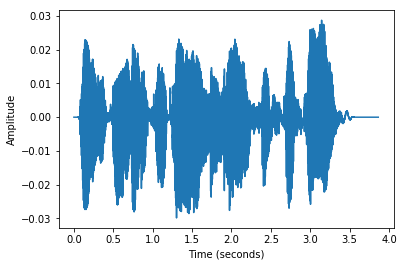

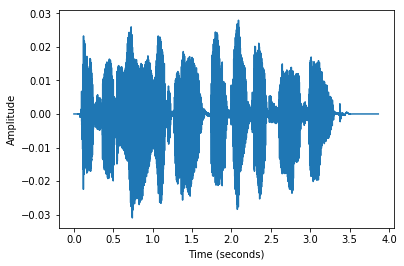

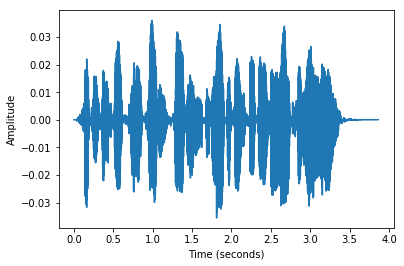

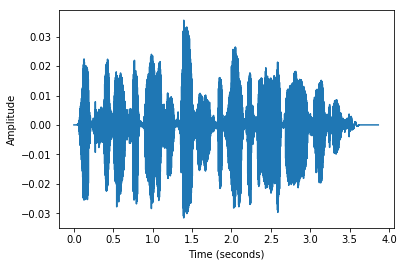

In [35]:
for idx, row in enumerate(S_2):
    show_audio((samp_rate, row))

In [100]:
WTf = nn.Linear(4, 4, bias=False)

Now, instead of using a matrix of our own definition, let's try using PyTorch's own linear transformation (`nn.linear`).

In [101]:
# prepare dataloader
audio_dataset = utils.TensorDataset(X1.t())
audio_dataloader = utils.DataLoader(audio_dataset, shuffle=False)

In [102]:
# set learning rate; SGD can be very finicky depending on this parameter
lr = 0.01

In [103]:
optimizer = torch.optim.SGD(WTf.parameters(), lr=lr)

In [104]:
loss_list = []

In [105]:
# outer loop: number of times to run through all the samples. In this case, one is enough to get good results.
for t in range(1):
    for idx, x_t in enumerate(audio_dataloader):
        x_t = x_t[0]
        #x_t = torch.transpose(x_t, 0, 1)
        
        # forward pass
        Y_pred = WTf(x_t)
        # compute loss
        # todo: try computing loss by loading time stamps in as training examples in shuffled order instead of whole matrix at once
        #log_likelihood = torch.sum(torch.log(sigmoid_der(Y_pred))) + torch.log(torch.abs(torch.det(WTf.weight)))
        ll = log_likelihood(Y_pred, WTf.weight)
        loss = -ll
        #print(t, loss)
        
        # good to check that our values are still sane and nothing has gone horribly wrong
        if torch.isnan(loss).any() or loss.item() == np.inf or loss.item() == -np.inf:
            print('Gradient vanished/exploded')
            raise Exception('Ded')
            break

        loss_list.append(loss)
#         print(idx, loss, end='\r')
        # compute gradient for gradient descent
        loss.backward()
        #print(W.grad)
        #print(t, W.grad)
        # recompute W in 'descent' step of gradient descent
        optimizer.step()
        optimizer.zero_grad()
    

In [106]:
WTf.weight

Parameter containing:
tensor([[ 0.7624,  0.4156, -1.7350,  0.8433],
        [-1.1239,  1.6599, -0.0585, -0.5243],
        [ 1.6174,  0.7108,  0.5973, -0.9561],
        [ 0.3321,  0.7758,  1.0151,  1.5608]])

We've found our $W$! Now all that's left is to transform our mixed reference data to our derived sources.

$$
({X1}^T W^T)^T = ((KX)^T W^T)^T = (X^TK^TW^T)^T = WKX
$$

In [108]:
WTf(torch.tensor((K @ X).T, dtype=torch.float)).t()

tensor([[ 1.9312e-05,  1.9647e-05,  1.9278e-05,  ...,  1.9585e-05,
          1.9337e-05,  1.9596e-05],
        [ 1.3210e-05,  1.3406e-05,  1.3238e-05,  ...,  1.3443e-05,
          1.3182e-05,  1.3446e-05],
        [ 5.7394e-06, -3.0055e-06,  5.7076e-06,  ..., -3.1054e-06,
          5.7331e-06, -3.1039e-06],
        [-2.6363e-05, -2.5102e-05, -2.6819e-05,  ..., -2.6613e-05,
         -2.6544e-05, -2.6673e-05]])

In [90]:
WTf(orig_X1.t()).t()

tensor([[ 4.2619e-02,  5.7005e+00,  1.6045e-01,  ...,  3.6402e-01,
         -1.1650e+00,  1.2179e-01],
        [ 2.9253e-01,  6.6583e+00, -2.0394e-01,  ...,  1.3067e+00,
         -1.2198e+00,  2.7875e-01],
        [-1.9692e+00, -8.1532e-01, -2.0958e+00,  ..., -5.5919e-01,
         -5.8024e+00, -2.2891e+00],
        [ 3.6980e+00,  6.4283e-01,  4.5859e+00,  ...,  3.6307e+00,
          3.6602e+00,  3.7738e+00]])

In [73]:
S_2

array([[-1.32097162e-05, -1.34064455e-05, -1.32384638e-05, ...,
        -1.34432279e-05, -1.31819153e-05, -1.34457146e-05],
       [ 1.93123302e-05,  1.96470951e-05,  1.92782076e-05, ...,
         1.95846992e-05,  1.93372877e-05,  1.95956992e-05],
       [-5.73936046e-06,  3.00545495e-06, -5.70756830e-06, ...,
         3.10543439e-06, -5.73309370e-06,  3.10390994e-06],
       [-2.63630683e-05, -2.51015430e-05, -2.68187627e-05, ...,
        -2.66130169e-05, -2.65439163e-05, -2.66725813e-05]])

In [109]:
# unwhiten W and calculate source signals
S_2 = WTf.weight.detach().numpy() @ K @ X

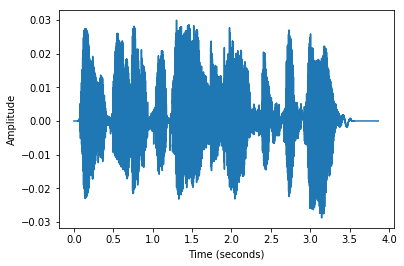

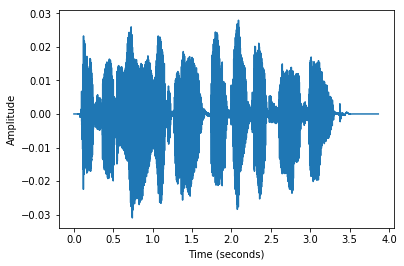

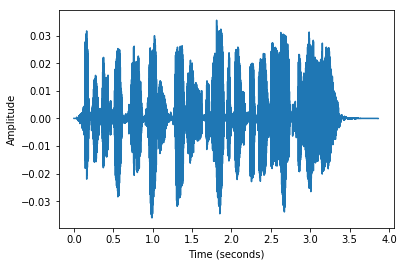

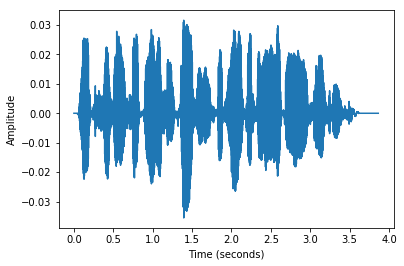

In [110]:
for idx, row in enumerate(S_2):
    show_audio((samp_rate, row))

And there you have it - each separate voice as a separate signal, perfect for transcription or whatever other task you'd like to do. (This also illustrates another important property of ICA: unlike in other methods such as PCA, the order of the components we get out is arbitrary. If you listen to each clip, you should be able to figure out what order I made them in!)

I think it's important to note here that there are much better algorithms than gradient descent for deriving independent components, namely FastICA <sup>9</sup>. However, I used gradient descent here very intentionally. With the code written down in this form, doesn't it look very familiar?

I hope it's clear that this resembles a one-layer neural network with a single linear layer and no nonlinearities. We used gradient descent to approximate a linear transformation; deeper neural networks with nonlinearities can be thought of as the application of gradient descent (or whatever optimization algorithm you like best, it doesn't matter) to approximate more complex functions. For blind source separation of audio, linear mixing (and thus unmixing) seems like a reasonable model, but it is easy to imagine other problems in which sources might be combined in some way that's highly nonlinear.

My first thought when learning about ICA was that we might want to use a proper neural network to learn a more complex invertible unmixing function. I think writing the code for linear ICA in this way makes the intuition for this idea more obvious than any other presentation I have found. Unfortunately other people also thought of this idea and have written papers on it, including this nice piece from Yoshua Bengio's lab <sup>10</sup>; fortunately that means it is a good idea, and I have more to read/write about. I plan on spending a while playing with this - if I get interesting results it might become my next post! For now, I hope this served as a good introduction to/refresher of linear ICA.

_Major credit to Aapo Hyvärinen and Erkki Oja for inspiring this post: most of this explanation is based on my understanding of their 'Independent Component Analysis: Algorithms and Applications' (https://www.cs.helsinki.fi/u/ahyvarin/papers/NN00new.pdf). I also referred to Andrew Ng's CS229 lecture notes on ICA as well as the Wikipedia page on the subject._

## Footnotes
1. This is an active area of research. For one interesting approach highly related to the form of ICA presented here, see http://www.jmlr.org/papers/v4/jang03a.html.
2. As in https://www.cs.helsinki.fi/u/ahyvarin/papers/NN00new.pdf, or http://cs229.stanford.edu/notes/cs229-notes11.pdf, or https://en.wikipedia.org/wiki/Independent_component_analysis, or pretty much any other introduction to ICA in existence.
3. See https://en.wikipedia.org/wiki/Independence_(probability_theory) to get a refresher on statistical independence.
4. Goodfellow, I., Bengio, Y., and Courville, A. (2016). _Deep learning_. Cambridge, MA: MIT Press.
5. Pham, D.-T., Garrat, P., and Jutten, C. (1992). Separation of a mixture of independent sources through a maximum likelihood approach. In _Proc. EUSIPCO_, pages 771–774.
6. http://cs229.stanford.edu/notes/cs229-notes11.pdf
7. http://blog.vctr.me/posts/central-limit-theorem.html provides a really nice visualization of this. Also note that it is not _always_ true (the full Central Limit Theorem has some caveats) but for our purposes it is good enough to take it at face value.
8. This is not exactly true; we can have exactly one be Gaussian, which we can think of as all the Gaussian-ness stuck into one component after the others are optimized for non-Gaussianity. Refer to Hyvärinen again. https://www.cs.helsinki.fi/u/ahyvarin/papers/NN00new.pdf
9. Hyvärinen again (in the same citation no less), he came up with this one. In case you haven't noticed, he's sort of a big deal in ICA.
10. Dinh, L., Krueger, D., and Bengio, Y. (2015). NICE: Non-linear Independent Components Estimation. https://arxiv.org/abs/1410.8516 (Nice, isn't it?)
